In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sys.path.append('/home/robot-i9/Anand/')
print(sys.path)

from NeuralBlocks.models.wresnet import WideResNet
# from NeuralBlocks.models.densenet import DenseNet

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# net1 = DenseNet(3, 10, norm='BN')
# net2 = WideResNet(depth=22, num_classes=10, widen_factor=5,dropout_rate=0.3,norm='BN')

# print(count_parameters(net1), count_parameters(net2))

['/home/robot-i9/Anand/NeuralBlocks/notebooks', '/home/robot-i9/miniconda3/envs/main/lib/python37.zip', '/home/robot-i9/miniconda3/envs/main/lib/python3.7', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/lib-dynload', '', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/extensions', '/home/robot-i9/.ipython', '/home/robot-i9/Anand/']


In [2]:
torch.manual_seed(2456)
# cudnn.deterministic = True
cudnn.benchmark = True
np.random.seed(2456)

NUM_EPOCH = 200
BATCH_SIZE = 128
CHECKPOINT_INTERVAL = 100
LRS = [0.0001, 0.001, 0.01]
NORMS =[None,'BN', 'SN', 'WN', 'MSN', 'MSNTReLU', 'WNTReLU']
DATA_PATH = "/home/robot-i9/Anand/NeuralBlocks/data_utils/datasets/SVHN/"
SAVE_PATH = "/home/robot-i9/Anand/NeuralBlocks/experiments/SVHN/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
trainset = torchvision.datasets.SVHN(root=DATA_PATH, download=True, transform=transform, split='train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testset = torchvision.datasets.SVHN(root=DATA_PATH, download=True, transform=transform, split='test')
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: /home/robot-i9/Anand/NeuralBlocks/data_utils/datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /home/robot-i9/Anand/NeuralBlocks/data_utils/datasets/SVHN/test_32x32.mat


In [4]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_loss_log.append(train_loss/(batch_idx+1))
        train_acc_log.append( 100.*correct/total)
        
        if(batch_idx%CHECKPOINT_INTERVAL==0):
             print("Train Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(trainloader),
                train_loss/(batch_idx+1), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            test_loss_log.append(test_loss/(batch_idx+1))
            test_acc_log.append( 100.*correct/total)
        
            if(batch_idx%CHECKPOINT_INTERVAL==0):
                print("Test Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(testloader),
                test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(SAVE_PATH+'checkpoint'):
            os.mkdir(SAVE_PATH+'checkpoint')
        torch.save(state, SAVE_PATH+'checkpoint/ckpt.pth')
        best_acc = acc

In [6]:
best_acc = 0 
#torch.autograd.set_detect_anomaly(True)
for lr in tqdm_notebook(LRS):
    for norm in tqdm_notebook(NORMS):
        net =  WideResNet(depth=16, num_classes=10, widen_factor=2,dropout_rate=0.3,norm=norm).cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)

        train_loss_log =[]
        train_acc_log = []
        test_loss_log =[]
        test_acc_log =[]

        for epoch in tqdm_notebook(range(NUM_EPOCH)):
            train(epoch)
            test(epoch)

        np.save(SAVE_PATH+"WideResNet_Train_loss_{}_{}.npy".format(norm,lr), train_loss_log)  
        np.save(SAVE_PATH+"WideResNet_Test_loss_{}_{}.npy".format(norm,lr), test_loss_log)    
        np.save(SAVE_PATH+"WideResNet_Train_Acc_{}_{}.npy".format(norm,lr), train_acc_log)    
        np.save(SAVE_PATH+"WideResNet_Test_Acc_{}_{}.npy".format(norm,lr), test_acc_log)   
        del net

Train Epoch [  0/200]Batch [  0/573] Loss: 2.317 Acc 4.688%
Train Epoch [  0/200]Batch [100/573] Loss: 2.242 Acc 18.464%
Train Epoch [  0/200]Batch [200/573] Loss: 2.242 Acc 18.676%
Train Epoch [  0/200]Batch [300/573] Loss: 2.240 Acc 18.732%
Train Epoch [  0/200]Batch [400/573] Loss: 2.240 Acc 18.742%
Train Epoch [  0/200]Batch [500/573] Loss: 2.239 Acc 18.777%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.221 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.222 Acc 19.574%
Saving..
Train Epoch [  1/200]Batch [  0/573] Loss: 2.253 Acc 12.500%
Train Epoch [  1/200]Batch [100/573] Loss: 2.233 Acc 19.013%
Train Epoch [  1/200]Batch [200/573] Loss: 2.234 Acc 18.921%
Train Epoch [  1/200]Batch [300/573] Loss: 2.226 Acc 19.651%
Train Epoch [  1/200]Batch [400/573] Loss: 2.195 Acc 21.160%
Train Epoch [  1/200]Batch [500/573] Loss: 2.139 Acc 23.408%
Test Epoch [  1/200]Batch [  0/204] Loss: 1.670 Acc 36.719%
Test Epoch [  1/200]

Test Epoch [ 14/200]Batch [100/204] Loss: 0.318 Acc 90.803%
Test Epoch [ 14/200]Batch [200/204] Loss: 0.311 Acc 90.711%
Train Epoch [ 15/200]Batch [  0/573] Loss: 0.339 Acc 90.625%
Train Epoch [ 15/200]Batch [100/573] Loss: 0.364 Acc 88.869%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.364 Acc 88.740%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.366 Acc 88.777%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.363 Acc 88.862%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.363 Acc 88.882%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.415 Acc 89.062%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.316 Acc 91.027%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.308 Acc 91.107%
Saving..
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.384 Acc 85.156%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.356 Acc 89.310%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.354 Acc 89.171%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.349 Acc 89.314%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.344 Acc 89.524%
Train Epoch [ 16/200

Test Epoch [ 29/200]Batch [  0/204] Loss: 0.338 Acc 92.969%
Test Epoch [ 29/200]Batch [100/204] Loss: 0.237 Acc 93.502%
Test Epoch [ 29/200]Batch [200/204] Loss: 0.231 Acc 93.567%
Train Epoch [ 30/200]Batch [  0/573] Loss: 0.190 Acc 92.969%
Train Epoch [ 30/200]Batch [100/573] Loss: 0.257 Acc 92.713%
Train Epoch [ 30/200]Batch [200/573] Loss: 0.255 Acc 92.568%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.258 Acc 92.382%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.257 Acc 92.443%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.258 Acc 92.403%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.300 Acc 92.188%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.231 Acc 93.827%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.224 Acc 93.886%
Saving..
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.285 Acc 91.406%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.262 Acc 92.396%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.253 Acc 92.483%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.255 Acc 92.416%
Train Epoch [ 31/200]

Test Epoch [ 44/200]Batch [  0/204] Loss: 0.195 Acc 94.531%
Test Epoch [ 44/200]Batch [100/204] Loss: 0.208 Acc 94.609%
Test Epoch [ 44/200]Batch [200/204] Loss: 0.203 Acc 94.632%
Train Epoch [ 45/200]Batch [  0/573] Loss: 0.292 Acc 90.625%
Train Epoch [ 45/200]Batch [100/573] Loss: 0.222 Acc 93.464%
Train Epoch [ 45/200]Batch [200/573] Loss: 0.219 Acc 93.711%
Train Epoch [ 45/200]Batch [300/573] Loss: 0.216 Acc 93.758%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.214 Acc 93.748%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.216 Acc 93.703%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.266 Acc 93.750%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.208 Acc 94.616%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.203 Acc 94.590%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.186 Acc 93.750%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.205 Acc 94.144%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.212 Acc 93.902%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.210 Acc 93.908%
Train Epoch [ 46/200]Batch [40

Test Epoch [ 59/200]Batch [  0/204] Loss: 0.212 Acc 94.531%
Test Epoch [ 59/200]Batch [100/204] Loss: 0.195 Acc 95.119%
Test Epoch [ 59/200]Batch [200/204] Loss: 0.190 Acc 95.211%
Train Epoch [ 60/200]Batch [  0/573] Loss: 0.280 Acc 89.844%
Train Epoch [ 60/200]Batch [100/573] Loss: 0.180 Acc 94.856%
Train Epoch [ 60/200]Batch [200/573] Loss: 0.180 Acc 94.920%
Train Epoch [ 60/200]Batch [300/573] Loss: 0.184 Acc 94.767%
Train Epoch [ 60/200]Batch [400/573] Loss: 0.188 Acc 94.631%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.189 Acc 94.592%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.211 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.186 Acc 95.289%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.179 Acc 95.386%
Saving..
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.079 Acc 98.438%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.185 Acc 94.655%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.189 Acc 94.617%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.193 Acc 94.534%
Train Epoch [ 61/200]

Test Epoch [ 74/200]Batch [  0/204] Loss: 0.224 Acc 92.969%
Test Epoch [ 74/200]Batch [100/204] Loss: 0.192 Acc 95.343%
Test Epoch [ 74/200]Batch [200/204] Loss: 0.183 Acc 95.534%
Train Epoch [ 75/200]Batch [  0/573] Loss: 0.108 Acc 96.875%
Train Epoch [ 75/200]Batch [100/573] Loss: 0.164 Acc 95.212%
Train Epoch [ 75/200]Batch [200/573] Loss: 0.162 Acc 95.219%
Train Epoch [ 75/200]Batch [300/573] Loss: 0.164 Acc 95.229%
Train Epoch [ 75/200]Batch [400/573] Loss: 0.167 Acc 95.170%
Train Epoch [ 75/200]Batch [500/573] Loss: 0.170 Acc 95.114%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.205 Acc 92.969%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.183 Acc 95.405%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.176 Acc 95.491%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.162 Acc 97.656%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.176 Acc 94.817%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.171 Acc 94.943%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.172 Acc 94.954%
Train Epoch [ 76/200]Batch [40

Test Epoch [ 89/200]Batch [  0/204] Loss: 0.185 Acc 94.531%
Test Epoch [ 89/200]Batch [100/204] Loss: 0.186 Acc 95.568%
Test Epoch [ 89/200]Batch [200/204] Loss: 0.179 Acc 95.534%
Train Epoch [ 90/200]Batch [  0/573] Loss: 0.115 Acc 98.438%
Train Epoch [ 90/200]Batch [100/573] Loss: 0.152 Acc 95.676%
Train Epoch [ 90/200]Batch [200/573] Loss: 0.155 Acc 95.487%
Train Epoch [ 90/200]Batch [300/573] Loss: 0.156 Acc 95.531%
Train Epoch [ 90/200]Batch [400/573] Loss: 0.154 Acc 95.560%
Train Epoch [ 90/200]Batch [500/573] Loss: 0.156 Acc 95.482%
Test Epoch [ 90/200]Batch [  0/204] Loss: 0.172 Acc 94.531%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.174 Acc 95.653%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.168 Acc 95.705%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.139 Acc 96.094%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.147 Acc 95.606%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.150 Acc 95.620%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.154 Acc 95.546%
Train Epoch [ 91/200]Batch [40

Test Epoch [104/200]Batch [  0/204] Loss: 0.164 Acc 93.750%
Test Epoch [104/200]Batch [100/204] Loss: 0.198 Acc 95.204%
Test Epoch [104/200]Batch [200/204] Loss: 0.189 Acc 95.278%
Train Epoch [105/200]Batch [  0/573] Loss: 0.190 Acc 95.312%
Train Epoch [105/200]Batch [100/573] Loss: 0.142 Acc 95.753%
Train Epoch [105/200]Batch [200/573] Loss: 0.142 Acc 95.857%
Train Epoch [105/200]Batch [300/573] Loss: 0.144 Acc 95.816%
Train Epoch [105/200]Batch [400/573] Loss: 0.142 Acc 95.805%
Train Epoch [105/200]Batch [500/573] Loss: 0.143 Acc 95.808%
Test Epoch [105/200]Batch [  0/204] Loss: 0.180 Acc 94.531%
Test Epoch [105/200]Batch [100/204] Loss: 0.180 Acc 95.784%
Test Epoch [105/200]Batch [200/204] Loss: 0.171 Acc 95.864%
Train Epoch [106/200]Batch [  0/573] Loss: 0.152 Acc 95.312%
Train Epoch [106/200]Batch [100/573] Loss: 0.139 Acc 95.707%
Train Epoch [106/200]Batch [200/573] Loss: 0.141 Acc 95.759%
Train Epoch [106/200]Batch [300/573] Loss: 0.140 Acc 95.787%
Train Epoch [106/200]Batch [40

Test Epoch [119/200]Batch [  0/204] Loss: 0.147 Acc 95.312%
Test Epoch [119/200]Batch [100/204] Loss: 0.179 Acc 95.769%
Test Epoch [119/200]Batch [200/204] Loss: 0.169 Acc 95.829%
Train Epoch [120/200]Batch [  0/573] Loss: 0.071 Acc 98.438%
Train Epoch [120/200]Batch [100/573] Loss: 0.126 Acc 96.411%
Train Epoch [120/200]Batch [200/573] Loss: 0.128 Acc 96.319%
Train Epoch [120/200]Batch [300/573] Loss: 0.131 Acc 96.262%
Train Epoch [120/200]Batch [400/573] Loss: 0.131 Acc 96.242%
Train Epoch [120/200]Batch [500/573] Loss: 0.132 Acc 96.172%
Test Epoch [120/200]Batch [  0/204] Loss: 0.154 Acc 95.312%
Test Epoch [120/200]Batch [100/204] Loss: 0.184 Acc 95.777%
Test Epoch [120/200]Batch [200/204] Loss: 0.174 Acc 95.829%
Train Epoch [121/200]Batch [  0/573] Loss: 0.102 Acc 96.094%
Train Epoch [121/200]Batch [100/573] Loss: 0.129 Acc 96.202%
Train Epoch [121/200]Batch [200/573] Loss: 0.125 Acc 96.381%
Train Epoch [121/200]Batch [300/573] Loss: 0.129 Acc 96.288%
Train Epoch [121/200]Batch [40

Test Epoch [134/200]Batch [100/204] Loss: 0.194 Acc 95.537%
Test Epoch [134/200]Batch [200/204] Loss: 0.186 Acc 95.627%
Train Epoch [135/200]Batch [  0/573] Loss: 0.100 Acc 96.875%
Train Epoch [135/200]Batch [100/573] Loss: 0.119 Acc 96.457%
Train Epoch [135/200]Batch [200/573] Loss: 0.121 Acc 96.354%
Train Epoch [135/200]Batch [300/573] Loss: 0.120 Acc 96.408%
Train Epoch [135/200]Batch [400/573] Loss: 0.121 Acc 96.396%
Train Epoch [135/200]Batch [500/573] Loss: 0.123 Acc 96.325%
Test Epoch [135/200]Batch [  0/204] Loss: 0.157 Acc 94.531%
Test Epoch [135/200]Batch [100/204] Loss: 0.189 Acc 95.514%
Test Epoch [135/200]Batch [200/204] Loss: 0.178 Acc 95.690%
Train Epoch [136/200]Batch [  0/573] Loss: 0.037 Acc 99.219%
Train Epoch [136/200]Batch [100/573] Loss: 0.123 Acc 96.419%
Train Epoch [136/200]Batch [200/573] Loss: 0.123 Acc 96.331%
Train Epoch [136/200]Batch [300/573] Loss: 0.122 Acc 96.333%
Train Epoch [136/200]Batch [400/573] Loss: 0.123 Acc 96.287%
Train Epoch [136/200]Batch [5

Test Epoch [149/200]Batch [200/204] Loss: 0.191 Acc 95.725%
Train Epoch [150/200]Batch [  0/573] Loss: 0.118 Acc 96.094%
Train Epoch [150/200]Batch [100/573] Loss: 0.117 Acc 96.419%
Train Epoch [150/200]Batch [200/573] Loss: 0.111 Acc 96.615%
Train Epoch [150/200]Batch [300/573] Loss: 0.110 Acc 96.670%
Train Epoch [150/200]Batch [400/573] Loss: 0.110 Acc 96.698%
Train Epoch [150/200]Batch [500/573] Loss: 0.112 Acc 96.655%
Test Epoch [150/200]Batch [  0/204] Loss: 0.146 Acc 94.531%
Test Epoch [150/200]Batch [100/204] Loss: 0.186 Acc 95.699%
Test Epoch [150/200]Batch [200/204] Loss: 0.177 Acc 95.802%
Train Epoch [151/200]Batch [  0/573] Loss: 0.154 Acc 96.875%
Train Epoch [151/200]Batch [100/573] Loss: 0.112 Acc 96.674%
Train Epoch [151/200]Batch [200/573] Loss: 0.109 Acc 96.817%
Train Epoch [151/200]Batch [300/573] Loss: 0.108 Acc 96.833%
Train Epoch [151/200]Batch [400/573] Loss: 0.111 Acc 96.752%
Train Epoch [151/200]Batch [500/573] Loss: 0.115 Acc 96.604%
Test Epoch [151/200]Batch [ 

Train Epoch [165/200]Batch [  0/573] Loss: 0.098 Acc 97.656%
Train Epoch [165/200]Batch [100/573] Loss: 0.101 Acc 97.084%
Train Epoch [165/200]Batch [200/573] Loss: 0.106 Acc 96.922%
Train Epoch [165/200]Batch [300/573] Loss: 0.103 Acc 96.901%
Train Epoch [165/200]Batch [400/573] Loss: 0.104 Acc 96.863%
Train Epoch [165/200]Batch [500/573] Loss: 0.104 Acc 96.838%
Test Epoch [165/200]Batch [  0/204] Loss: 0.115 Acc 96.875%
Test Epoch [165/200]Batch [100/204] Loss: 0.194 Acc 95.838%
Test Epoch [165/200]Batch [200/204] Loss: 0.185 Acc 95.884%
Train Epoch [166/200]Batch [  0/573] Loss: 0.157 Acc 96.094%
Train Epoch [166/200]Batch [100/573] Loss: 0.108 Acc 96.883%
Train Epoch [166/200]Batch [200/573] Loss: 0.101 Acc 96.937%
Train Epoch [166/200]Batch [300/573] Loss: 0.103 Acc 96.909%
Train Epoch [166/200]Batch [400/573] Loss: 0.104 Acc 96.920%
Train Epoch [166/200]Batch [500/573] Loss: 0.107 Acc 96.836%
Test Epoch [166/200]Batch [  0/204] Loss: 0.132 Acc 95.312%
Test Epoch [166/200]Batch [1

Train Epoch [180/200]Batch [  0/573] Loss: 0.143 Acc 94.531%
Train Epoch [180/200]Batch [100/573] Loss: 0.095 Acc 97.030%
Train Epoch [180/200]Batch [200/573] Loss: 0.100 Acc 96.875%
Train Epoch [180/200]Batch [300/573] Loss: 0.100 Acc 96.896%
Train Epoch [180/200]Batch [400/573] Loss: 0.100 Acc 96.887%
Train Epoch [180/200]Batch [500/573] Loss: 0.101 Acc 96.905%
Test Epoch [180/200]Batch [  0/204] Loss: 0.131 Acc 96.875%
Test Epoch [180/200]Batch [100/204] Loss: 0.203 Acc 95.854%
Test Epoch [180/200]Batch [200/204] Loss: 0.193 Acc 95.899%
Train Epoch [181/200]Batch [  0/573] Loss: 0.074 Acc 97.656%
Train Epoch [181/200]Batch [100/573] Loss: 0.098 Acc 97.107%
Train Epoch [181/200]Batch [200/573] Loss: 0.099 Acc 97.046%
Train Epoch [181/200]Batch [300/573] Loss: 0.100 Acc 96.994%
Train Epoch [181/200]Batch [400/573] Loss: 0.101 Acc 96.949%
Train Epoch [181/200]Batch [500/573] Loss: 0.100 Acc 96.955%
Test Epoch [181/200]Batch [  0/204] Loss: 0.171 Acc 94.531%
Test Epoch [181/200]Batch [1

Train Epoch [195/200]Batch [100/573] Loss: 0.097 Acc 97.037%
Train Epoch [195/200]Batch [200/573] Loss: 0.094 Acc 97.104%
Train Epoch [195/200]Batch [300/573] Loss: 0.095 Acc 97.088%
Train Epoch [195/200]Batch [400/573] Loss: 0.095 Acc 97.056%
Train Epoch [195/200]Batch [500/573] Loss: 0.096 Acc 97.076%
Test Epoch [195/200]Batch [  0/204] Loss: 0.161 Acc 95.312%
Test Epoch [195/200]Batch [100/204] Loss: 0.215 Acc 95.738%
Test Epoch [195/200]Batch [200/204] Loss: 0.202 Acc 95.888%
Train Epoch [196/200]Batch [  0/573] Loss: 0.141 Acc 93.750%
Train Epoch [196/200]Batch [100/573] Loss: 0.092 Acc 96.929%
Train Epoch [196/200]Batch [200/573] Loss: 0.091 Acc 97.108%
Train Epoch [196/200]Batch [300/573] Loss: 0.091 Acc 97.173%
Train Epoch [196/200]Batch [400/573] Loss: 0.091 Acc 97.173%
Train Epoch [196/200]Batch [500/573] Loss: 0.092 Acc 97.160%
Test Epoch [196/200]Batch [  0/204] Loss: 0.162 Acc 96.094%
Test Epoch [196/200]Batch [100/204] Loss: 0.202 Acc 95.676%
Test Epoch [196/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.337 Acc 9.375%
Train Epoch [  0/200]Batch [100/573] Loss: 2.309 Acc 8.988%
Train Epoch [  0/200]Batch [200/573] Loss: 2.266 Acc 15.683%
Train Epoch [  0/200]Batch [300/573] Loss: 2.215 Acc 19.721%
Train Epoch [  0/200]Batch [400/573] Loss: 2.164 Acc 22.695%
Train Epoch [  0/200]Batch [500/573] Loss: 2.117 Acc 24.975%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.655 Acc 41.406%
Test Epoch [  0/200]Batch [100/204] Loss: 1.703 Acc 39.550%
Test Epoch [  0/200]Batch [200/204] Loss: 1.704 Acc 39.657%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.838 Acc 35.156%
Train Epoch [  1/200]Batch [100/573] Loss: 1.781 Acc 38.459%
Train Epoch [  1/200]Batch [200/573] Loss: 1.732 Acc 40.668%
Train Epoch [  1/200]Batch [300/573] Loss: 1.683 Acc 42.951%
Train Epoch [  1/200]Batch [400/573] Loss: 1.635 Acc 45.355%
Train Epoch [  1/200]Batch [500/573] Loss: 1.592 Acc 47.452%
Test Epoch [  1/200]Batch [  0/204] Loss: 1.155 Acc 57.812%
Test Epoch [  1/200]Batch [100

Train Epoch [ 15/200]Batch [100/573] Loss: 0.247 Acc 93.054%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.254 Acc 92.782%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.249 Acc 92.893%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.250 Acc 92.803%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.251 Acc 92.730%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.282 Acc 89.844%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.223 Acc 93.626%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.221 Acc 93.544%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.379 Acc 91.406%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.247 Acc 92.845%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.249 Acc 92.763%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.248 Acc 92.761%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.248 Acc 92.768%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.246 Acc 92.827%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.185 Acc 91.406%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.209 Acc 94.067%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.196 Acc 94.286%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.196 Acc 94.295%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.197 Acc 94.221%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.196 Acc 94.261%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.179 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.183 Acc 95.227%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.181 Acc 95.122%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.248 Acc 93.750%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.201 Acc 94.183%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.194 Acc 94.380%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.197 Acc 94.347%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.197 Acc 94.362%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.196 Acc 94.343%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.217 Acc 93.750%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.185 Acc 94.926%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.185 Acc 94.908%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.171 Acc 95.061%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.171 Acc 95.028%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.174 Acc 94.976%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.159 Acc 95.312%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.162 Acc 95.684%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.162 Acc 95.674%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.114 Acc 96.875%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.165 Acc 95.142%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.166 Acc 95.103%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.164 Acc 95.167%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.166 Acc 95.092%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.169 Acc 95.079%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.109 Acc 96.094%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.163 Acc 95.653%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.160 Acc 95.686%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.176 Acc 93.750%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.153 Acc 95.642%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.154 Acc 95.590%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.168 Acc 93.750%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.168 Acc 95.599%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.162 Acc 95.791%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.123 Acc 95.312%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.152 Acc 95.800%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.155 Acc 95.655%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.152 Acc 95.629%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.152 Acc 95.611%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.152 Acc 95.589%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.161 Acc 95.312%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.192 Acc 95.166%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.187 Acc 95.114%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.129 Acc 96.875%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.145 Acc 95.877%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.140 Acc 95.966%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.156 Acc 96.094%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.169 Acc 95.684%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.165 Acc 95.775%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.115 Acc 96.875%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.131 Acc 96.101%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.134 Acc 96.094%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.132 Acc 96.140%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.135 Acc 96.057%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.138 Acc 96.049%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.149 Acc 96.094%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.159 Acc 95.931%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.155 Acc 95.977%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.177 Acc 93.750%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.128 Acc 96.272%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.133 Acc 96.257%
Train Epoch [ 77/200]Batch [30

Train Epoch [ 90/200]Batch [500/573] Loss: 0.128 Acc 96.268%
Test Epoch [ 90/200]Batch [  0/204] Loss: 0.125 Acc 96.094%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.173 Acc 95.614%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.169 Acc 95.763%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.074 Acc 96.875%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.114 Acc 96.620%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.122 Acc 96.467%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.124 Acc 96.353%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.125 Acc 96.359%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.127 Acc 96.334%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.132 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.164 Acc 95.962%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.158 Acc 96.035%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.142 Acc 96.094%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.124 Acc 96.504%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.126 Acc 96.405%
Train Epoch [ 92/200]Batch [30

Train Epoch [105/200]Batch [500/573] Loss: 0.119 Acc 96.510%
Test Epoch [105/200]Batch [  0/204] Loss: 0.135 Acc 96.094%
Test Epoch [105/200]Batch [100/204] Loss: 0.166 Acc 95.985%
Test Epoch [105/200]Batch [200/204] Loss: 0.163 Acc 96.008%
Train Epoch [106/200]Batch [  0/573] Loss: 0.085 Acc 97.656%
Train Epoch [106/200]Batch [100/573] Loss: 0.126 Acc 96.357%
Train Epoch [106/200]Batch [200/573] Loss: 0.120 Acc 96.517%
Train Epoch [106/200]Batch [300/573] Loss: 0.121 Acc 96.525%
Train Epoch [106/200]Batch [400/573] Loss: 0.119 Acc 96.546%
Train Epoch [106/200]Batch [500/573] Loss: 0.119 Acc 96.538%
Test Epoch [106/200]Batch [  0/204] Loss: 0.137 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.167 Acc 95.823%
Test Epoch [106/200]Batch [200/204] Loss: 0.162 Acc 95.946%
Train Epoch [107/200]Batch [  0/573] Loss: 0.121 Acc 95.312%
Train Epoch [107/200]Batch [100/573] Loss: 0.119 Acc 96.566%
Train Epoch [107/200]Batch [200/573] Loss: 0.119 Acc 96.673%
Train Epoch [107/200]Batch [30

Test Epoch [120/200]Batch [  0/204] Loss: 0.140 Acc 96.094%
Test Epoch [120/200]Batch [100/204] Loss: 0.175 Acc 95.854%
Test Epoch [120/200]Batch [200/204] Loss: 0.170 Acc 95.958%
Train Epoch [121/200]Batch [  0/573] Loss: 0.035 Acc 99.219%
Train Epoch [121/200]Batch [100/573] Loss: 0.102 Acc 96.852%
Train Epoch [121/200]Batch [200/573] Loss: 0.107 Acc 96.832%
Train Epoch [121/200]Batch [300/573] Loss: 0.106 Acc 96.909%
Train Epoch [121/200]Batch [400/573] Loss: 0.106 Acc 96.879%
Train Epoch [121/200]Batch [500/573] Loss: 0.107 Acc 96.836%
Test Epoch [121/200]Batch [  0/204] Loss: 0.113 Acc 96.094%
Test Epoch [121/200]Batch [100/204] Loss: 0.166 Acc 95.924%
Test Epoch [121/200]Batch [200/204] Loss: 0.162 Acc 95.989%
Train Epoch [122/200]Batch [  0/573] Loss: 0.103 Acc 96.875%
Train Epoch [122/200]Batch [100/573] Loss: 0.102 Acc 97.192%
Train Epoch [122/200]Batch [200/573] Loss: 0.105 Acc 96.941%
Train Epoch [122/200]Batch [300/573] Loss: 0.108 Acc 96.805%
Train Epoch [122/200]Batch [40

Test Epoch [135/200]Batch [100/204] Loss: 0.175 Acc 95.838%
Test Epoch [135/200]Batch [200/204] Loss: 0.173 Acc 95.791%
Train Epoch [136/200]Batch [  0/573] Loss: 0.105 Acc 96.875%
Train Epoch [136/200]Batch [100/573] Loss: 0.105 Acc 96.844%
Train Epoch [136/200]Batch [200/573] Loss: 0.103 Acc 96.933%
Train Epoch [136/200]Batch [300/573] Loss: 0.105 Acc 96.867%
Train Epoch [136/200]Batch [400/573] Loss: 0.105 Acc 96.857%
Train Epoch [136/200]Batch [500/573] Loss: 0.104 Acc 96.906%
Test Epoch [136/200]Batch [  0/204] Loss: 0.142 Acc 96.875%
Test Epoch [136/200]Batch [100/204] Loss: 0.175 Acc 95.978%
Test Epoch [136/200]Batch [200/204] Loss: 0.168 Acc 96.117%
Train Epoch [137/200]Batch [  0/573] Loss: 0.191 Acc 92.969%
Train Epoch [137/200]Batch [100/573] Loss: 0.096 Acc 97.246%
Train Epoch [137/200]Batch [200/573] Loss: 0.097 Acc 97.151%
Train Epoch [137/200]Batch [300/573] Loss: 0.100 Acc 97.015%
Train Epoch [137/200]Batch [400/573] Loss: 0.103 Acc 96.918%
Train Epoch [137/200]Batch [5

Test Epoch [150/200]Batch [200/204] Loss: 0.178 Acc 95.861%
Train Epoch [151/200]Batch [  0/573] Loss: 0.125 Acc 96.094%
Train Epoch [151/200]Batch [100/573] Loss: 0.098 Acc 96.867%
Train Epoch [151/200]Batch [200/573] Loss: 0.097 Acc 96.976%
Train Epoch [151/200]Batch [300/573] Loss: 0.096 Acc 97.028%
Train Epoch [151/200]Batch [400/573] Loss: 0.097 Acc 97.015%
Train Epoch [151/200]Batch [500/573] Loss: 0.098 Acc 97.037%
Test Epoch [151/200]Batch [  0/204] Loss: 0.103 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.169 Acc 96.032%
Test Epoch [151/200]Batch [200/204] Loss: 0.165 Acc 96.039%
Train Epoch [152/200]Batch [  0/573] Loss: 0.062 Acc 99.219%
Train Epoch [152/200]Batch [100/573] Loss: 0.094 Acc 97.099%
Train Epoch [152/200]Batch [200/573] Loss: 0.094 Acc 97.167%
Train Epoch [152/200]Batch [300/573] Loss: 0.096 Acc 97.101%
Train Epoch [152/200]Batch [400/573] Loss: 0.097 Acc 97.052%
Train Epoch [152/200]Batch [500/573] Loss: 0.099 Acc 97.045%
Test Epoch [152/200]Batch [ 

Train Epoch [166/200]Batch [  0/573] Loss: 0.149 Acc 96.094%
Train Epoch [166/200]Batch [100/573] Loss: 0.090 Acc 97.153%
Train Epoch [166/200]Batch [200/573] Loss: 0.087 Acc 97.252%
Train Epoch [166/200]Batch [300/573] Loss: 0.092 Acc 97.171%
Train Epoch [166/200]Batch [400/573] Loss: 0.092 Acc 97.181%
Train Epoch [166/200]Batch [500/573] Loss: 0.092 Acc 97.188%
Test Epoch [166/200]Batch [  0/204] Loss: 0.143 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.181 Acc 95.800%
Test Epoch [166/200]Batch [200/204] Loss: 0.175 Acc 95.884%
Train Epoch [167/200]Batch [  0/573] Loss: 0.185 Acc 96.875%
Train Epoch [167/200]Batch [100/573] Loss: 0.089 Acc 97.231%
Train Epoch [167/200]Batch [200/573] Loss: 0.089 Acc 97.163%
Train Epoch [167/200]Batch [300/573] Loss: 0.088 Acc 97.228%
Train Epoch [167/200]Batch [400/573] Loss: 0.088 Acc 97.232%
Train Epoch [167/200]Batch [500/573] Loss: 0.091 Acc 97.185%
Test Epoch [167/200]Batch [  0/204] Loss: 0.159 Acc 96.094%
Test Epoch [167/200]Batch [1

Train Epoch [181/200]Batch [100/573] Loss: 0.086 Acc 97.347%
Train Epoch [181/200]Batch [200/573] Loss: 0.086 Acc 97.322%
Train Epoch [181/200]Batch [300/573] Loss: 0.085 Acc 97.392%
Train Epoch [181/200]Batch [400/573] Loss: 0.086 Acc 97.345%
Train Epoch [181/200]Batch [500/573] Loss: 0.086 Acc 97.349%
Test Epoch [181/200]Batch [  0/204] Loss: 0.158 Acc 95.312%
Test Epoch [181/200]Batch [100/204] Loss: 0.179 Acc 95.931%
Test Epoch [181/200]Batch [200/204] Loss: 0.176 Acc 95.977%
Train Epoch [182/200]Batch [  0/573] Loss: 0.023 Acc 99.219%
Train Epoch [182/200]Batch [100/573] Loss: 0.087 Acc 97.231%
Train Epoch [182/200]Batch [200/573] Loss: 0.085 Acc 97.384%
Train Epoch [182/200]Batch [300/573] Loss: 0.086 Acc 97.358%
Train Epoch [182/200]Batch [400/573] Loss: 0.086 Acc 97.346%
Train Epoch [182/200]Batch [500/573] Loss: 0.087 Acc 97.309%
Test Epoch [182/200]Batch [  0/204] Loss: 0.164 Acc 95.312%
Test Epoch [182/200]Batch [100/204] Loss: 0.185 Acc 95.784%
Test Epoch [182/200]Batch [20

Train Epoch [196/200]Batch [200/573] Loss: 0.076 Acc 97.606%
Train Epoch [196/200]Batch [300/573] Loss: 0.079 Acc 97.612%
Train Epoch [196/200]Batch [400/573] Loss: 0.082 Acc 97.553%
Train Epoch [196/200]Batch [500/573] Loss: 0.083 Acc 97.486%
Test Epoch [196/200]Batch [  0/204] Loss: 0.185 Acc 95.312%
Test Epoch [196/200]Batch [100/204] Loss: 0.182 Acc 95.730%
Test Epoch [196/200]Batch [200/204] Loss: 0.179 Acc 95.814%
Train Epoch [197/200]Batch [  0/573] Loss: 0.132 Acc 94.531%
Train Epoch [197/200]Batch [100/573] Loss: 0.076 Acc 97.401%
Train Epoch [197/200]Batch [200/573] Loss: 0.081 Acc 97.361%
Train Epoch [197/200]Batch [300/573] Loss: 0.081 Acc 97.417%
Train Epoch [197/200]Batch [400/573] Loss: 0.082 Acc 97.419%
Train Epoch [197/200]Batch [500/573] Loss: 0.083 Acc 97.405%
Test Epoch [197/200]Batch [  0/204] Loss: 0.155 Acc 95.312%
Test Epoch [197/200]Batch [100/204] Loss: 0.185 Acc 95.792%
Test Epoch [197/200]Batch [200/204] Loss: 0.182 Acc 95.853%
Train Epoch [198/200]Batch [  

Train Epoch [  0/200]Batch [  0/573] Loss: 2.310 Acc 7.031%
Train Epoch [  0/200]Batch [100/573] Loss: 2.244 Acc 18.750%
Train Epoch [  0/200]Batch [200/573] Loss: 2.240 Acc 18.975%
Train Epoch [  0/200]Batch [300/573] Loss: 2.239 Acc 18.898%
Train Epoch [  0/200]Batch [400/573] Loss: 2.240 Acc 18.816%
Train Epoch [  0/200]Batch [500/573] Loss: 2.239 Acc 18.840%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.220 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.221 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.277 Acc 17.188%
Train Epoch [  1/200]Batch [100/573] Loss: 2.231 Acc 18.696%
Train Epoch [  1/200]Batch [200/573] Loss: 2.226 Acc 19.026%
Train Epoch [  1/200]Batch [300/573] Loss: 2.194 Acc 20.416%
Train Epoch [  1/200]Batch [400/573] Loss: 2.137 Acc 22.765%
Train Epoch [  1/200]Batch [500/573] Loss: 2.069 Acc 25.787%
Test Epoch [  1/200]Batch [  0/204] Loss: 1.452 Acc 54.688%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.344 Acc 89.697%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.341 Acc 89.649%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.341 Acc 89.558%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.341 Acc 89.518%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.342 Acc 89.469%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.276 Acc 89.844%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.294 Acc 91.638%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.287 Acc 91.667%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.251 Acc 93.750%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.331 Acc 89.975%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.334 Acc 89.910%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.333 Acc 89.870%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.337 Acc 89.768%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.336 Acc 89.780%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.270 Acc 92.188%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.261 Acc 92.551%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.256 Acc 92.374%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.252 Acc 92.465%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.253 Acc 92.449%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.253 Acc 92.473%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.207 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.211 Acc 94.330%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.209 Acc 94.267%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.186 Acc 92.969%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.248 Acc 92.698%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.248 Acc 92.654%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.246 Acc 92.681%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.251 Acc 92.628%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.250 Acc 92.652%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.173 Acc 92.969%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.205 Acc 94.562%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.202 Acc 94.504%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.214 Acc 93.706%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.214 Acc 93.713%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.213 Acc 93.789%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.175 Acc 93.750%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.182 Acc 95.405%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.180 Acc 95.301%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.279 Acc 93.750%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.200 Acc 94.121%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.202 Acc 94.201%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.207 Acc 94.087%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.211 Acc 93.999%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.211 Acc 93.943%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.177 Acc 92.188%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.189 Acc 94.995%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.187 Acc 95.005%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.305 Acc 90.625%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.191 Acc 94.438%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.191 Acc 94.453%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.112 Acc 94.531%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.175 Acc 95.374%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.171 Acc 95.476%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.126 Acc 97.656%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.177 Acc 94.670%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.184 Acc 94.710%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.189 Acc 94.609%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.191 Acc 94.555%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.191 Acc 94.553%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.135 Acc 95.312%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.177 Acc 95.459%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.176 Acc 95.336%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.214 Acc 94.531%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.177 Acc 94.787%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.172 Acc 95.058%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.131 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.185 Acc 95.251%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.186 Acc 95.192%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.185 Acc 96.875%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.162 Acc 95.227%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.167 Acc 95.095%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.167 Acc 95.175%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.169 Acc 95.162%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.171 Acc 95.094%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.102 Acc 96.094%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.179 Acc 95.506%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.176 Acc 95.460%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.112 Acc 96.875%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.172 Acc 95.042%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.170 Acc 94.967%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.111 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.174 Acc 95.862%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.171 Acc 95.794%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.144 Acc 96.094%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.155 Acc 95.514%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.156 Acc 95.600%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.158 Acc 95.559%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.160 Acc 95.488%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.160 Acc 95.412%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.128 Acc 96.094%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.181 Acc 95.312%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.179 Acc 95.336%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.114 Acc 96.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.169 Acc 95.305%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.162 Acc 95.398%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.160 Acc 95.471%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.166 Acc 95.838%
Test Epoch [105/200]Batch [200/204] Loss: 0.163 Acc 95.923%
Train Epoch [106/200]Batch [  0/573] Loss: 0.096 Acc 96.875%
Train Epoch [106/200]Batch [100/573] Loss: 0.138 Acc 96.055%
Train Epoch [106/200]Batch [200/573] Loss: 0.143 Acc 95.969%
Train Epoch [106/200]Batch [300/573] Loss: 0.146 Acc 95.847%
Train Epoch [106/200]Batch [400/573] Loss: 0.148 Acc 95.798%
Train Epoch [106/200]Batch [500/573] Loss: 0.151 Acc 95.685%
Test Epoch [106/200]Batch [  0/204] Loss: 0.150 Acc 94.531%
Test Epoch [106/200]Batch [100/204] Loss: 0.183 Acc 95.413%
Test Epoch [106/200]Batch [200/204] Loss: 0.180 Acc 95.433%
Train Epoch [107/200]Batch [  0/573] Loss: 0.090 Acc 96.094%
Train Epoch [107/200]Batch [100/573] Loss: 0.146 Acc 95.521%
Train Epoch [107/200]Batch [200/573] Loss: 0.145 Acc 95.791%
Train Epoch [107/200]Batch [300/573] Loss: 0.146 Acc 95.811%
Train Epoch [107/200]Batch [400/573] Loss: 0.146 Acc 95.827%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.178 Acc 95.620%
Train Epoch [121/200]Batch [  0/573] Loss: 0.087 Acc 96.094%
Train Epoch [121/200]Batch [100/573] Loss: 0.132 Acc 95.962%
Train Epoch [121/200]Batch [200/573] Loss: 0.137 Acc 95.954%
Train Epoch [121/200]Batch [300/573] Loss: 0.136 Acc 95.967%
Train Epoch [121/200]Batch [400/573] Loss: 0.139 Acc 95.895%
Train Epoch [121/200]Batch [500/573] Loss: 0.141 Acc 95.885%
Test Epoch [121/200]Batch [  0/204] Loss: 0.108 Acc 95.312%
Test Epoch [121/200]Batch [100/204] Loss: 0.172 Acc 95.715%
Test Epoch [121/200]Batch [200/204] Loss: 0.167 Acc 95.725%
Train Epoch [122/200]Batch [  0/573] Loss: 0.115 Acc 95.312%
Train Epoch [122/200]Batch [100/573] Loss: 0.140 Acc 95.862%
Train Epoch [122/200]Batch [200/573] Loss: 0.141 Acc 95.938%
Train Epoch [122/200]Batch [300/573] Loss: 0.141 Acc 95.933%
Train Epoch [122/200]Batch [400/573] Loss: 0.143 Acc 95.866%
Train Epoch [122/200]Batch [500/573] Loss: 0.142 Acc 95.874%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.111 Acc 96.094%
Train Epoch [136/200]Batch [100/573] Loss: 0.126 Acc 96.310%
Train Epoch [136/200]Batch [200/573] Loss: 0.130 Acc 96.280%
Train Epoch [136/200]Batch [300/573] Loss: 0.129 Acc 96.273%
Train Epoch [136/200]Batch [400/573] Loss: 0.133 Acc 96.162%
Train Epoch [136/200]Batch [500/573] Loss: 0.133 Acc 96.126%
Test Epoch [136/200]Batch [  0/204] Loss: 0.099 Acc 95.312%
Test Epoch [136/200]Batch [100/204] Loss: 0.186 Acc 95.568%
Test Epoch [136/200]Batch [200/204] Loss: 0.185 Acc 95.635%
Train Epoch [137/200]Batch [  0/573] Loss: 0.140 Acc 95.312%
Train Epoch [137/200]Batch [100/573] Loss: 0.127 Acc 96.241%
Train Epoch [137/200]Batch [200/573] Loss: 0.130 Acc 96.117%
Train Epoch [137/200]Batch [300/573] Loss: 0.133 Acc 96.078%
Train Epoch [137/200]Batch [400/573] Loss: 0.134 Acc 96.063%
Train Epoch [137/200]Batch [500/573] Loss: 0.133 Acc 96.053%
Test Epoch [137/200]Batch [  0/204] Loss: 0.115 Acc 95.312%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.123 Acc 96.349%
Train Epoch [151/200]Batch [200/573] Loss: 0.123 Acc 96.304%
Train Epoch [151/200]Batch [300/573] Loss: 0.129 Acc 96.224%
Train Epoch [151/200]Batch [400/573] Loss: 0.126 Acc 96.335%
Train Epoch [151/200]Batch [500/573] Loss: 0.125 Acc 96.359%
Test Epoch [151/200]Batch [  0/204] Loss: 0.085 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.184 Acc 95.560%
Test Epoch [151/200]Batch [200/204] Loss: 0.177 Acc 95.717%
Train Epoch [152/200]Batch [  0/573] Loss: 0.182 Acc 96.094%
Train Epoch [152/200]Batch [100/573] Loss: 0.124 Acc 96.457%
Train Epoch [152/200]Batch [200/573] Loss: 0.123 Acc 96.436%
Train Epoch [152/200]Batch [300/573] Loss: 0.123 Acc 96.369%
Train Epoch [152/200]Batch [400/573] Loss: 0.124 Acc 96.376%
Train Epoch [152/200]Batch [500/573] Loss: 0.126 Acc 96.315%
Test Epoch [152/200]Batch [  0/204] Loss: 0.102 Acc 96.094%
Test Epoch [152/200]Batch [100/204] Loss: 0.175 Acc 95.931%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.116 Acc 96.537%
Train Epoch [166/200]Batch [300/573] Loss: 0.118 Acc 96.488%
Train Epoch [166/200]Batch [400/573] Loss: 0.119 Acc 96.511%
Train Epoch [166/200]Batch [500/573] Loss: 0.119 Acc 96.482%
Test Epoch [166/200]Batch [  0/204] Loss: 0.104 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.176 Acc 96.109%
Test Epoch [166/200]Batch [200/204] Loss: 0.171 Acc 96.113%
Train Epoch [167/200]Batch [  0/573] Loss: 0.089 Acc 96.875%
Train Epoch [167/200]Batch [100/573] Loss: 0.111 Acc 96.620%
Train Epoch [167/200]Batch [200/573] Loss: 0.113 Acc 96.615%
Train Epoch [167/200]Batch [300/573] Loss: 0.117 Acc 96.564%
Train Epoch [167/200]Batch [400/573] Loss: 0.119 Acc 96.509%
Train Epoch [167/200]Batch [500/573] Loss: 0.119 Acc 96.515%
Test Epoch [167/200]Batch [  0/204] Loss: 0.112 Acc 95.312%
Test Epoch [167/200]Batch [100/204] Loss: 0.172 Acc 95.800%
Test Epoch [167/200]Batch [200/204] Loss: 0.168 Acc 95.837%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.115 Acc 96.592%
Train Epoch [181/200]Batch [400/573] Loss: 0.116 Acc 96.581%
Train Epoch [181/200]Batch [500/573] Loss: 0.115 Acc 96.622%
Test Epoch [181/200]Batch [  0/204] Loss: 0.114 Acc 96.094%
Test Epoch [181/200]Batch [100/204] Loss: 0.182 Acc 95.792%
Test Epoch [181/200]Batch [200/204] Loss: 0.178 Acc 95.884%
Train Epoch [182/200]Batch [  0/573] Loss: 0.169 Acc 93.750%
Train Epoch [182/200]Batch [100/573] Loss: 0.112 Acc 96.635%
Train Epoch [182/200]Batch [200/573] Loss: 0.114 Acc 96.615%
Train Epoch [182/200]Batch [300/573] Loss: 0.112 Acc 96.654%
Train Epoch [182/200]Batch [400/573] Loss: 0.113 Acc 96.635%
Train Epoch [182/200]Batch [500/573] Loss: 0.114 Acc 96.625%
Test Epoch [182/200]Batch [  0/204] Loss: 0.105 Acc 96.875%
Test Epoch [182/200]Batch [100/204] Loss: 0.179 Acc 95.854%
Test Epoch [182/200]Batch [200/204] Loss: 0.175 Acc 95.997%
Train Epoch [183/200]Batch [  0/573] Loss: 0.080 Acc 97.656%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.109 Acc 96.803%
Train Epoch [196/200]Batch [500/573] Loss: 0.110 Acc 96.733%
Test Epoch [196/200]Batch [  0/204] Loss: 0.109 Acc 96.875%
Test Epoch [196/200]Batch [100/204] Loss: 0.195 Acc 95.591%
Test Epoch [196/200]Batch [200/204] Loss: 0.190 Acc 95.713%
Train Epoch [197/200]Batch [  0/573] Loss: 0.162 Acc 96.875%
Train Epoch [197/200]Batch [100/573] Loss: 0.114 Acc 96.620%
Train Epoch [197/200]Batch [200/573] Loss: 0.115 Acc 96.646%
Train Epoch [197/200]Batch [300/573] Loss: 0.112 Acc 96.719%
Train Epoch [197/200]Batch [400/573] Loss: 0.110 Acc 96.721%
Train Epoch [197/200]Batch [500/573] Loss: 0.108 Acc 96.780%
Test Epoch [197/200]Batch [  0/204] Loss: 0.097 Acc 95.312%
Test Epoch [197/200]Batch [100/204] Loss: 0.179 Acc 95.900%
Test Epoch [197/200]Batch [200/204] Loss: 0.174 Acc 95.942%
Train Epoch [198/200]Batch [  0/573] Loss: 0.100 Acc 97.656%
Train Epoch [198/200]Batch [100/573] Loss: 0.108 Acc 96.774%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.331 Acc 5.469%
Train Epoch [  0/200]Batch [100/573] Loss: 2.271 Acc 14.875%
Train Epoch [  0/200]Batch [200/573] Loss: 2.254 Acc 16.857%
Train Epoch [  0/200]Batch [300/573] Loss: 2.249 Acc 17.385%
Train Epoch [  0/200]Batch [400/573] Loss: 2.242 Acc 17.745%
Train Epoch [  0/200]Batch [500/573] Loss: 2.225 Acc 18.755%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.992 Acc 32.031%
Test Epoch [  0/200]Batch [100/204] Loss: 2.036 Acc 30.794%
Test Epoch [  0/200]Batch [200/204] Loss: 2.039 Acc 30.803%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.003 Acc 32.031%
Train Epoch [  1/200]Batch [100/573] Loss: 1.887 Acc 34.677%
Train Epoch [  1/200]Batch [200/573] Loss: 1.819 Acc 37.310%
Train Epoch [  1/200]Batch [300/573] Loss: 1.748 Acc 40.111%
Train Epoch [  1/200]Batch [400/573] Loss: 1.673 Acc 42.994%
Train Epoch [  1/200]Batch [500/573] Loss: 1.600 Acc 45.613%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.994 Acc 67.969%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.350 Acc 89.140%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.339 Acc 89.587%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.345 Acc 89.522%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.341 Acc 89.511%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.342 Acc 89.490%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.218 Acc 90.625%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.268 Acc 92.466%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.265 Acc 92.514%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.468 Acc 89.062%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.333 Acc 89.921%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.339 Acc 89.509%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.344 Acc 89.330%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.344 Acc 89.349%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.339 Acc 89.543%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.254 Acc 92.188%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.261 Acc 92.636%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.260 Acc 92.121%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.259 Acc 92.219%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.260 Acc 92.186%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.263 Acc 92.136%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.201 Acc 92.969%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.212 Acc 94.245%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.208 Acc 94.213%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.303 Acc 89.062%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.266 Acc 91.878%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.270 Acc 91.877%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.264 Acc 92.019%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.261 Acc 92.045%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.261 Acc 92.064%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.184 Acc 92.969%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.213 Acc 94.199%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.209 Acc 94.282%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.225 Acc 93.433%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.224 Acc 93.440%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.224 Acc 93.457%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.208 Acc 92.188%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.194 Acc 94.841%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.189 Acc 94.757%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.246 Acc 91.406%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.222 Acc 93.425%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.221 Acc 93.501%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.220 Acc 93.553%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.223 Acc 93.516%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.221 Acc 93.544%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.185 Acc 92.188%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.191 Acc 94.794%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.187 Acc 94.838%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.177 Acc 92.969%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.198 Acc 94.336%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.200 Acc 94.260%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.219 Acc 93.750%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.185 Acc 95.196%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.180 Acc 95.223%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.108 Acc 97.656%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.189 Acc 94.531%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.195 Acc 94.321%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.195 Acc 94.292%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.196 Acc 94.280%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.198 Acc 94.174%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.154 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.184 Acc 95.274%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.178 Acc 95.336%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.105 Acc 97.656%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.197 Acc 94.261%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.182 Acc 94.648%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.141 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.174 Acc 95.320%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.168 Acc 95.553%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.108 Acc 96.094%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.184 Acc 94.640%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.176 Acc 94.807%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.174 Acc 94.830%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.181 Acc 94.703%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.182 Acc 94.740%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.150 Acc 93.750%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.182 Acc 95.382%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.176 Acc 95.449%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.184 Acc 95.312%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.181 Acc 94.972%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.179 Acc 94.970%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.151 Acc 94.531%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.176 Acc 95.475%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.169 Acc 95.534%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.098 Acc 96.094%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.160 Acc 95.166%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.167 Acc 95.114%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.169 Acc 95.097%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.167 Acc 95.147%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.168 Acc 95.132%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.121 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.177 Acc 95.444%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.170 Acc 95.585%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.102 Acc 97.656%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.172 Acc 95.135%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.169 Acc 95.122%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.170 Acc 95.162%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.177 Acc 95.336%
Test Epoch [105/200]Batch [200/204] Loss: 0.170 Acc 95.596%
Train Epoch [106/200]Batch [  0/573] Loss: 0.262 Acc 92.188%
Train Epoch [106/200]Batch [100/573] Loss: 0.144 Acc 95.784%
Train Epoch [106/200]Batch [200/573] Loss: 0.151 Acc 95.678%
Train Epoch [106/200]Batch [300/573] Loss: 0.154 Acc 95.614%
Train Epoch [106/200]Batch [400/573] Loss: 0.153 Acc 95.613%
Train Epoch [106/200]Batch [500/573] Loss: 0.156 Acc 95.515%
Test Epoch [106/200]Batch [  0/204] Loss: 0.113 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.173 Acc 95.622%
Test Epoch [106/200]Batch [200/204] Loss: 0.165 Acc 95.794%
Train Epoch [107/200]Batch [  0/573] Loss: 0.097 Acc 96.094%
Train Epoch [107/200]Batch [100/573] Loss: 0.160 Acc 95.421%
Train Epoch [107/200]Batch [200/573] Loss: 0.160 Acc 95.441%
Train Epoch [107/200]Batch [300/573] Loss: 0.155 Acc 95.541%
Train Epoch [107/200]Batch [400/573] Loss: 0.156 Acc 95.496%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.170 Acc 95.678%
Train Epoch [121/200]Batch [  0/573] Loss: 0.160 Acc 95.312%
Train Epoch [121/200]Batch [100/573] Loss: 0.148 Acc 95.614%
Train Epoch [121/200]Batch [200/573] Loss: 0.152 Acc 95.596%
Train Epoch [121/200]Batch [300/573] Loss: 0.150 Acc 95.691%
Train Epoch [121/200]Batch [400/573] Loss: 0.151 Acc 95.630%
Train Epoch [121/200]Batch [500/573] Loss: 0.149 Acc 95.654%
Test Epoch [121/200]Batch [  0/204] Loss: 0.169 Acc 96.094%
Test Epoch [121/200]Batch [100/204] Loss: 0.176 Acc 95.583%
Test Epoch [121/200]Batch [200/204] Loss: 0.168 Acc 95.767%
Train Epoch [122/200]Batch [  0/573] Loss: 0.130 Acc 96.094%
Train Epoch [122/200]Batch [100/573] Loss: 0.149 Acc 95.614%
Train Epoch [122/200]Batch [200/573] Loss: 0.147 Acc 95.767%
Train Epoch [122/200]Batch [300/573] Loss: 0.148 Acc 95.808%
Train Epoch [122/200]Batch [400/573] Loss: 0.150 Acc 95.739%
Train Epoch [122/200]Batch [500/573] Loss: 0.149 Acc 95.776%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.245 Acc 94.531%
Train Epoch [136/200]Batch [100/573] Loss: 0.134 Acc 96.163%
Train Epoch [136/200]Batch [200/573] Loss: 0.135 Acc 96.102%
Train Epoch [136/200]Batch [300/573] Loss: 0.138 Acc 96.024%
Train Epoch [136/200]Batch [400/573] Loss: 0.141 Acc 95.961%
Train Epoch [136/200]Batch [500/573] Loss: 0.140 Acc 96.011%
Test Epoch [136/200]Batch [  0/204] Loss: 0.136 Acc 95.312%
Test Epoch [136/200]Batch [100/204] Loss: 0.181 Acc 95.405%
Test Epoch [136/200]Batch [200/204] Loss: 0.173 Acc 95.608%
Train Epoch [137/200]Batch [  0/573] Loss: 0.225 Acc 93.750%
Train Epoch [137/200]Batch [100/573] Loss: 0.140 Acc 95.869%
Train Epoch [137/200]Batch [200/573] Loss: 0.136 Acc 96.004%
Train Epoch [137/200]Batch [300/573] Loss: 0.138 Acc 96.018%
Train Epoch [137/200]Batch [400/573] Loss: 0.139 Acc 95.942%
Train Epoch [137/200]Batch [500/573] Loss: 0.140 Acc 95.927%
Test Epoch [137/200]Batch [  0/204] Loss: 0.167 Acc 94.531%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.129 Acc 96.055%
Train Epoch [151/200]Batch [200/573] Loss: 0.127 Acc 96.156%
Train Epoch [151/200]Batch [300/573] Loss: 0.131 Acc 96.070%
Train Epoch [151/200]Batch [400/573] Loss: 0.132 Acc 96.068%
Train Epoch [151/200]Batch [500/573] Loss: 0.132 Acc 96.088%
Test Epoch [151/200]Batch [  0/204] Loss: 0.103 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.172 Acc 95.854%
Test Epoch [151/200]Batch [200/204] Loss: 0.163 Acc 96.086%
Train Epoch [152/200]Batch [  0/573] Loss: 0.172 Acc 96.094%
Train Epoch [152/200]Batch [100/573] Loss: 0.131 Acc 96.295%
Train Epoch [152/200]Batch [200/573] Loss: 0.130 Acc 96.218%
Train Epoch [152/200]Batch [300/573] Loss: 0.131 Acc 96.169%
Train Epoch [152/200]Batch [400/573] Loss: 0.132 Acc 96.170%
Train Epoch [152/200]Batch [500/573] Loss: 0.132 Acc 96.203%
Test Epoch [152/200]Batch [  0/204] Loss: 0.114 Acc 96.875%
Test Epoch [152/200]Batch [100/204] Loss: 0.176 Acc 95.676%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.121 Acc 96.463%
Train Epoch [166/200]Batch [300/573] Loss: 0.124 Acc 96.366%
Train Epoch [166/200]Batch [400/573] Loss: 0.124 Acc 96.390%
Train Epoch [166/200]Batch [500/573] Loss: 0.124 Acc 96.374%
Test Epoch [166/200]Batch [  0/204] Loss: 0.153 Acc 94.531%
Test Epoch [166/200]Batch [100/204] Loss: 0.181 Acc 95.421%
Test Epoch [166/200]Batch [200/204] Loss: 0.171 Acc 95.756%
Train Epoch [167/200]Batch [  0/573] Loss: 0.214 Acc 95.312%
Train Epoch [167/200]Batch [100/573] Loss: 0.123 Acc 96.279%
Train Epoch [167/200]Batch [200/573] Loss: 0.123 Acc 96.315%
Train Epoch [167/200]Batch [300/573] Loss: 0.125 Acc 96.275%
Train Epoch [167/200]Batch [400/573] Loss: 0.123 Acc 96.304%
Train Epoch [167/200]Batch [500/573] Loss: 0.122 Acc 96.328%
Test Epoch [167/200]Batch [  0/204] Loss: 0.117 Acc 96.094%
Test Epoch [167/200]Batch [100/204] Loss: 0.178 Acc 95.692%
Test Epoch [167/200]Batch [200/204] Loss: 0.168 Acc 95.927%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.118 Acc 96.478%
Train Epoch [181/200]Batch [400/573] Loss: 0.118 Acc 96.505%
Train Epoch [181/200]Batch [500/573] Loss: 0.120 Acc 96.479%
Test Epoch [181/200]Batch [  0/204] Loss: 0.111 Acc 96.094%
Test Epoch [181/200]Batch [100/204] Loss: 0.175 Acc 95.753%
Test Epoch [181/200]Batch [200/204] Loss: 0.169 Acc 96.004%
Train Epoch [182/200]Batch [  0/573] Loss: 0.039 Acc 99.219%
Train Epoch [182/200]Batch [100/573] Loss: 0.109 Acc 96.852%
Train Epoch [182/200]Batch [200/573] Loss: 0.114 Acc 96.681%
Train Epoch [182/200]Batch [300/573] Loss: 0.118 Acc 96.621%
Train Epoch [182/200]Batch [400/573] Loss: 0.118 Acc 96.583%
Train Epoch [182/200]Batch [500/573] Loss: 0.121 Acc 96.509%
Test Epoch [182/200]Batch [  0/204] Loss: 0.142 Acc 95.312%
Test Epoch [182/200]Batch [100/204] Loss: 0.182 Acc 95.630%
Test Epoch [182/200]Batch [200/204] Loss: 0.172 Acc 95.884%
Train Epoch [183/200]Batch [  0/573] Loss: 0.084 Acc 98.438%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.114 Acc 96.657%
Train Epoch [196/200]Batch [500/573] Loss: 0.113 Acc 96.635%
Test Epoch [196/200]Batch [  0/204] Loss: 0.140 Acc 96.094%
Test Epoch [196/200]Batch [100/204] Loss: 0.184 Acc 95.676%
Test Epoch [196/200]Batch [200/204] Loss: 0.174 Acc 95.802%
Train Epoch [197/200]Batch [  0/573] Loss: 0.062 Acc 98.438%
Train Epoch [197/200]Batch [100/573] Loss: 0.115 Acc 96.380%
Train Epoch [197/200]Batch [200/573] Loss: 0.116 Acc 96.436%
Train Epoch [197/200]Batch [300/573] Loss: 0.114 Acc 96.579%
Train Epoch [197/200]Batch [400/573] Loss: 0.113 Acc 96.637%
Train Epoch [197/200]Batch [500/573] Loss: 0.113 Acc 96.657%
Test Epoch [197/200]Batch [  0/204] Loss: 0.155 Acc 96.094%
Test Epoch [197/200]Batch [100/204] Loss: 0.188 Acc 95.599%
Test Epoch [197/200]Batch [200/204] Loss: 0.178 Acc 95.767%
Train Epoch [198/200]Batch [  0/573] Loss: 0.097 Acc 97.656%
Train Epoch [198/200]Batch [100/573] Loss: 0.113 Acc 96.798%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.321 Acc 17.969%
Train Epoch [  0/200]Batch [100/573] Loss: 2.250 Acc 19.872%
Train Epoch [  0/200]Batch [200/573] Loss: 2.242 Acc 19.306%
Train Epoch [  0/200]Batch [300/573] Loss: 2.232 Acc 19.440%
Train Epoch [  0/200]Batch [400/573] Loss: 2.194 Acc 21.010%
Train Epoch [  0/200]Batch [500/573] Loss: 2.124 Acc 23.944%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.583 Acc 47.656%
Test Epoch [  0/200]Batch [100/204] Loss: 1.619 Acc 46.612%
Test Epoch [  0/200]Batch [200/204] Loss: 1.615 Acc 46.723%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.731 Acc 38.281%
Train Epoch [  1/200]Batch [100/573] Loss: 1.520 Acc 48.461%
Train Epoch [  1/200]Batch [200/573] Loss: 1.444 Acc 51.586%
Train Epoch [  1/200]Batch [300/573] Loss: 1.374 Acc 54.015%
Train Epoch [  1/200]Batch [400/573] Loss: 1.322 Acc 55.858%
Train Epoch [  1/200]Batch [500/573] Loss: 1.273 Acc 57.663%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.831 Acc 72.656%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.322 Acc 90.339%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.323 Acc 90.089%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.321 Acc 90.134%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.322 Acc 90.120%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.322 Acc 90.198%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.236 Acc 92.188%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.260 Acc 93.015%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.255 Acc 92.872%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.384 Acc 86.719%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.309 Acc 90.486%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.310 Acc 90.726%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.311 Acc 90.690%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.315 Acc 90.594%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.314 Acc 90.675%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.239 Acc 92.969%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.246 Acc 93.239%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.244 Acc 92.868%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.241 Acc 92.912%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.244 Acc 92.795%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.243 Acc 92.861%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.219 Acc 92.188%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.205 Acc 94.701%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.200 Acc 94.640%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.276 Acc 90.625%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.231 Acc 93.069%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.238 Acc 93.004%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.240 Acc 92.899%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.240 Acc 92.926%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.243 Acc 92.855%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.185 Acc 92.969%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.200 Acc 94.732%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.195 Acc 94.710%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.207 Acc 93.973%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.211 Acc 93.816%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.212 Acc 93.867%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.154 Acc 94.531%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.183 Acc 95.320%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.180 Acc 95.215%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.244 Acc 91.406%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.207 Acc 93.889%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.206 Acc 93.925%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.207 Acc 93.994%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.208 Acc 93.943%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.210 Acc 93.822%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.175 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.180 Acc 95.328%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.176 Acc 95.355%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.119 Acc 95.312%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.191 Acc 94.549%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.190 Acc 94.523%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.155 Acc 94.531%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.175 Acc 95.661%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.169 Acc 95.623%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.182 Acc 94.531%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.186 Acc 94.554%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.188 Acc 94.543%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.185 Acc 94.570%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.186 Acc 94.522%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.188 Acc 94.467%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.155 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.178 Acc 95.444%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.171 Acc 95.476%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.216 Acc 92.188%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.191 Acc 94.168%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.175 Acc 94.941%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.178 Acc 93.750%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.174 Acc 95.467%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.170 Acc 95.565%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.105 Acc 95.312%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.178 Acc 94.624%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.173 Acc 94.799%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.173 Acc 94.939%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.172 Acc 94.958%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.173 Acc 94.963%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.189 Acc 92.188%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.173 Acc 95.459%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.167 Acc 95.569%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.176 Acc 92.969%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.175 Acc 94.879%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.172 Acc 95.029%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.163 Acc 93.750%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.175 Acc 95.575%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.170 Acc 95.717%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.046 Acc 97.656%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.162 Acc 95.212%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.164 Acc 95.324%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.163 Acc 95.268%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.162 Acc 95.291%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.162 Acc 95.291%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.145 Acc 92.969%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.168 Acc 95.722%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.164 Acc 95.779%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.187 Acc 92.969%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.153 Acc 95.475%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.157 Acc 95.433%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.156 Acc 95.432%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.163 Acc 95.792%
Test Epoch [105/200]Batch [200/204] Loss: 0.160 Acc 95.798%
Train Epoch [106/200]Batch [  0/573] Loss: 0.206 Acc 92.969%
Train Epoch [106/200]Batch [100/573] Loss: 0.152 Acc 95.653%
Train Epoch [106/200]Batch [200/573] Loss: 0.147 Acc 95.655%
Train Epoch [106/200]Batch [300/573] Loss: 0.149 Acc 95.569%
Train Epoch [106/200]Batch [400/573] Loss: 0.150 Acc 95.554%
Train Epoch [106/200]Batch [500/573] Loss: 0.150 Acc 95.581%
Test Epoch [106/200]Batch [  0/204] Loss: 0.125 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.167 Acc 95.622%
Test Epoch [106/200]Batch [200/204] Loss: 0.163 Acc 95.697%
Train Epoch [107/200]Batch [  0/573] Loss: 0.251 Acc 92.969%
Train Epoch [107/200]Batch [100/573] Loss: 0.145 Acc 95.846%
Train Epoch [107/200]Batch [200/573] Loss: 0.146 Acc 95.783%
Train Epoch [107/200]Batch [300/573] Loss: 0.150 Acc 95.681%
Train Epoch [107/200]Batch [400/573] Loss: 0.152 Acc 95.650%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.164 Acc 95.899%
Train Epoch [121/200]Batch [  0/573] Loss: 0.131 Acc 96.875%
Train Epoch [121/200]Batch [100/573] Loss: 0.137 Acc 95.831%
Train Epoch [121/200]Batch [200/573] Loss: 0.141 Acc 95.896%
Train Epoch [121/200]Batch [300/573] Loss: 0.140 Acc 95.941%
Train Epoch [121/200]Batch [400/573] Loss: 0.142 Acc 95.811%
Train Epoch [121/200]Batch [500/573] Loss: 0.142 Acc 95.813%
Test Epoch [121/200]Batch [  0/204] Loss: 0.144 Acc 95.312%
Test Epoch [121/200]Batch [100/204] Loss: 0.168 Acc 95.815%
Test Epoch [121/200]Batch [200/204] Loss: 0.166 Acc 95.822%
Train Epoch [122/200]Batch [  0/573] Loss: 0.107 Acc 97.656%
Train Epoch [122/200]Batch [100/573] Loss: 0.136 Acc 96.055%
Train Epoch [122/200]Batch [200/573] Loss: 0.137 Acc 96.121%
Train Epoch [122/200]Batch [300/573] Loss: 0.140 Acc 96.034%
Train Epoch [122/200]Batch [400/573] Loss: 0.142 Acc 95.950%
Train Epoch [122/200]Batch [500/573] Loss: 0.141 Acc 95.925%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.106 Acc 96.094%
Train Epoch [136/200]Batch [100/573] Loss: 0.128 Acc 96.094%
Train Epoch [136/200]Batch [200/573] Loss: 0.134 Acc 95.985%
Train Epoch [136/200]Batch [300/573] Loss: 0.134 Acc 96.042%
Train Epoch [136/200]Batch [400/573] Loss: 0.133 Acc 96.092%
Train Epoch [136/200]Batch [500/573] Loss: 0.135 Acc 96.030%
Test Epoch [136/200]Batch [  0/204] Loss: 0.209 Acc 94.531%
Test Epoch [136/200]Batch [100/204] Loss: 0.170 Acc 95.645%
Test Epoch [136/200]Batch [200/204] Loss: 0.166 Acc 95.853%
Train Epoch [137/200]Batch [  0/573] Loss: 0.187 Acc 94.531%
Train Epoch [137/200]Batch [100/573] Loss: 0.133 Acc 96.210%
Train Epoch [137/200]Batch [200/573] Loss: 0.135 Acc 96.129%
Train Epoch [137/200]Batch [300/573] Loss: 0.134 Acc 96.164%
Train Epoch [137/200]Batch [400/573] Loss: 0.133 Acc 96.220%
Train Epoch [137/200]Batch [500/573] Loss: 0.134 Acc 96.198%
Test Epoch [137/200]Batch [  0/204] Loss: 0.149 Acc 95.312%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.120 Acc 96.666%
Train Epoch [151/200]Batch [200/573] Loss: 0.124 Acc 96.529%
Train Epoch [151/200]Batch [300/573] Loss: 0.125 Acc 96.403%
Train Epoch [151/200]Batch [400/573] Loss: 0.127 Acc 96.335%
Train Epoch [151/200]Batch [500/573] Loss: 0.128 Acc 96.262%
Test Epoch [151/200]Batch [  0/204] Loss: 0.116 Acc 95.312%
Test Epoch [151/200]Batch [100/204] Loss: 0.177 Acc 95.413%
Test Epoch [151/200]Batch [200/204] Loss: 0.172 Acc 95.542%
Train Epoch [152/200]Batch [  0/573] Loss: 0.114 Acc 96.875%
Train Epoch [152/200]Batch [100/573] Loss: 0.125 Acc 96.287%
Train Epoch [152/200]Batch [200/573] Loss: 0.123 Acc 96.346%
Train Epoch [152/200]Batch [300/573] Loss: 0.124 Acc 96.371%
Train Epoch [152/200]Batch [400/573] Loss: 0.126 Acc 96.318%
Train Epoch [152/200]Batch [500/573] Loss: 0.127 Acc 96.314%
Test Epoch [152/200]Batch [  0/204] Loss: 0.135 Acc 95.312%
Test Epoch [152/200]Batch [100/204] Loss: 0.171 Acc 95.730%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.118 Acc 96.479%
Train Epoch [166/200]Batch [300/573] Loss: 0.120 Acc 96.473%
Train Epoch [166/200]Batch [400/573] Loss: 0.120 Acc 96.485%
Train Epoch [166/200]Batch [500/573] Loss: 0.123 Acc 96.403%
Test Epoch [166/200]Batch [  0/204] Loss: 0.162 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.176 Acc 95.661%
Test Epoch [166/200]Batch [200/204] Loss: 0.169 Acc 95.806%
Train Epoch [167/200]Batch [  0/573] Loss: 0.115 Acc 98.438%
Train Epoch [167/200]Batch [100/573] Loss: 0.118 Acc 96.419%
Train Epoch [167/200]Batch [200/573] Loss: 0.120 Acc 96.401%
Train Epoch [167/200]Batch [300/573] Loss: 0.123 Acc 96.330%
Train Epoch [167/200]Batch [400/573] Loss: 0.122 Acc 96.368%
Train Epoch [167/200]Batch [500/573] Loss: 0.123 Acc 96.329%
Test Epoch [167/200]Batch [  0/204] Loss: 0.132 Acc 96.094%
Test Epoch [167/200]Batch [100/204] Loss: 0.178 Acc 95.862%
Test Epoch [167/200]Batch [200/204] Loss: 0.174 Acc 95.899%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.116 Acc 96.545%
Train Epoch [181/200]Batch [400/573] Loss: 0.116 Acc 96.538%
Train Epoch [181/200]Batch [500/573] Loss: 0.117 Acc 96.537%
Test Epoch [181/200]Batch [  0/204] Loss: 0.158 Acc 95.312%
Test Epoch [181/200]Batch [100/204] Loss: 0.174 Acc 95.761%
Test Epoch [181/200]Batch [200/204] Loss: 0.170 Acc 95.868%
Train Epoch [182/200]Batch [  0/573] Loss: 0.096 Acc 97.656%
Train Epoch [182/200]Batch [100/573] Loss: 0.116 Acc 96.612%
Train Epoch [182/200]Batch [200/573] Loss: 0.119 Acc 96.583%
Train Epoch [182/200]Batch [300/573] Loss: 0.118 Acc 96.566%
Train Epoch [182/200]Batch [400/573] Loss: 0.119 Acc 96.522%
Train Epoch [182/200]Batch [500/573] Loss: 0.119 Acc 96.523%
Test Epoch [182/200]Batch [  0/204] Loss: 0.166 Acc 95.312%
Test Epoch [182/200]Batch [100/204] Loss: 0.175 Acc 95.684%
Test Epoch [182/200]Batch [200/204] Loss: 0.169 Acc 95.822%
Train Epoch [183/200]Batch [  0/573] Loss: 0.120 Acc 95.312%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.111 Acc 96.727%
Train Epoch [196/200]Batch [500/573] Loss: 0.111 Acc 96.722%
Test Epoch [196/200]Batch [  0/204] Loss: 0.205 Acc 93.750%
Test Epoch [196/200]Batch [100/204] Loss: 0.179 Acc 95.715%
Test Epoch [196/200]Batch [200/204] Loss: 0.175 Acc 95.647%
Train Epoch [197/200]Batch [  0/573] Loss: 0.101 Acc 96.875%
Train Epoch [197/200]Batch [100/573] Loss: 0.106 Acc 96.713%
Train Epoch [197/200]Batch [200/573] Loss: 0.106 Acc 96.793%
Train Epoch [197/200]Batch [300/573] Loss: 0.110 Acc 96.683%
Train Epoch [197/200]Batch [400/573] Loss: 0.109 Acc 96.659%
Train Epoch [197/200]Batch [500/573] Loss: 0.111 Acc 96.616%
Test Epoch [197/200]Batch [  0/204] Loss: 0.158 Acc 96.094%
Test Epoch [197/200]Batch [100/204] Loss: 0.180 Acc 95.630%
Test Epoch [197/200]Batch [200/204] Loss: 0.174 Acc 95.791%
Train Epoch [198/200]Batch [  0/573] Loss: 0.115 Acc 95.312%
Train Epoch [198/200]Batch [100/573] Loss: 0.114 Acc 96.589%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.338 Acc 6.250%
Train Epoch [  0/200]Batch [100/573] Loss: 2.285 Acc 15.231%
Train Epoch [  0/200]Batch [200/573] Loss: 2.265 Acc 16.818%
Train Epoch [  0/200]Batch [300/573] Loss: 2.250 Acc 17.720%
Train Epoch [  0/200]Batch [400/573] Loss: 2.200 Acc 20.244%
Train Epoch [  0/200]Batch [500/573] Loss: 2.115 Acc 23.832%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.376 Acc 50.781%
Test Epoch [  0/200]Batch [100/204] Loss: 1.383 Acc 52.591%
Test Epoch [  0/200]Batch [200/204] Loss: 1.379 Acc 52.394%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.413 Acc 53.906%
Train Epoch [  1/200]Batch [100/573] Loss: 1.261 Acc 57.805%
Train Epoch [  1/200]Batch [200/573] Loss: 1.181 Acc 60.969%
Train Epoch [  1/200]Batch [300/573] Loss: 1.116 Acc 63.164%
Train Epoch [  1/200]Batch [400/573] Loss: 1.059 Acc 65.272%
Train Epoch [  1/200]Batch [500/573] Loss: 1.008 Acc 67.066%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.654 Acc 75.781%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.250 Acc 92.597%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.248 Acc 92.697%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.253 Acc 92.476%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.255 Acc 92.460%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.255 Acc 92.425%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.243 Acc 92.188%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.232 Acc 93.595%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.228 Acc 93.657%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.127 Acc 96.094%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.245 Acc 92.729%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.247 Acc 92.658%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.250 Acc 92.668%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.249 Acc 92.624%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.251 Acc 92.548%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.177 Acc 94.531%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.225 Acc 93.704%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.187 Acc 94.656%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.190 Acc 94.604%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.192 Acc 94.580%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.191 Acc 94.531%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.152 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.192 Acc 94.833%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.188 Acc 94.881%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.135 Acc 96.875%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.196 Acc 94.369%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.195 Acc 94.391%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.189 Acc 94.472%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.191 Acc 94.475%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.191 Acc 94.488%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.169 Acc 95.312%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.196 Acc 94.802%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.192 Acc 94.803%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.161 Acc 95.372%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.159 Acc 95.435%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.159 Acc 95.428%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.117 Acc 94.531%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.183 Acc 95.274%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.181 Acc 95.149%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.106 Acc 96.094%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.149 Acc 95.630%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.152 Acc 95.522%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.153 Acc 95.479%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.156 Acc 95.418%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.158 Acc 95.389%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.127 Acc 96.094%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.176 Acc 95.382%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.175 Acc 95.355%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.131 Acc 96.094%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.135 Acc 96.084%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.137 Acc 96.034%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.131 Acc 93.750%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.187 Acc 95.297%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.185 Acc 95.332%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.084 Acc 98.438%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.142 Acc 95.978%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.140 Acc 95.931%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.140 Acc 95.941%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.136 Acc 96.103%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.136 Acc 96.064%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.131 Acc 96.094%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.173 Acc 95.599%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.170 Acc 95.678%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.093 Acc 96.875%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.128 Acc 96.318%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.117 Acc 96.527%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.134 Acc 96.094%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.193 Acc 95.135%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.189 Acc 95.208%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.068 Acc 97.656%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.114 Acc 96.720%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.116 Acc 96.580%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.114 Acc 96.680%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.117 Acc 96.616%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.117 Acc 96.610%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.111 Acc 96.875%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.181 Acc 95.490%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.180 Acc 95.495%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.050 Acc 98.438%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.106 Acc 96.867%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.108 Acc 96.774%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.124 Acc 96.094%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.201 Acc 95.189%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.199 Acc 95.106%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.040 Acc 98.438%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.097 Acc 97.200%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.102 Acc 96.953%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.101 Acc 97.020%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.101 Acc 97.019%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.101 Acc 96.986%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.103 Acc 97.656%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.188 Acc 95.343%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.188 Acc 95.324%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.128 Acc 96.094%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.099 Acc 96.890%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.103 Acc 96.786%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.100 Acc 96.870%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.194 Acc 95.289%
Test Epoch [105/200]Batch [200/204] Loss: 0.190 Acc 95.425%
Train Epoch [106/200]Batch [  0/573] Loss: 0.088 Acc 96.875%
Train Epoch [106/200]Batch [100/573] Loss: 0.085 Acc 97.432%
Train Epoch [106/200]Batch [200/573] Loss: 0.087 Acc 97.225%
Train Epoch [106/200]Batch [300/573] Loss: 0.088 Acc 97.238%
Train Epoch [106/200]Batch [400/573] Loss: 0.090 Acc 97.224%
Train Epoch [106/200]Batch [500/573] Loss: 0.091 Acc 97.170%
Test Epoch [106/200]Batch [  0/204] Loss: 0.118 Acc 97.656%
Test Epoch [106/200]Batch [100/204] Loss: 0.199 Acc 95.251%
Test Epoch [106/200]Batch [200/204] Loss: 0.196 Acc 95.289%
Train Epoch [107/200]Batch [  0/573] Loss: 0.097 Acc 98.438%
Train Epoch [107/200]Batch [100/573] Loss: 0.092 Acc 97.269%
Train Epoch [107/200]Batch [200/573] Loss: 0.092 Acc 97.318%
Train Epoch [107/200]Batch [300/573] Loss: 0.091 Acc 97.264%
Train Epoch [107/200]Batch [400/573] Loss: 0.092 Acc 97.169%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.196 Acc 95.592%
Train Epoch [121/200]Batch [  0/573] Loss: 0.035 Acc 98.438%
Train Epoch [121/200]Batch [100/573] Loss: 0.084 Acc 97.331%
Train Epoch [121/200]Batch [200/573] Loss: 0.081 Acc 97.442%
Train Epoch [121/200]Batch [300/573] Loss: 0.081 Acc 97.410%
Train Epoch [121/200]Batch [400/573] Loss: 0.081 Acc 97.413%
Train Epoch [121/200]Batch [500/573] Loss: 0.083 Acc 97.386%
Test Epoch [121/200]Batch [  0/204] Loss: 0.143 Acc 96.875%
Test Epoch [121/200]Batch [100/204] Loss: 0.208 Acc 95.398%
Test Epoch [121/200]Batch [200/204] Loss: 0.205 Acc 95.355%
Train Epoch [122/200]Batch [  0/573] Loss: 0.152 Acc 97.656%
Train Epoch [122/200]Batch [100/573] Loss: 0.073 Acc 97.811%
Train Epoch [122/200]Batch [200/573] Loss: 0.074 Acc 97.695%
Train Epoch [122/200]Batch [300/573] Loss: 0.079 Acc 97.571%
Train Epoch [122/200]Batch [400/573] Loss: 0.080 Acc 97.555%
Train Epoch [122/200]Batch [500/573] Loss: 0.081 Acc 97.533%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.029 Acc 99.219%
Train Epoch [136/200]Batch [100/573] Loss: 0.070 Acc 97.726%
Train Epoch [136/200]Batch [200/573] Loss: 0.070 Acc 97.656%
Train Epoch [136/200]Batch [300/573] Loss: 0.070 Acc 97.659%
Train Epoch [136/200]Batch [400/573] Loss: 0.072 Acc 97.629%
Train Epoch [136/200]Batch [500/573] Loss: 0.072 Acc 97.613%
Test Epoch [136/200]Batch [  0/204] Loss: 0.094 Acc 96.875%
Test Epoch [136/200]Batch [100/204] Loss: 0.208 Acc 95.374%
Test Epoch [136/200]Batch [200/204] Loss: 0.204 Acc 95.340%
Train Epoch [137/200]Batch [  0/573] Loss: 0.104 Acc 95.312%
Train Epoch [137/200]Batch [100/573] Loss: 0.074 Acc 97.633%
Train Epoch [137/200]Batch [200/573] Loss: 0.072 Acc 97.641%
Train Epoch [137/200]Batch [300/573] Loss: 0.070 Acc 97.698%
Train Epoch [137/200]Batch [400/573] Loss: 0.071 Acc 97.709%
Train Epoch [137/200]Batch [500/573] Loss: 0.071 Acc 97.720%
Test Epoch [137/200]Batch [  0/204] Loss: 0.097 Acc 96.875%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.067 Acc 97.819%
Train Epoch [151/200]Batch [200/573] Loss: 0.063 Acc 97.901%
Train Epoch [151/200]Batch [300/573] Loss: 0.065 Acc 97.817%
Train Epoch [151/200]Batch [400/573] Loss: 0.066 Acc 97.810%
Train Epoch [151/200]Batch [500/573] Loss: 0.066 Acc 97.829%
Test Epoch [151/200]Batch [  0/204] Loss: 0.210 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.224 Acc 95.104%
Test Epoch [151/200]Batch [200/204] Loss: 0.222 Acc 95.130%
Train Epoch [152/200]Batch [  0/573] Loss: 0.114 Acc 97.656%
Train Epoch [152/200]Batch [100/573] Loss: 0.068 Acc 97.803%
Train Epoch [152/200]Batch [200/573] Loss: 0.064 Acc 97.944%
Train Epoch [152/200]Batch [300/573] Loss: 0.065 Acc 97.859%
Train Epoch [152/200]Batch [400/573] Loss: 0.066 Acc 97.874%
Train Epoch [152/200]Batch [500/573] Loss: 0.067 Acc 97.836%
Test Epoch [152/200]Batch [  0/204] Loss: 0.229 Acc 96.094%
Test Epoch [152/200]Batch [100/204] Loss: 0.227 Acc 95.011%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.059 Acc 98.150%
Train Epoch [166/200]Batch [300/573] Loss: 0.060 Acc 98.074%
Train Epoch [166/200]Batch [400/573] Loss: 0.061 Acc 98.024%
Train Epoch [166/200]Batch [500/573] Loss: 0.062 Acc 98.001%
Test Epoch [166/200]Batch [  0/204] Loss: 0.211 Acc 95.312%
Test Epoch [166/200]Batch [100/204] Loss: 0.216 Acc 95.305%
Test Epoch [166/200]Batch [200/204] Loss: 0.212 Acc 95.367%
Train Epoch [167/200]Batch [  0/573] Loss: 0.064 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.052 Acc 98.205%
Train Epoch [167/200]Batch [200/573] Loss: 0.053 Acc 98.216%
Train Epoch [167/200]Batch [300/573] Loss: 0.055 Acc 98.108%
Train Epoch [167/200]Batch [400/573] Loss: 0.057 Acc 98.099%
Train Epoch [167/200]Batch [500/573] Loss: 0.058 Acc 98.079%
Test Epoch [167/200]Batch [  0/204] Loss: 0.191 Acc 94.531%
Test Epoch [167/200]Batch [100/204] Loss: 0.229 Acc 95.336%
Test Epoch [167/200]Batch [200/204] Loss: 0.224 Acc 95.460%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [200/573] Loss: 0.053 Acc 98.165%
Train Epoch [181/200]Batch [300/573] Loss: 0.051 Acc 98.243%
Train Epoch [181/200]Batch [400/573] Loss: 0.053 Acc 98.186%
Train Epoch [181/200]Batch [500/573] Loss: 0.055 Acc 98.126%
Test Epoch [181/200]Batch [  0/204] Loss: 0.135 Acc 96.875%
Test Epoch [181/200]Batch [100/204] Loss: 0.222 Acc 95.312%
Test Epoch [181/200]Batch [200/204] Loss: 0.220 Acc 95.297%
Train Epoch [182/200]Batch [  0/573] Loss: 0.073 Acc 96.875%
Train Epoch [182/200]Batch [100/573] Loss: 0.057 Acc 98.035%
Train Epoch [182/200]Batch [200/573] Loss: 0.057 Acc 98.123%
Train Epoch [182/200]Batch [300/573] Loss: 0.055 Acc 98.181%
Train Epoch [182/200]Batch [400/573] Loss: 0.055 Acc 98.192%
Train Epoch [182/200]Batch [500/573] Loss: 0.055 Acc 98.172%
Test Epoch [182/200]Batch [  0/204] Loss: 0.177 Acc 94.531%
Test Epoch [182/200]Batch [100/204] Loss: 0.251 Acc 95.065%
Test Epoch [182/200]Batch [200/204] Loss: 0.249 Acc 95.103%
Train Epoch [183/200]Batch [  

Train Epoch [196/200]Batch [300/573] Loss: 0.051 Acc 98.235%
Train Epoch [196/200]Batch [400/573] Loss: 0.051 Acc 98.245%
Train Epoch [196/200]Batch [500/573] Loss: 0.052 Acc 98.225%
Test Epoch [196/200]Batch [  0/204] Loss: 0.151 Acc 95.312%
Test Epoch [196/200]Batch [100/204] Loss: 0.229 Acc 95.096%
Test Epoch [196/200]Batch [200/204] Loss: 0.225 Acc 95.153%
Train Epoch [197/200]Batch [  0/573] Loss: 0.034 Acc 98.438%
Train Epoch [197/200]Batch [100/573] Loss: 0.051 Acc 98.229%
Train Epoch [197/200]Batch [200/573] Loss: 0.051 Acc 98.208%
Train Epoch [197/200]Batch [300/573] Loss: 0.049 Acc 98.287%
Train Epoch [197/200]Batch [400/573] Loss: 0.050 Acc 98.262%
Train Epoch [197/200]Batch [500/573] Loss: 0.051 Acc 98.263%
Test Epoch [197/200]Batch [  0/204] Loss: 0.109 Acc 97.656%
Test Epoch [197/200]Batch [100/204] Loss: 0.241 Acc 94.926%
Test Epoch [197/200]Batch [200/204] Loss: 0.237 Acc 95.079%
Train Epoch [198/200]Batch [  0/573] Loss: 0.044 Acc 98.438%
Train Epoch [198/200]Batch [10

Train Epoch [  0/200]Batch [  0/573] Loss: 2.306 Acc 10.938%
Train Epoch [  0/200]Batch [100/573] Loss: 2.264 Acc 17.628%
Train Epoch [  0/200]Batch [200/573] Loss: 2.249 Acc 18.412%
Train Epoch [  0/200]Batch [300/573] Loss: 2.239 Acc 18.724%
Train Epoch [  0/200]Batch [400/573] Loss: 2.212 Acc 20.011%
Train Epoch [  0/200]Batch [500/573] Loss: 2.165 Acc 22.062%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.777 Acc 39.844%
Test Epoch [  0/200]Batch [100/204] Loss: 1.796 Acc 38.289%
Test Epoch [  0/200]Batch [200/204] Loss: 1.798 Acc 38.130%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.881 Acc 28.906%
Train Epoch [  1/200]Batch [100/573] Loss: 1.831 Acc 37.554%
Train Epoch [  1/200]Batch [200/573] Loss: 1.780 Acc 39.521%
Train Epoch [  1/200]Batch [300/573] Loss: 1.719 Acc 41.998%
Train Epoch [  1/200]Batch [400/573] Loss: 1.659 Acc 44.377%
Train Epoch [  1/200]Batch [500/573] Loss: 1.597 Acc 46.613%
Test Epoch [  1/200]Batch [  0/204] Loss: 1.011 Acc 66.406%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.266 Acc 92.319%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.262 Acc 92.289%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.267 Acc 92.138%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.268 Acc 92.069%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.266 Acc 92.064%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.200 Acc 92.969%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.246 Acc 93.178%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.242 Acc 93.218%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.301 Acc 91.406%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.251 Acc 92.512%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.255 Acc 92.238%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.258 Acc 92.286%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.260 Acc 92.258%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.261 Acc 92.259%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.206 Acc 94.531%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.238 Acc 93.394%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.189 Acc 94.271%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.189 Acc 94.321%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.191 Acc 94.368%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.193 Acc 94.353%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.185 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.200 Acc 94.554%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.196 Acc 94.628%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.184 Acc 92.188%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.169 Acc 95.019%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.182 Acc 94.838%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.182 Acc 94.674%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.188 Acc 94.523%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.189 Acc 94.484%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.180 Acc 94.531%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.194 Acc 94.794%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.190 Acc 94.959%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.157 Acc 95.536%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.159 Acc 95.507%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.159 Acc 95.443%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.137 Acc 96.094%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.187 Acc 94.794%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.182 Acc 95.005%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.133 Acc 94.531%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.157 Acc 95.498%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.156 Acc 95.511%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.162 Acc 95.372%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.162 Acc 95.353%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.158 Acc 95.411%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.161 Acc 94.531%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.192 Acc 94.879%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.192 Acc 94.904%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.140 Acc 95.312%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.135 Acc 96.043%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.136 Acc 96.022%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.160 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.191 Acc 95.080%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.190 Acc 95.157%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.089 Acc 96.875%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.133 Acc 95.978%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.132 Acc 96.094%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.132 Acc 96.057%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.134 Acc 96.045%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.135 Acc 96.011%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.213 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.199 Acc 94.941%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.198 Acc 95.017%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.156 Acc 94.531%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.128 Acc 96.388%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.116 Acc 96.523%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.152 Acc 95.312%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.191 Acc 95.034%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.188 Acc 95.270%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.130 Acc 94.531%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.115 Acc 96.589%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.114 Acc 96.595%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.111 Acc 96.644%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.112 Acc 96.596%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.114 Acc 96.579%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.196 Acc 92.188%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.190 Acc 95.011%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.190 Acc 95.134%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.098 Acc 98.438%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.100 Acc 97.223%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.108 Acc 96.937%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.186 Acc 92.969%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.194 Acc 95.158%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.194 Acc 95.231%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.137 Acc 94.531%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.099 Acc 97.014%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.101 Acc 96.953%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.100 Acc 96.927%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.100 Acc 96.978%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.100 Acc 96.950%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.169 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.194 Acc 95.065%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.193 Acc 95.173%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.201 Acc 97.656%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.094 Acc 97.223%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.095 Acc 97.174%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.094 Acc 97.168%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.217 Acc 94.848%
Test Epoch [105/200]Batch [200/204] Loss: 0.214 Acc 94.955%
Train Epoch [106/200]Batch [  0/573] Loss: 0.165 Acc 96.875%
Train Epoch [106/200]Batch [100/573] Loss: 0.082 Acc 97.440%
Train Epoch [106/200]Batch [200/573] Loss: 0.083 Acc 97.357%
Train Epoch [106/200]Batch [300/573] Loss: 0.085 Acc 97.301%
Train Epoch [106/200]Batch [400/573] Loss: 0.086 Acc 97.274%
Train Epoch [106/200]Batch [500/573] Loss: 0.087 Acc 97.288%
Test Epoch [106/200]Batch [  0/204] Loss: 0.169 Acc 94.531%
Test Epoch [106/200]Batch [100/204] Loss: 0.213 Acc 94.879%
Test Epoch [106/200]Batch [200/204] Loss: 0.211 Acc 94.963%
Train Epoch [107/200]Batch [  0/573] Loss: 0.091 Acc 98.438%
Train Epoch [107/200]Batch [100/573] Loss: 0.087 Acc 97.146%
Train Epoch [107/200]Batch [200/573] Loss: 0.083 Acc 97.388%
Train Epoch [107/200]Batch [300/573] Loss: 0.082 Acc 97.394%
Train Epoch [107/200]Batch [400/573] Loss: 0.085 Acc 97.350%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.219 Acc 94.792%
Train Epoch [121/200]Batch [  0/573] Loss: 0.042 Acc 99.219%
Train Epoch [121/200]Batch [100/573] Loss: 0.071 Acc 97.664%
Train Epoch [121/200]Batch [200/573] Loss: 0.070 Acc 97.730%
Train Epoch [121/200]Batch [300/573] Loss: 0.071 Acc 97.680%
Train Epoch [121/200]Batch [400/573] Loss: 0.072 Acc 97.654%
Train Epoch [121/200]Batch [500/573] Loss: 0.073 Acc 97.616%
Test Epoch [121/200]Batch [  0/204] Loss: 0.222 Acc 92.188%
Test Epoch [121/200]Batch [100/204] Loss: 0.225 Acc 94.895%
Test Epoch [121/200]Batch [200/204] Loss: 0.225 Acc 94.912%
Train Epoch [122/200]Batch [  0/573] Loss: 0.026 Acc 98.438%
Train Epoch [122/200]Batch [100/573] Loss: 0.070 Acc 97.749%
Train Epoch [122/200]Batch [200/573] Loss: 0.069 Acc 97.711%
Train Epoch [122/200]Batch [300/573] Loss: 0.071 Acc 97.742%
Train Epoch [122/200]Batch [400/573] Loss: 0.072 Acc 97.687%
Train Epoch [122/200]Batch [500/573] Loss: 0.073 Acc 97.658%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.019 Acc 100.000%
Train Epoch [136/200]Batch [100/573] Loss: 0.062 Acc 97.857%
Train Epoch [136/200]Batch [200/573] Loss: 0.062 Acc 97.913%
Train Epoch [136/200]Batch [300/573] Loss: 0.065 Acc 97.817%
Train Epoch [136/200]Batch [400/573] Loss: 0.067 Acc 97.785%
Train Epoch [136/200]Batch [500/573] Loss: 0.068 Acc 97.751%
Test Epoch [136/200]Batch [  0/204] Loss: 0.232 Acc 92.969%
Test Epoch [136/200]Batch [100/204] Loss: 0.228 Acc 94.841%
Test Epoch [136/200]Batch [200/204] Loss: 0.228 Acc 94.842%
Train Epoch [137/200]Batch [  0/573] Loss: 0.074 Acc 97.656%
Train Epoch [137/200]Batch [100/573] Loss: 0.060 Acc 98.190%
Train Epoch [137/200]Batch [200/573] Loss: 0.063 Acc 98.033%
Train Epoch [137/200]Batch [300/573] Loss: 0.064 Acc 97.911%
Train Epoch [137/200]Batch [400/573] Loss: 0.066 Acc 97.845%
Train Epoch [137/200]Batch [500/573] Loss: 0.067 Acc 97.836%
Test Epoch [137/200]Batch [  0/204] Loss: 0.184 Acc 93.750%
Test Epoch [137/200]Batch [

Train Epoch [151/200]Batch [  0/573] Loss: 0.051 Acc 97.656%
Train Epoch [151/200]Batch [100/573] Loss: 0.056 Acc 98.105%
Train Epoch [151/200]Batch [200/573] Loss: 0.056 Acc 98.189%
Train Epoch [151/200]Batch [300/573] Loss: 0.058 Acc 98.079%
Train Epoch [151/200]Batch [400/573] Loss: 0.059 Acc 98.032%
Train Epoch [151/200]Batch [500/573] Loss: 0.060 Acc 98.016%
Test Epoch [151/200]Batch [  0/204] Loss: 0.271 Acc 93.750%
Test Epoch [151/200]Batch [100/204] Loss: 0.257 Acc 94.454%
Test Epoch [151/200]Batch [200/204] Loss: 0.251 Acc 94.531%
Train Epoch [152/200]Batch [  0/573] Loss: 0.045 Acc 99.219%
Train Epoch [152/200]Batch [100/573] Loss: 0.058 Acc 98.028%
Train Epoch [152/200]Batch [200/573] Loss: 0.059 Acc 98.033%
Train Epoch [152/200]Batch [300/573] Loss: 0.059 Acc 98.051%
Train Epoch [152/200]Batch [400/573] Loss: 0.058 Acc 98.065%
Train Epoch [152/200]Batch [500/573] Loss: 0.058 Acc 98.063%
Test Epoch [152/200]Batch [  0/204] Loss: 0.255 Acc 93.750%
Test Epoch [152/200]Batch [1

Train Epoch [166/200]Batch [100/573] Loss: 0.055 Acc 98.120%
Train Epoch [166/200]Batch [200/573] Loss: 0.052 Acc 98.228%
Train Epoch [166/200]Batch [300/573] Loss: 0.052 Acc 98.219%
Train Epoch [166/200]Batch [400/573] Loss: 0.054 Acc 98.204%
Train Epoch [166/200]Batch [500/573] Loss: 0.054 Acc 98.158%
Test Epoch [166/200]Batch [  0/204] Loss: 0.277 Acc 91.406%
Test Epoch [166/200]Batch [100/204] Loss: 0.257 Acc 94.585%
Test Epoch [166/200]Batch [200/204] Loss: 0.255 Acc 94.601%
Train Epoch [167/200]Batch [  0/573] Loss: 0.055 Acc 98.438%
Train Epoch [167/200]Batch [100/573] Loss: 0.053 Acc 98.252%
Train Epoch [167/200]Batch [200/573] Loss: 0.051 Acc 98.298%
Train Epoch [167/200]Batch [300/573] Loss: 0.052 Acc 98.274%
Train Epoch [167/200]Batch [400/573] Loss: 0.054 Acc 98.186%
Train Epoch [167/200]Batch [500/573] Loss: 0.054 Acc 98.188%
Test Epoch [167/200]Batch [  0/204] Loss: 0.289 Acc 91.406%
Test Epoch [167/200]Batch [100/204] Loss: 0.260 Acc 94.864%
Test Epoch [167/200]Batch [20

Train Epoch [181/200]Batch [100/573] Loss: 0.046 Acc 98.461%
Train Epoch [181/200]Batch [200/573] Loss: 0.046 Acc 98.434%
Train Epoch [181/200]Batch [300/573] Loss: 0.048 Acc 98.386%
Train Epoch [181/200]Batch [400/573] Loss: 0.049 Acc 98.313%
Train Epoch [181/200]Batch [500/573] Loss: 0.050 Acc 98.263%
Test Epoch [181/200]Batch [  0/204] Loss: 0.306 Acc 92.969%
Test Epoch [181/200]Batch [100/204] Loss: 0.247 Acc 94.872%
Test Epoch [181/200]Batch [200/204] Loss: 0.242 Acc 95.025%
Train Epoch [182/200]Batch [  0/573] Loss: 0.042 Acc 98.438%
Train Epoch [182/200]Batch [100/573] Loss: 0.045 Acc 98.530%
Train Epoch [182/200]Batch [200/573] Loss: 0.048 Acc 98.352%
Train Epoch [182/200]Batch [300/573] Loss: 0.048 Acc 98.336%
Train Epoch [182/200]Batch [400/573] Loss: 0.049 Acc 98.315%
Train Epoch [182/200]Batch [500/573] Loss: 0.051 Acc 98.235%
Test Epoch [182/200]Batch [  0/204] Loss: 0.248 Acc 92.188%
Test Epoch [182/200]Batch [100/204] Loss: 0.252 Acc 94.624%
Test Epoch [182/200]Batch [20

Train Epoch [196/200]Batch [100/573] Loss: 0.044 Acc 98.438%
Train Epoch [196/200]Batch [200/573] Loss: 0.043 Acc 98.465%
Train Epoch [196/200]Batch [300/573] Loss: 0.044 Acc 98.445%
Train Epoch [196/200]Batch [400/573] Loss: 0.046 Acc 98.408%
Train Epoch [196/200]Batch [500/573] Loss: 0.046 Acc 98.406%
Test Epoch [196/200]Batch [  0/204] Loss: 0.220 Acc 92.188%
Test Epoch [196/200]Batch [100/204] Loss: 0.258 Acc 94.508%
Test Epoch [196/200]Batch [200/204] Loss: 0.251 Acc 94.733%
Train Epoch [197/200]Batch [  0/573] Loss: 0.014 Acc 100.000%
Train Epoch [197/200]Batch [100/573] Loss: 0.036 Acc 98.770%
Train Epoch [197/200]Batch [200/573] Loss: 0.040 Acc 98.675%
Train Epoch [197/200]Batch [300/573] Loss: 0.042 Acc 98.609%
Train Epoch [197/200]Batch [400/573] Loss: 0.041 Acc 98.630%
Train Epoch [197/200]Batch [500/573] Loss: 0.042 Acc 98.586%
Test Epoch [197/200]Batch [  0/204] Loss: 0.236 Acc 93.750%
Test Epoch [197/200]Batch [100/204] Loss: 0.259 Acc 94.825%
Test Epoch [197/200]Batch [2

Train Epoch [  0/200]Batch [  0/573] Loss: 2.292 Acc 21.875%
Train Epoch [  0/200]Batch [100/573] Loss: 2.240 Acc 19.531%
Train Epoch [  0/200]Batch [200/573] Loss: 2.239 Acc 19.143%
Train Epoch [  0/200]Batch [300/573] Loss: 2.239 Acc 18.999%
Train Epoch [  0/200]Batch [400/573] Loss: 2.238 Acc 18.931%
Train Epoch [  0/200]Batch [500/573] Loss: 2.231 Acc 19.014%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.840 Acc 40.625%
Test Epoch [  0/200]Batch [100/204] Loss: 1.912 Acc 32.488%
Test Epoch [  0/200]Batch [200/204] Loss: 1.914 Acc 32.210%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.957 Acc 35.938%
Train Epoch [  1/200]Batch [100/573] Loss: 1.623 Acc 43.897%
Train Epoch [  1/200]Batch [200/573] Loss: 1.406 Acc 52.099%
Train Epoch [  1/200]Batch [300/573] Loss: 1.247 Acc 57.955%
Train Epoch [  1/200]Batch [400/573] Loss: 1.118 Acc 62.634%
Train Epoch [  1/200]Batch [500/573] Loss: 1.020 Acc 66.180%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.516 Acc 83.594%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.229 Acc 92.953%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.238 Acc 92.934%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.236 Acc 93.026%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.238 Acc 93.037%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.239 Acc 93.062%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.251 Acc 92.188%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.217 Acc 94.485%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.206 Acc 94.590%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.120 Acc 96.875%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.247 Acc 92.690%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.244 Acc 92.895%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.244 Acc 92.909%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.242 Acc 92.969%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.243 Acc 92.970%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.225 Acc 92.969%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.206 Acc 94.663%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.209 Acc 93.894%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.208 Acc 93.955%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.207 Acc 93.957%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.208 Acc 93.981%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.153 Acc 95.312%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.197 Acc 94.817%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.189 Acc 95.009%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.171 Acc 93.750%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.199 Acc 94.377%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.205 Acc 94.088%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.203 Acc 94.080%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.204 Acc 94.089%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.207 Acc 93.940%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.158 Acc 94.531%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.221 Acc 94.469%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.209 Acc 94.718%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.185 Acc 94.560%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.188 Acc 94.492%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.190 Acc 94.460%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.142 Acc 95.312%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.187 Acc 95.467%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.181 Acc 95.484%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.265 Acc 91.406%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.178 Acc 94.879%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.185 Acc 94.562%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.185 Acc 94.568%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.185 Acc 94.572%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.188 Acc 94.475%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.172 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.199 Acc 95.173%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.192 Acc 95.204%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.162 Acc 93.750%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.183 Acc 94.594%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.181 Acc 94.703%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.222 Acc 93.750%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.184 Acc 95.483%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.175 Acc 95.717%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.260 Acc 91.406%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.176 Acc 94.725%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.178 Acc 94.780%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.180 Acc 94.770%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.178 Acc 94.823%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.180 Acc 94.736%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.179 Acc 95.312%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.206 Acc 95.096%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.196 Acc 95.320%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.248 Acc 90.625%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.183 Acc 94.508%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.169 Acc 94.996%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.170 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.198 Acc 95.096%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.190 Acc 95.262%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.124 Acc 96.094%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.162 Acc 95.088%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.161 Acc 95.110%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.163 Acc 95.092%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.168 Acc 94.979%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.168 Acc 94.969%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.277 Acc 93.750%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.205 Acc 95.204%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.197 Acc 95.281%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.162 Acc 92.969%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.176 Acc 94.933%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.172 Acc 94.935%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.283 Acc 94.531%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.226 Acc 95.019%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.217 Acc 95.153%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.148 Acc 95.312%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.162 Acc 95.320%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.163 Acc 95.200%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.162 Acc 95.159%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.165 Acc 95.048%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.165 Acc 95.054%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.242 Acc 92.969%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.220 Acc 94.779%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.208 Acc 95.029%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.233 Acc 96.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.154 Acc 95.274%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.160 Acc 95.211%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.162 Acc 95.159%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.217 Acc 95.506%
Test Epoch [105/200]Batch [200/204] Loss: 0.207 Acc 95.569%
Train Epoch [106/200]Batch [  0/573] Loss: 0.229 Acc 94.531%
Train Epoch [106/200]Batch [100/573] Loss: 0.154 Acc 95.266%
Train Epoch [106/200]Batch [200/573] Loss: 0.158 Acc 95.184%
Train Epoch [106/200]Batch [300/573] Loss: 0.158 Acc 95.237%
Train Epoch [106/200]Batch [400/573] Loss: 0.157 Acc 95.285%
Train Epoch [106/200]Batch [500/573] Loss: 0.158 Acc 95.220%
Test Epoch [106/200]Batch [  0/204] Loss: 0.220 Acc 93.750%
Test Epoch [106/200]Batch [100/204] Loss: 0.227 Acc 95.119%
Test Epoch [106/200]Batch [200/204] Loss: 0.209 Acc 95.328%
Train Epoch [107/200]Batch [  0/573] Loss: 0.086 Acc 97.656%
Train Epoch [107/200]Batch [100/573] Loss: 0.155 Acc 94.980%
Train Epoch [107/200]Batch [200/573] Loss: 0.159 Acc 94.982%
Train Epoch [107/200]Batch [300/573] Loss: 0.160 Acc 95.081%
Train Epoch [107/200]Batch [400/573] Loss: 0.159 Acc 95.067%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.218 Acc 94.955%
Train Epoch [121/200]Batch [  0/573] Loss: 0.197 Acc 91.406%
Train Epoch [121/200]Batch [100/573] Loss: 0.154 Acc 95.537%
Train Epoch [121/200]Batch [200/573] Loss: 0.150 Acc 95.534%
Train Epoch [121/200]Batch [300/573] Loss: 0.152 Acc 95.473%
Train Epoch [121/200]Batch [400/573] Loss: 0.153 Acc 95.359%
Train Epoch [121/200]Batch [500/573] Loss: 0.156 Acc 95.228%
Test Epoch [121/200]Batch [  0/204] Loss: 0.169 Acc 96.094%
Test Epoch [121/200]Batch [100/204] Loss: 0.216 Acc 94.918%
Test Epoch [121/200]Batch [200/204] Loss: 0.204 Acc 95.099%
Train Epoch [122/200]Batch [  0/573] Loss: 0.122 Acc 96.875%
Train Epoch [122/200]Batch [100/573] Loss: 0.154 Acc 95.521%
Train Epoch [122/200]Batch [200/573] Loss: 0.148 Acc 95.546%
Train Epoch [122/200]Batch [300/573] Loss: 0.152 Acc 95.406%
Train Epoch [122/200]Batch [400/573] Loss: 0.155 Acc 95.377%
Train Epoch [122/200]Batch [500/573] Loss: 0.157 Acc 95.334%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.290 Acc 89.062%
Train Epoch [136/200]Batch [100/573] Loss: 0.143 Acc 95.661%
Train Epoch [136/200]Batch [200/573] Loss: 0.150 Acc 95.464%
Train Epoch [136/200]Batch [300/573] Loss: 0.153 Acc 95.396%
Train Epoch [136/200]Batch [400/573] Loss: 0.153 Acc 95.400%
Train Epoch [136/200]Batch [500/573] Loss: 0.154 Acc 95.387%
Test Epoch [136/200]Batch [  0/204] Loss: 0.226 Acc 94.531%
Test Epoch [136/200]Batch [100/204] Loss: 0.233 Acc 95.034%
Test Epoch [136/200]Batch [200/204] Loss: 0.220 Acc 95.227%
Train Epoch [137/200]Batch [  0/573] Loss: 0.098 Acc 96.875%
Train Epoch [137/200]Batch [100/573] Loss: 0.145 Acc 95.722%
Train Epoch [137/200]Batch [200/573] Loss: 0.152 Acc 95.398%
Train Epoch [137/200]Batch [300/573] Loss: 0.154 Acc 95.320%
Train Epoch [137/200]Batch [400/573] Loss: 0.153 Acc 95.307%
Train Epoch [137/200]Batch [500/573] Loss: 0.156 Acc 95.233%
Test Epoch [137/200]Batch [  0/204] Loss: 0.254 Acc 93.750%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.150 Acc 95.436%
Train Epoch [151/200]Batch [200/573] Loss: 0.148 Acc 95.445%
Train Epoch [151/200]Batch [300/573] Loss: 0.150 Acc 95.429%
Train Epoch [151/200]Batch [400/573] Loss: 0.152 Acc 95.396%
Train Epoch [151/200]Batch [500/573] Loss: 0.151 Acc 95.401%
Test Epoch [151/200]Batch [  0/204] Loss: 0.311 Acc 93.750%
Test Epoch [151/200]Batch [100/204] Loss: 0.228 Acc 95.196%
Test Epoch [151/200]Batch [200/204] Loss: 0.218 Acc 95.274%
Train Epoch [152/200]Batch [  0/573] Loss: 0.175 Acc 94.531%
Train Epoch [152/200]Batch [100/573] Loss: 0.139 Acc 95.769%
Train Epoch [152/200]Batch [200/573] Loss: 0.139 Acc 95.763%
Train Epoch [152/200]Batch [300/573] Loss: 0.145 Acc 95.616%
Train Epoch [152/200]Batch [400/573] Loss: 0.146 Acc 95.515%
Train Epoch [152/200]Batch [500/573] Loss: 0.147 Acc 95.498%
Test Epoch [152/200]Batch [  0/204] Loss: 0.267 Acc 93.750%
Test Epoch [152/200]Batch [100/204] Loss: 0.233 Acc 95.552%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.154 Acc 95.301%
Train Epoch [166/200]Batch [300/573] Loss: 0.150 Acc 95.401%
Train Epoch [166/200]Batch [400/573] Loss: 0.150 Acc 95.422%
Train Epoch [166/200]Batch [500/573] Loss: 0.150 Acc 95.406%
Test Epoch [166/200]Batch [  0/204] Loss: 0.220 Acc 93.750%
Test Epoch [166/200]Batch [100/204] Loss: 0.258 Acc 95.243%
Test Epoch [166/200]Batch [200/204] Loss: 0.240 Acc 95.347%
Train Epoch [167/200]Batch [  0/573] Loss: 0.207 Acc 96.094%
Train Epoch [167/200]Batch [100/573] Loss: 0.130 Acc 96.024%
Train Epoch [167/200]Batch [200/573] Loss: 0.139 Acc 95.771%
Train Epoch [167/200]Batch [300/573] Loss: 0.141 Acc 95.681%
Train Epoch [167/200]Batch [400/573] Loss: 0.143 Acc 95.675%
Train Epoch [167/200]Batch [500/573] Loss: 0.145 Acc 95.613%
Test Epoch [167/200]Batch [  0/204] Loss: 0.247 Acc 94.531%
Test Epoch [167/200]Batch [100/204] Loss: 0.237 Acc 95.073%
Test Epoch [167/200]Batch [200/204] Loss: 0.227 Acc 95.250%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.142 Acc 95.637%
Train Epoch [181/200]Batch [400/573] Loss: 0.144 Acc 95.535%
Train Epoch [181/200]Batch [500/573] Loss: 0.147 Acc 95.443%
Test Epoch [181/200]Batch [  0/204] Loss: 0.263 Acc 92.969%
Test Epoch [181/200]Batch [100/204] Loss: 0.220 Acc 95.266%
Test Epoch [181/200]Batch [200/204] Loss: 0.208 Acc 95.437%
Train Epoch [182/200]Batch [  0/573] Loss: 0.233 Acc 93.750%
Train Epoch [182/200]Batch [100/573] Loss: 0.134 Acc 95.939%
Train Epoch [182/200]Batch [200/573] Loss: 0.139 Acc 95.861%
Train Epoch [182/200]Batch [300/573] Loss: 0.143 Acc 95.665%
Train Epoch [182/200]Batch [400/573] Loss: 0.147 Acc 95.521%
Train Epoch [182/200]Batch [500/573] Loss: 0.146 Acc 95.512%
Test Epoch [182/200]Batch [  0/204] Loss: 0.231 Acc 94.531%
Test Epoch [182/200]Batch [100/204] Loss: 0.211 Acc 95.212%
Test Epoch [182/200]Batch [200/204] Loss: 0.199 Acc 95.460%
Train Epoch [183/200]Batch [  0/573] Loss: 0.264 Acc 90.625%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.146 Acc 95.546%
Train Epoch [196/200]Batch [500/573] Loss: 0.147 Acc 95.534%
Test Epoch [196/200]Batch [  0/204] Loss: 0.265 Acc 94.531%
Test Epoch [196/200]Batch [100/204] Loss: 0.243 Acc 95.019%
Test Epoch [196/200]Batch [200/204] Loss: 0.226 Acc 95.211%
Train Epoch [197/200]Batch [  0/573] Loss: 0.135 Acc 95.312%
Train Epoch [197/200]Batch [100/573] Loss: 0.135 Acc 95.846%
Train Epoch [197/200]Batch [200/573] Loss: 0.142 Acc 95.647%
Train Epoch [197/200]Batch [300/573] Loss: 0.142 Acc 95.567%
Train Epoch [197/200]Batch [400/573] Loss: 0.142 Acc 95.550%
Train Epoch [197/200]Batch [500/573] Loss: 0.144 Acc 95.498%
Test Epoch [197/200]Batch [  0/204] Loss: 0.195 Acc 94.531%
Test Epoch [197/200]Batch [100/204] Loss: 0.244 Acc 95.034%
Test Epoch [197/200]Batch [200/204] Loss: 0.232 Acc 95.196%
Train Epoch [198/200]Batch [  0/573] Loss: 0.272 Acc 96.094%
Train Epoch [198/200]Batch [100/573] Loss: 0.136 Acc 95.614%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.355 Acc 6.250%
Train Epoch [  0/200]Batch [100/573] Loss: 2.219 Acc 19.601%
Train Epoch [  0/200]Batch [200/573] Loss: 2.057 Acc 25.610%
Train Epoch [  0/200]Batch [300/573] Loss: 1.875 Acc 32.254%
Train Epoch [  0/200]Batch [400/573] Loss: 1.691 Acc 39.955%
Train Epoch [  0/200]Batch [500/573] Loss: 1.522 Acc 47.006%
Test Epoch [  0/200]Batch [  0/204] Loss: 0.546 Acc 85.938%
Test Epoch [  0/200]Batch [100/204] Loss: 0.550 Acc 83.601%
Test Epoch [  0/200]Batch [200/204] Loss: 0.541 Acc 83.835%
Train Epoch [  1/200]Batch [  0/573] Loss: 0.623 Acc 82.812%
Train Epoch [  1/200]Batch [100/573] Loss: 0.583 Acc 82.689%
Train Epoch [  1/200]Batch [200/573] Loss: 0.536 Acc 84.227%
Train Epoch [  1/200]Batch [300/573] Loss: 0.512 Acc 84.892%
Train Epoch [  1/200]Batch [400/573] Loss: 0.489 Acc 85.622%
Train Epoch [  1/200]Batch [500/573] Loss: 0.471 Acc 86.093%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.375 Acc 85.938%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.207 Acc 93.796%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.208 Acc 93.882%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.205 Acc 94.015%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.206 Acc 93.970%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.205 Acc 93.984%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.193 Acc 93.750%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.204 Acc 94.330%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.203 Acc 94.255%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.159 Acc 94.531%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.193 Acc 94.446%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.198 Acc 94.302%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.201 Acc 94.163%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.202 Acc 94.107%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.203 Acc 94.110%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.233 Acc 92.188%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.188 Acc 94.988%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.163 Acc 95.340%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.164 Acc 95.385%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.167 Acc 95.221%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.168 Acc 95.216%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.182 Acc 93.750%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.180 Acc 95.405%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.173 Acc 95.546%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.101 Acc 95.312%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.162 Acc 95.359%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.163 Acc 95.208%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.167 Acc 95.120%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.168 Acc 95.094%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.168 Acc 95.082%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.200 Acc 93.750%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.168 Acc 95.529%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.162 Acc 95.717%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.148 Acc 95.803%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.149 Acc 95.835%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.149 Acc 95.762%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.136 Acc 93.750%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.160 Acc 95.838%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.157 Acc 95.934%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.108 Acc 97.656%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.133 Acc 96.156%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.138 Acc 96.000%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.140 Acc 95.967%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.143 Acc 95.829%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.146 Acc 95.774%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.180 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.166 Acc 95.831%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.163 Acc 95.853%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.037 Acc 100.000%
Train Epoch [ 47/200]Batch [1

Train Epoch [ 60/200]Batch [400/573] Loss: 0.126 Acc 96.347%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.130 Acc 96.267%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.160 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.181 Acc 95.305%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.178 Acc 95.410%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.104 Acc 96.094%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.128 Acc 96.187%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.130 Acc 96.098%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.131 Acc 96.094%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.133 Acc 96.045%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.133 Acc 96.067%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.114 Acc 96.875%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.164 Acc 95.877%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.161 Acc 95.985%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.127 Acc 93.750%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.131 Acc 96.248%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [400/573] Loss: 0.118 Acc 96.614%
Train Epoch [ 75/200]Batch [500/573] Loss: 0.119 Acc 96.530%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.086 Acc 97.656%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.167 Acc 95.838%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.162 Acc 95.997%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.212 Acc 95.312%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.115 Acc 96.589%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.114 Acc 96.618%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.116 Acc 96.584%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.117 Acc 96.544%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.118 Acc 96.540%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.078 Acc 96.875%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.156 Acc 96.248%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.153 Acc 96.343%
Saving..
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.047 Acc 99.219%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.110 Acc 96.744%
Train Epoch [ 77/200]

Train Epoch [ 90/200]Batch [400/573] Loss: 0.107 Acc 96.768%
Train Epoch [ 90/200]Batch [500/573] Loss: 0.108 Acc 96.718%
Test Epoch [ 90/200]Batch [  0/204] Loss: 0.122 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.172 Acc 95.815%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.166 Acc 95.969%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.166 Acc 93.750%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.104 Acc 96.689%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.105 Acc 96.786%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.105 Acc 96.787%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.107 Acc 96.799%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.108 Acc 96.750%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.101 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.178 Acc 95.429%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.173 Acc 95.725%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.065 Acc 98.438%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.095 Acc 97.146%
Train Epoch [ 92/200]Batch [20

Train Epoch [105/200]Batch [500/573] Loss: 0.100 Acc 97.026%
Test Epoch [105/200]Batch [  0/204] Loss: 0.124 Acc 96.094%
Test Epoch [105/200]Batch [100/204] Loss: 0.179 Acc 95.792%
Test Epoch [105/200]Batch [200/204] Loss: 0.173 Acc 95.892%
Train Epoch [106/200]Batch [  0/573] Loss: 0.087 Acc 96.094%
Train Epoch [106/200]Batch [100/573] Loss: 0.105 Acc 96.929%
Train Epoch [106/200]Batch [200/573] Loss: 0.104 Acc 96.867%
Train Epoch [106/200]Batch [300/573] Loss: 0.101 Acc 96.898%
Train Epoch [106/200]Batch [400/573] Loss: 0.101 Acc 96.916%
Train Epoch [106/200]Batch [500/573] Loss: 0.101 Acc 96.958%
Test Epoch [106/200]Batch [  0/204] Loss: 0.160 Acc 93.750%
Test Epoch [106/200]Batch [100/204] Loss: 0.175 Acc 95.893%
Test Epoch [106/200]Batch [200/204] Loss: 0.170 Acc 95.896%
Train Epoch [107/200]Batch [  0/573] Loss: 0.048 Acc 99.219%
Train Epoch [107/200]Batch [100/573] Loss: 0.095 Acc 97.092%
Train Epoch [107/200]Batch [200/573] Loss: 0.096 Acc 97.046%
Train Epoch [107/200]Batch [30

Test Epoch [120/200]Batch [  0/204] Loss: 0.103 Acc 96.094%
Test Epoch [120/200]Batch [100/204] Loss: 0.178 Acc 95.746%
Test Epoch [120/200]Batch [200/204] Loss: 0.175 Acc 95.962%
Train Epoch [121/200]Batch [  0/573] Loss: 0.128 Acc 94.531%
Train Epoch [121/200]Batch [100/573] Loss: 0.090 Acc 97.223%
Train Epoch [121/200]Batch [200/573] Loss: 0.092 Acc 97.229%
Train Epoch [121/200]Batch [300/573] Loss: 0.091 Acc 97.259%
Train Epoch [121/200]Batch [400/573] Loss: 0.093 Acc 97.177%
Train Epoch [121/200]Batch [500/573] Loss: 0.092 Acc 97.202%
Test Epoch [121/200]Batch [  0/204] Loss: 0.100 Acc 96.875%
Test Epoch [121/200]Batch [100/204] Loss: 0.180 Acc 95.947%
Test Epoch [121/200]Batch [200/204] Loss: 0.175 Acc 95.981%
Train Epoch [122/200]Batch [  0/573] Loss: 0.316 Acc 92.188%
Train Epoch [122/200]Batch [100/573] Loss: 0.093 Acc 97.061%
Train Epoch [122/200]Batch [200/573] Loss: 0.093 Acc 97.151%
Train Epoch [122/200]Batch [300/573] Loss: 0.093 Acc 97.135%
Train Epoch [122/200]Batch [40

Test Epoch [135/200]Batch [100/204] Loss: 0.178 Acc 95.738%
Test Epoch [135/200]Batch [200/204] Loss: 0.177 Acc 95.845%
Train Epoch [136/200]Batch [  0/573] Loss: 0.087 Acc 96.094%
Train Epoch [136/200]Batch [100/573] Loss: 0.080 Acc 97.757%
Train Epoch [136/200]Batch [200/573] Loss: 0.084 Acc 97.540%
Train Epoch [136/200]Batch [300/573] Loss: 0.086 Acc 97.464%
Train Epoch [136/200]Batch [400/573] Loss: 0.089 Acc 97.374%
Train Epoch [136/200]Batch [500/573] Loss: 0.088 Acc 97.374%
Test Epoch [136/200]Batch [  0/204] Loss: 0.135 Acc 94.531%
Test Epoch [136/200]Batch [100/204] Loss: 0.178 Acc 95.792%
Test Epoch [136/200]Batch [200/204] Loss: 0.176 Acc 95.938%
Train Epoch [137/200]Batch [  0/573] Loss: 0.045 Acc 98.438%
Train Epoch [137/200]Batch [100/573] Loss: 0.086 Acc 97.463%
Train Epoch [137/200]Batch [200/573] Loss: 0.085 Acc 97.509%
Train Epoch [137/200]Batch [300/573] Loss: 0.086 Acc 97.410%
Train Epoch [137/200]Batch [400/573] Loss: 0.086 Acc 97.399%
Train Epoch [137/200]Batch [5

Test Epoch [150/200]Batch [200/204] Loss: 0.180 Acc 95.787%
Train Epoch [151/200]Batch [  0/573] Loss: 0.071 Acc 96.094%
Train Epoch [151/200]Batch [100/573] Loss: 0.085 Acc 97.269%
Train Epoch [151/200]Batch [200/573] Loss: 0.078 Acc 97.540%
Train Epoch [151/200]Batch [300/573] Loss: 0.079 Acc 97.555%
Train Epoch [151/200]Batch [400/573] Loss: 0.080 Acc 97.502%
Train Epoch [151/200]Batch [500/573] Loss: 0.080 Acc 97.488%
Test Epoch [151/200]Batch [  0/204] Loss: 0.085 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.174 Acc 96.040%
Test Epoch [151/200]Batch [200/204] Loss: 0.168 Acc 96.199%
Train Epoch [152/200]Batch [  0/573] Loss: 0.100 Acc 96.875%
Train Epoch [152/200]Batch [100/573] Loss: 0.076 Acc 97.649%
Train Epoch [152/200]Batch [200/573] Loss: 0.081 Acc 97.493%
Train Epoch [152/200]Batch [300/573] Loss: 0.081 Acc 97.513%
Train Epoch [152/200]Batch [400/573] Loss: 0.081 Acc 97.485%
Train Epoch [152/200]Batch [500/573] Loss: 0.083 Acc 97.436%
Test Epoch [152/200]Batch [ 

Train Epoch [166/200]Batch [  0/573] Loss: 0.075 Acc 96.094%
Train Epoch [166/200]Batch [100/573] Loss: 0.074 Acc 97.610%
Train Epoch [166/200]Batch [200/573] Loss: 0.076 Acc 97.629%
Train Epoch [166/200]Batch [300/573] Loss: 0.075 Acc 97.669%
Train Epoch [166/200]Batch [400/573] Loss: 0.076 Acc 97.609%
Train Epoch [166/200]Batch [500/573] Loss: 0.077 Acc 97.544%
Test Epoch [166/200]Batch [  0/204] Loss: 0.103 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.186 Acc 95.962%
Test Epoch [166/200]Batch [200/204] Loss: 0.182 Acc 96.082%
Train Epoch [167/200]Batch [  0/573] Loss: 0.059 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.076 Acc 97.494%
Train Epoch [167/200]Batch [200/573] Loss: 0.077 Acc 97.524%
Train Epoch [167/200]Batch [300/573] Loss: 0.075 Acc 97.511%
Train Epoch [167/200]Batch [400/573] Loss: 0.078 Acc 97.458%
Train Epoch [167/200]Batch [500/573] Loss: 0.077 Acc 97.488%
Test Epoch [167/200]Batch [  0/204] Loss: 0.166 Acc 96.094%
Test Epoch [167/200]Batch [1

Train Epoch [181/200]Batch [100/573] Loss: 0.065 Acc 98.028%
Train Epoch [181/200]Batch [200/573] Loss: 0.069 Acc 97.897%
Train Epoch [181/200]Batch [300/573] Loss: 0.068 Acc 97.879%
Train Epoch [181/200]Batch [400/573] Loss: 0.069 Acc 97.865%
Train Epoch [181/200]Batch [500/573] Loss: 0.071 Acc 97.781%
Test Epoch [181/200]Batch [  0/204] Loss: 0.086 Acc 96.094%
Test Epoch [181/200]Batch [100/204] Loss: 0.180 Acc 96.016%
Test Epoch [181/200]Batch [200/204] Loss: 0.177 Acc 96.144%
Train Epoch [182/200]Batch [  0/573] Loss: 0.039 Acc 98.438%
Train Epoch [182/200]Batch [100/573] Loss: 0.067 Acc 97.865%
Train Epoch [182/200]Batch [200/573] Loss: 0.068 Acc 97.843%
Train Epoch [182/200]Batch [300/573] Loss: 0.070 Acc 97.807%
Train Epoch [182/200]Batch [400/573] Loss: 0.071 Acc 97.769%
Train Epoch [182/200]Batch [500/573] Loss: 0.072 Acc 97.756%
Test Epoch [182/200]Batch [  0/204] Loss: 0.101 Acc 96.875%
Test Epoch [182/200]Batch [100/204] Loss: 0.184 Acc 96.047%
Test Epoch [182/200]Batch [20

Train Epoch [196/200]Batch [200/573] Loss: 0.067 Acc 97.769%
Train Epoch [196/200]Batch [300/573] Loss: 0.068 Acc 97.719%
Train Epoch [196/200]Batch [400/573] Loss: 0.069 Acc 97.719%
Train Epoch [196/200]Batch [500/573] Loss: 0.069 Acc 97.739%
Test Epoch [196/200]Batch [  0/204] Loss: 0.150 Acc 96.094%
Test Epoch [196/200]Batch [100/204] Loss: 0.194 Acc 95.831%
Test Epoch [196/200]Batch [200/204] Loss: 0.189 Acc 95.981%
Train Epoch [197/200]Batch [  0/573] Loss: 0.036 Acc 98.438%
Train Epoch [197/200]Batch [100/573] Loss: 0.061 Acc 98.066%
Train Epoch [197/200]Batch [200/573] Loss: 0.066 Acc 97.812%
Train Epoch [197/200]Batch [300/573] Loss: 0.069 Acc 97.734%
Train Epoch [197/200]Batch [400/573] Loss: 0.070 Acc 97.726%
Train Epoch [197/200]Batch [500/573] Loss: 0.070 Acc 97.747%
Test Epoch [197/200]Batch [  0/204] Loss: 0.117 Acc 96.094%
Test Epoch [197/200]Batch [100/204] Loss: 0.193 Acc 95.862%
Test Epoch [197/200]Batch [200/204] Loss: 0.191 Acc 95.899%
Train Epoch [198/200]Batch [  

Train Epoch [  0/200]Batch [  0/573] Loss: 2.322 Acc 10.156%
Train Epoch [  0/200]Batch [100/573] Loss: 2.241 Acc 18.951%
Train Epoch [  0/200]Batch [200/573] Loss: 2.241 Acc 18.983%
Train Epoch [  0/200]Batch [300/573] Loss: 2.239 Acc 18.958%
Train Epoch [  0/200]Batch [400/573] Loss: 2.239 Acc 18.953%
Train Epoch [  0/200]Batch [500/573] Loss: 2.237 Acc 19.176%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.057 Acc 27.344%
Test Epoch [  0/200]Batch [100/204] Loss: 2.027 Acc 27.235%
Test Epoch [  0/200]Batch [200/204] Loss: 2.028 Acc 27.282%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.171 Acc 20.312%
Train Epoch [  1/200]Batch [100/573] Loss: 1.858 Acc 34.878%
Train Epoch [  1/200]Batch [200/573] Loss: 1.637 Acc 43.653%
Train Epoch [  1/200]Batch [300/573] Loss: 1.484 Acc 49.359%
Train Epoch [  1/200]Batch [400/573] Loss: 1.381 Acc 53.335%
Train Epoch [  1/200]Batch [500/573] Loss: 1.296 Acc 56.501%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.860 Acc 75.781%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.252 Acc 92.304%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.258 Acc 92.176%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.261 Acc 92.120%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.265 Acc 92.086%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.267 Acc 92.060%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.231 Acc 92.188%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.240 Acc 93.502%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.232 Acc 93.622%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.169 Acc 95.312%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.257 Acc 92.466%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.260 Acc 92.257%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.262 Acc 92.289%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.262 Acc 92.263%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.262 Acc 92.237%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.243 Acc 91.406%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.238 Acc 93.425%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.204 Acc 94.131%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.211 Acc 93.981%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.209 Acc 93.966%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.212 Acc 93.895%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.188 Acc 92.969%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.201 Acc 94.709%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.192 Acc 94.850%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.162 Acc 94.531%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.210 Acc 93.765%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.205 Acc 94.080%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.209 Acc 93.926%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.210 Acc 93.902%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.210 Acc 93.903%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.186 Acc 93.750%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.196 Acc 94.787%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.189 Acc 94.842%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.179 Acc 94.835%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.181 Acc 94.777%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.180 Acc 94.785%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.207 Acc 92.969%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.182 Acc 95.421%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.175 Acc 95.499%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.272 Acc 95.312%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.176 Acc 95.019%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.179 Acc 94.850%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.186 Acc 94.700%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.187 Acc 94.761%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.183 Acc 94.818%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.191 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.174 Acc 95.777%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.165 Acc 95.899%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.226 Acc 94.531%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.162 Acc 95.332%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.162 Acc 95.362%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.210 Acc 94.531%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.181 Acc 95.823%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.170 Acc 95.969%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.093 Acc 96.875%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.155 Acc 95.606%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.159 Acc 95.449%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.161 Acc 95.419%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.161 Acc 95.422%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.162 Acc 95.339%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.182 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.173 Acc 95.730%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.166 Acc 95.829%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.197 Acc 93.750%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.156 Acc 95.467%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.152 Acc 95.564%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.159 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.182 Acc 95.529%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.176 Acc 95.546%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.132 Acc 95.312%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.153 Acc 95.490%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.154 Acc 95.604%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.148 Acc 95.689%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.150 Acc 95.613%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.149 Acc 95.637%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.201 Acc 94.531%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.186 Acc 95.800%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.177 Acc 95.833%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.120 Acc 94.531%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.141 Acc 96.009%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.139 Acc 95.985%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.209 Acc 93.750%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.184 Acc 95.738%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.179 Acc 95.814%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.148 Acc 95.312%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.130 Acc 96.055%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.133 Acc 95.954%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.138 Acc 95.894%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.136 Acc 96.022%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.137 Acc 95.989%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.145 Acc 94.531%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.179 Acc 95.692%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.171 Acc 95.876%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.074 Acc 96.094%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.131 Acc 96.202%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.132 Acc 96.070%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.137 Acc 95.964%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.179 Acc 95.692%
Test Epoch [105/200]Batch [200/204] Loss: 0.177 Acc 95.569%
Train Epoch [106/200]Batch [  0/573] Loss: 0.092 Acc 96.875%
Train Epoch [106/200]Batch [100/573] Loss: 0.124 Acc 96.194%
Train Epoch [106/200]Batch [200/573] Loss: 0.126 Acc 96.234%
Train Epoch [106/200]Batch [300/573] Loss: 0.127 Acc 96.244%
Train Epoch [106/200]Batch [400/573] Loss: 0.130 Acc 96.207%
Train Epoch [106/200]Batch [500/573] Loss: 0.129 Acc 96.223%
Test Epoch [106/200]Batch [  0/204] Loss: 0.097 Acc 96.875%
Test Epoch [106/200]Batch [100/204] Loss: 0.183 Acc 95.637%
Test Epoch [106/200]Batch [200/204] Loss: 0.174 Acc 95.798%
Train Epoch [107/200]Batch [  0/573] Loss: 0.078 Acc 97.656%
Train Epoch [107/200]Batch [100/573] Loss: 0.141 Acc 95.908%
Train Epoch [107/200]Batch [200/573] Loss: 0.132 Acc 96.140%
Train Epoch [107/200]Batch [300/573] Loss: 0.127 Acc 96.304%
Train Epoch [107/200]Batch [400/573] Loss: 0.128 Acc 96.236%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.165 Acc 96.067%
Train Epoch [121/200]Batch [  0/573] Loss: 0.116 Acc 96.875%
Train Epoch [121/200]Batch [100/573] Loss: 0.116 Acc 96.581%
Train Epoch [121/200]Batch [200/573] Loss: 0.115 Acc 96.607%
Train Epoch [121/200]Batch [300/573] Loss: 0.118 Acc 96.553%
Train Epoch [121/200]Batch [400/573] Loss: 0.119 Acc 96.474%
Train Epoch [121/200]Batch [500/573] Loss: 0.121 Acc 96.384%
Test Epoch [121/200]Batch [  0/204] Loss: 0.133 Acc 95.312%
Test Epoch [121/200]Batch [100/204] Loss: 0.176 Acc 95.869%
Test Epoch [121/200]Batch [200/204] Loss: 0.170 Acc 96.028%
Train Epoch [122/200]Batch [  0/573] Loss: 0.128 Acc 96.875%
Train Epoch [122/200]Batch [100/573] Loss: 0.112 Acc 96.666%
Train Epoch [122/200]Batch [200/573] Loss: 0.112 Acc 96.564%
Train Epoch [122/200]Batch [300/573] Loss: 0.116 Acc 96.483%
Train Epoch [122/200]Batch [400/573] Loss: 0.116 Acc 96.437%
Train Epoch [122/200]Batch [500/573] Loss: 0.117 Acc 96.490%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.063 Acc 97.656%
Train Epoch [136/200]Batch [100/573] Loss: 0.106 Acc 96.805%
Train Epoch [136/200]Batch [200/573] Loss: 0.108 Acc 96.758%
Train Epoch [136/200]Batch [300/573] Loss: 0.113 Acc 96.613%
Train Epoch [136/200]Batch [400/573] Loss: 0.113 Acc 96.591%
Train Epoch [136/200]Batch [500/573] Loss: 0.114 Acc 96.602%
Test Epoch [136/200]Batch [  0/204] Loss: 0.149 Acc 94.531%
Test Epoch [136/200]Batch [100/204] Loss: 0.174 Acc 96.094%
Test Epoch [136/200]Batch [200/204] Loss: 0.170 Acc 96.067%
Train Epoch [137/200]Batch [  0/573] Loss: 0.190 Acc 97.656%
Train Epoch [137/200]Batch [100/573] Loss: 0.107 Acc 96.968%
Train Epoch [137/200]Batch [200/573] Loss: 0.108 Acc 96.786%
Train Epoch [137/200]Batch [300/573] Loss: 0.111 Acc 96.732%
Train Epoch [137/200]Batch [400/573] Loss: 0.112 Acc 96.684%
Train Epoch [137/200]Batch [500/573] Loss: 0.115 Acc 96.610%
Test Epoch [137/200]Batch [  0/204] Loss: 0.126 Acc 96.094%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.104 Acc 96.860%
Train Epoch [151/200]Batch [200/573] Loss: 0.104 Acc 96.805%
Train Epoch [151/200]Batch [300/573] Loss: 0.107 Acc 96.761%
Train Epoch [151/200]Batch [400/573] Loss: 0.108 Acc 96.744%
Train Epoch [151/200]Batch [500/573] Loss: 0.108 Acc 96.744%
Test Epoch [151/200]Batch [  0/204] Loss: 0.150 Acc 96.094%
Test Epoch [151/200]Batch [100/204] Loss: 0.205 Acc 95.746%
Test Epoch [151/200]Batch [200/204] Loss: 0.194 Acc 95.841%
Train Epoch [152/200]Batch [  0/573] Loss: 0.125 Acc 95.312%
Train Epoch [152/200]Batch [100/573] Loss: 0.108 Acc 96.968%
Train Epoch [152/200]Batch [200/573] Loss: 0.103 Acc 96.933%
Train Epoch [152/200]Batch [300/573] Loss: 0.104 Acc 96.904%
Train Epoch [152/200]Batch [400/573] Loss: 0.103 Acc 96.879%
Train Epoch [152/200]Batch [500/573] Loss: 0.105 Acc 96.822%
Test Epoch [152/200]Batch [  0/204] Loss: 0.133 Acc 95.312%
Test Epoch [152/200]Batch [100/204] Loss: 0.195 Acc 95.429%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.100 Acc 96.945%
Train Epoch [166/200]Batch [300/573] Loss: 0.099 Acc 96.971%
Train Epoch [166/200]Batch [400/573] Loss: 0.102 Acc 96.893%
Train Epoch [166/200]Batch [500/573] Loss: 0.103 Acc 96.845%
Test Epoch [166/200]Batch [  0/204] Loss: 0.162 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.199 Acc 95.738%
Test Epoch [166/200]Batch [200/204] Loss: 0.191 Acc 95.818%
Train Epoch [167/200]Batch [  0/573] Loss: 0.049 Acc 98.438%
Train Epoch [167/200]Batch [100/573] Loss: 0.091 Acc 97.254%
Train Epoch [167/200]Batch [200/573] Loss: 0.096 Acc 97.065%
Train Epoch [167/200]Batch [300/573] Loss: 0.098 Acc 97.018%
Train Epoch [167/200]Batch [400/573] Loss: 0.098 Acc 97.023%
Train Epoch [167/200]Batch [500/573] Loss: 0.099 Acc 96.975%
Test Epoch [167/200]Batch [  0/204] Loss: 0.159 Acc 96.094%
Test Epoch [167/200]Batch [100/204] Loss: 0.190 Acc 95.900%
Test Epoch [167/200]Batch [200/204] Loss: 0.181 Acc 95.946%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.094 Acc 97.098%
Train Epoch [181/200]Batch [400/573] Loss: 0.095 Acc 97.095%
Train Epoch [181/200]Batch [500/573] Loss: 0.096 Acc 97.071%
Test Epoch [181/200]Batch [  0/204] Loss: 0.273 Acc 94.531%
Test Epoch [181/200]Batch [100/204] Loss: 0.200 Acc 95.722%
Test Epoch [181/200]Batch [200/204] Loss: 0.193 Acc 95.713%
Train Epoch [182/200]Batch [  0/573] Loss: 0.077 Acc 97.656%
Train Epoch [182/200]Batch [100/573] Loss: 0.088 Acc 97.239%
Train Epoch [182/200]Batch [200/573] Loss: 0.091 Acc 97.151%
Train Epoch [182/200]Batch [300/573] Loss: 0.093 Acc 97.116%
Train Epoch [182/200]Batch [400/573] Loss: 0.093 Acc 97.146%
Train Epoch [182/200]Batch [500/573] Loss: 0.096 Acc 97.070%
Test Epoch [182/200]Batch [  0/204] Loss: 0.145 Acc 95.312%
Test Epoch [182/200]Batch [100/204] Loss: 0.196 Acc 95.924%
Test Epoch [182/200]Batch [200/204] Loss: 0.188 Acc 95.997%
Train Epoch [183/200]Batch [  0/573] Loss: 0.117 Acc 96.875%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.091 Acc 97.105%
Train Epoch [196/200]Batch [500/573] Loss: 0.090 Acc 97.156%
Test Epoch [196/200]Batch [  0/204] Loss: 0.152 Acc 94.531%
Test Epoch [196/200]Batch [100/204] Loss: 0.195 Acc 95.792%
Test Epoch [196/200]Batch [200/204] Loss: 0.190 Acc 95.771%
Train Epoch [197/200]Batch [  0/573] Loss: 0.090 Acc 96.094%
Train Epoch [197/200]Batch [100/573] Loss: 0.087 Acc 97.092%
Train Epoch [197/200]Batch [200/573] Loss: 0.088 Acc 97.186%
Train Epoch [197/200]Batch [300/573] Loss: 0.091 Acc 97.090%
Train Epoch [197/200]Batch [400/573] Loss: 0.091 Acc 97.105%
Train Epoch [197/200]Batch [500/573] Loss: 0.092 Acc 97.128%
Test Epoch [197/200]Batch [  0/204] Loss: 0.134 Acc 96.094%
Test Epoch [197/200]Batch [100/204] Loss: 0.197 Acc 95.514%
Test Epoch [197/200]Batch [200/204] Loss: 0.191 Acc 95.538%
Train Epoch [198/200]Batch [  0/573] Loss: 0.063 Acc 97.656%
Train Epoch [198/200]Batch [100/573] Loss: 0.082 Acc 97.563%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.321 Acc 16.406%
Train Epoch [  0/200]Batch [100/573] Loss: 2.235 Acc 18.665%
Train Epoch [  0/200]Batch [200/573] Loss: 2.023 Acc 27.585%
Train Epoch [  0/200]Batch [300/573] Loss: 1.743 Acc 38.668%
Train Epoch [  0/200]Batch [400/573] Loss: 1.526 Acc 46.842%
Train Epoch [  0/200]Batch [500/573] Loss: 1.356 Acc 53.219%
Test Epoch [  0/200]Batch [  0/204] Loss: 0.451 Acc 85.938%
Test Epoch [  0/200]Batch [100/204] Loss: 0.482 Acc 84.878%
Test Epoch [  0/200]Batch [200/204] Loss: 0.476 Acc 85.055%
Train Epoch [  1/200]Batch [  0/573] Loss: 0.511 Acc 84.375%
Train Epoch [  1/200]Batch [100/573] Loss: 0.546 Acc 82.898%
Train Epoch [  1/200]Batch [200/573] Loss: 0.532 Acc 83.403%
Train Epoch [  1/200]Batch [300/573] Loss: 0.514 Acc 84.071%
Train Epoch [  1/200]Batch [400/573] Loss: 0.499 Acc 84.546%
Train Epoch [  1/200]Batch [500/573] Loss: 0.486 Acc 84.924%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.392 Acc 86.719%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.209 Acc 93.773%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.212 Acc 93.668%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.213 Acc 93.737%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.215 Acc 93.674%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.218 Acc 93.568%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.209 Acc 92.969%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.210 Acc 94.438%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.205 Acc 94.345%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.268 Acc 92.188%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.203 Acc 93.912%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.207 Acc 93.734%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.207 Acc 93.869%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.208 Acc 93.869%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.212 Acc 93.809%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.167 Acc 94.531%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.191 Acc 94.825%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.164 Acc 95.208%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.170 Acc 95.032%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.173 Acc 95.018%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.174 Acc 94.996%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.148 Acc 92.969%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.170 Acc 95.699%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.163 Acc 95.783%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.146 Acc 96.875%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.164 Acc 95.320%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.165 Acc 95.274%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.167 Acc 95.255%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.166 Acc 95.254%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.168 Acc 95.192%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.200 Acc 92.969%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.182 Acc 95.243%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.176 Acc 95.336%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.150 Acc 95.684%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.149 Acc 95.724%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.150 Acc 95.695%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.138 Acc 95.312%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.179 Acc 95.560%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.170 Acc 95.623%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.073 Acc 98.438%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.143 Acc 95.792%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.141 Acc 95.833%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.145 Acc 95.710%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.145 Acc 95.763%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.146 Acc 95.741%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.171 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.191 Acc 94.918%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.183 Acc 95.114%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.087 Acc 96.875%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.131 Acc 96.109%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.133 Acc 96.106%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.121 Acc 94.531%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.173 Acc 95.591%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.166 Acc 95.771%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.140 Acc 94.531%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.124 Acc 96.248%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.123 Acc 96.273%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.127 Acc 96.262%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.127 Acc 96.248%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.130 Acc 96.203%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.125 Acc 94.531%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.174 Acc 95.630%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.170 Acc 95.670%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.079 Acc 98.438%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.130 Acc 96.295%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.118 Acc 96.518%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.155 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.191 Acc 95.653%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.183 Acc 95.756%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.116 Acc 96.094%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.114 Acc 96.589%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.113 Acc 96.665%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.114 Acc 96.582%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.116 Acc 96.577%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.117 Acc 96.530%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.179 Acc 94.531%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.182 Acc 95.599%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.174 Acc 95.721%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.136 Acc 96.094%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.111 Acc 96.767%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.115 Acc 96.533%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.149 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.189 Acc 95.475%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.180 Acc 95.585%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.093 Acc 96.875%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.104 Acc 96.813%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.103 Acc 96.891%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.103 Acc 96.906%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.105 Acc 96.857%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.106 Acc 96.785%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.221 Acc 93.750%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.194 Acc 95.367%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.185 Acc 95.588%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.120 Acc 95.312%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.093 Acc 97.092%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.099 Acc 97.027%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.102 Acc 96.927%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.183 Acc 95.676%
Test Epoch [105/200]Batch [200/204] Loss: 0.173 Acc 95.841%
Train Epoch [106/200]Batch [  0/573] Loss: 0.053 Acc 99.219%
Train Epoch [106/200]Batch [100/573] Loss: 0.097 Acc 97.107%
Train Epoch [106/200]Batch [200/573] Loss: 0.093 Acc 97.174%
Train Epoch [106/200]Batch [300/573] Loss: 0.096 Acc 97.077%
Train Epoch [106/200]Batch [400/573] Loss: 0.098 Acc 97.039%
Train Epoch [106/200]Batch [500/573] Loss: 0.098 Acc 97.034%
Test Epoch [106/200]Batch [  0/204] Loss: 0.163 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.199 Acc 95.746%
Test Epoch [106/200]Batch [200/204] Loss: 0.187 Acc 95.931%
Train Epoch [107/200]Batch [  0/573] Loss: 0.184 Acc 96.094%
Train Epoch [107/200]Batch [100/573] Loss: 0.099 Acc 96.968%
Train Epoch [107/200]Batch [200/573] Loss: 0.097 Acc 97.155%
Train Epoch [107/200]Batch [300/573] Loss: 0.095 Acc 97.150%
Train Epoch [107/200]Batch [400/573] Loss: 0.095 Acc 97.148%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.190 Acc 95.767%
Train Epoch [121/200]Batch [  0/573] Loss: 0.045 Acc 98.438%
Train Epoch [121/200]Batch [100/573] Loss: 0.086 Acc 97.494%
Train Epoch [121/200]Batch [200/573] Loss: 0.088 Acc 97.365%
Train Epoch [121/200]Batch [300/573] Loss: 0.088 Acc 97.306%
Train Epoch [121/200]Batch [400/573] Loss: 0.090 Acc 97.272%
Train Epoch [121/200]Batch [500/573] Loss: 0.090 Acc 97.265%
Test Epoch [121/200]Batch [  0/204] Loss: 0.149 Acc 95.312%
Test Epoch [121/200]Batch [100/204] Loss: 0.190 Acc 95.545%
Test Epoch [121/200]Batch [200/204] Loss: 0.182 Acc 95.725%
Train Epoch [122/200]Batch [  0/573] Loss: 0.121 Acc 97.656%
Train Epoch [122/200]Batch [100/573] Loss: 0.084 Acc 97.370%
Train Epoch [122/200]Batch [200/573] Loss: 0.083 Acc 97.458%
Train Epoch [122/200]Batch [300/573] Loss: 0.085 Acc 97.350%
Train Epoch [122/200]Batch [400/573] Loss: 0.088 Acc 97.239%
Train Epoch [122/200]Batch [500/573] Loss: 0.088 Acc 97.218%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.143 Acc 94.531%
Train Epoch [136/200]Batch [100/573] Loss: 0.085 Acc 97.269%
Train Epoch [136/200]Batch [200/573] Loss: 0.085 Acc 97.295%
Train Epoch [136/200]Batch [300/573] Loss: 0.084 Acc 97.311%
Train Epoch [136/200]Batch [400/573] Loss: 0.084 Acc 97.296%
Train Epoch [136/200]Batch [500/573] Loss: 0.085 Acc 97.270%
Test Epoch [136/200]Batch [  0/204] Loss: 0.140 Acc 95.312%
Test Epoch [136/200]Batch [100/204] Loss: 0.192 Acc 95.823%
Test Epoch [136/200]Batch [200/204] Loss: 0.180 Acc 95.989%
Train Epoch [137/200]Batch [  0/573] Loss: 0.089 Acc 97.656%
Train Epoch [137/200]Batch [100/573] Loss: 0.074 Acc 97.633%
Train Epoch [137/200]Batch [200/573] Loss: 0.077 Acc 97.579%
Train Epoch [137/200]Batch [300/573] Loss: 0.077 Acc 97.576%
Train Epoch [137/200]Batch [400/573] Loss: 0.079 Acc 97.528%
Train Epoch [137/200]Batch [500/573] Loss: 0.081 Acc 97.455%
Test Epoch [137/200]Batch [  0/204] Loss: 0.119 Acc 96.094%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.070 Acc 97.865%
Train Epoch [151/200]Batch [200/573] Loss: 0.072 Acc 97.711%
Train Epoch [151/200]Batch [300/573] Loss: 0.074 Acc 97.643%
Train Epoch [151/200]Batch [400/573] Loss: 0.076 Acc 97.590%
Train Epoch [151/200]Batch [500/573] Loss: 0.077 Acc 97.555%
Test Epoch [151/200]Batch [  0/204] Loss: 0.155 Acc 95.312%
Test Epoch [151/200]Batch [100/204] Loss: 0.194 Acc 95.514%
Test Epoch [151/200]Batch [200/204] Loss: 0.185 Acc 95.674%
Train Epoch [152/200]Batch [  0/573] Loss: 0.073 Acc 96.875%
Train Epoch [152/200]Batch [100/573] Loss: 0.081 Acc 97.455%
Train Epoch [152/200]Batch [200/573] Loss: 0.075 Acc 97.594%
Train Epoch [152/200]Batch [300/573] Loss: 0.079 Acc 97.436%
Train Epoch [152/200]Batch [400/573] Loss: 0.078 Acc 97.512%
Train Epoch [152/200]Batch [500/573] Loss: 0.079 Acc 97.469%
Test Epoch [152/200]Batch [  0/204] Loss: 0.128 Acc 96.094%
Test Epoch [152/200]Batch [100/204] Loss: 0.194 Acc 95.637%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.070 Acc 97.672%
Train Epoch [166/200]Batch [300/573] Loss: 0.072 Acc 97.659%
Train Epoch [166/200]Batch [400/573] Loss: 0.072 Acc 97.637%
Train Epoch [166/200]Batch [500/573] Loss: 0.073 Acc 97.613%
Test Epoch [166/200]Batch [  0/204] Loss: 0.188 Acc 93.750%
Test Epoch [166/200]Batch [100/204] Loss: 0.209 Acc 95.452%
Test Epoch [166/200]Batch [200/204] Loss: 0.198 Acc 95.526%
Train Epoch [167/200]Batch [  0/573] Loss: 0.063 Acc 99.219%
Train Epoch [167/200]Batch [100/573] Loss: 0.073 Acc 97.618%
Train Epoch [167/200]Batch [200/573] Loss: 0.073 Acc 97.637%
Train Epoch [167/200]Batch [300/573] Loss: 0.073 Acc 97.643%
Train Epoch [167/200]Batch [400/573] Loss: 0.072 Acc 97.680%
Train Epoch [167/200]Batch [500/573] Loss: 0.073 Acc 97.624%
Test Epoch [167/200]Batch [  0/204] Loss: 0.192 Acc 94.531%
Test Epoch [167/200]Batch [100/204] Loss: 0.204 Acc 95.568%
Test Epoch [167/200]Batch [200/204] Loss: 0.194 Acc 95.767%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.065 Acc 97.838%
Train Epoch [181/200]Batch [400/573] Loss: 0.067 Acc 97.752%
Train Epoch [181/200]Batch [500/573] Loss: 0.068 Acc 97.725%
Test Epoch [181/200]Batch [  0/204] Loss: 0.167 Acc 96.094%
Test Epoch [181/200]Batch [100/204] Loss: 0.231 Acc 95.575%
Test Epoch [181/200]Batch [200/204] Loss: 0.222 Acc 95.553%
Train Epoch [182/200]Batch [  0/573] Loss: 0.119 Acc 96.875%
Train Epoch [182/200]Batch [100/573] Loss: 0.060 Acc 98.035%
Train Epoch [182/200]Batch [200/573] Loss: 0.067 Acc 97.808%
Train Epoch [182/200]Batch [300/573] Loss: 0.068 Acc 97.794%
Train Epoch [182/200]Batch [400/573] Loss: 0.068 Acc 97.806%
Train Epoch [182/200]Batch [500/573] Loss: 0.068 Acc 97.814%
Test Epoch [182/200]Batch [  0/204] Loss: 0.175 Acc 94.531%
Test Epoch [182/200]Batch [100/204] Loss: 0.223 Acc 95.336%
Test Epoch [182/200]Batch [200/204] Loss: 0.210 Acc 95.658%
Train Epoch [183/200]Batch [  0/573] Loss: 0.013 Acc 99.219%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.065 Acc 97.804%
Train Epoch [196/200]Batch [500/573] Loss: 0.065 Acc 97.789%
Test Epoch [196/200]Batch [  0/204] Loss: 0.160 Acc 95.312%
Test Epoch [196/200]Batch [100/204] Loss: 0.224 Acc 95.738%
Test Epoch [196/200]Batch [200/204] Loss: 0.213 Acc 95.868%
Train Epoch [197/200]Batch [  0/573] Loss: 0.073 Acc 97.656%
Train Epoch [197/200]Batch [100/573] Loss: 0.061 Acc 98.043%
Train Epoch [197/200]Batch [200/573] Loss: 0.059 Acc 98.060%
Train Epoch [197/200]Batch [300/573] Loss: 0.061 Acc 97.934%
Train Epoch [197/200]Batch [400/573] Loss: 0.062 Acc 97.935%
Train Epoch [197/200]Batch [500/573] Loss: 0.062 Acc 97.924%
Test Epoch [197/200]Batch [  0/204] Loss: 0.219 Acc 92.969%
Test Epoch [197/200]Batch [100/204] Loss: 0.229 Acc 95.382%
Test Epoch [197/200]Batch [200/204] Loss: 0.219 Acc 95.577%
Train Epoch [198/200]Batch [  0/573] Loss: 0.023 Acc 99.219%
Train Epoch [198/200]Batch [100/573] Loss: 0.057 Acc 98.058%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.309 Acc 10.156%
Train Epoch [  0/200]Batch [100/573] Loss: 2.213 Acc 20.227%
Train Epoch [  0/200]Batch [200/573] Loss: 1.997 Acc 28.895%
Train Epoch [  0/200]Batch [300/573] Loss: 1.762 Acc 37.972%
Train Epoch [  0/200]Batch [400/573] Loss: 1.580 Acc 44.933%
Train Epoch [  0/200]Batch [500/573] Loss: 1.431 Acc 50.535%
Test Epoch [  0/200]Batch [  0/204] Loss: 0.645 Acc 78.125%
Test Epoch [  0/200]Batch [100/204] Loss: 0.597 Acc 81.969%
Test Epoch [  0/200]Batch [200/204] Loss: 0.587 Acc 82.035%
Train Epoch [  1/200]Batch [  0/573] Loss: 0.846 Acc 75.781%
Train Epoch [  1/200]Batch [100/573] Loss: 0.662 Acc 79.517%
Train Epoch [  1/200]Batch [200/573] Loss: 0.633 Acc 80.372%
Train Epoch [  1/200]Batch [300/573] Loss: 0.612 Acc 81.102%
Train Epoch [  1/200]Batch [400/573] Loss: 0.584 Acc 81.871%
Train Epoch [  1/200]Batch [500/573] Loss: 0.564 Acc 82.493%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.355 Acc 89.062%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.233 Acc 93.232%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.232 Acc 93.260%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.231 Acc 93.374%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.228 Acc 93.466%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.231 Acc 93.368%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.188 Acc 93.750%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.194 Acc 94.763%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.188 Acc 94.831%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.311 Acc 92.188%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.234 Acc 93.286%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.224 Acc 93.482%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.220 Acc 93.605%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.222 Acc 93.571%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.225 Acc 93.494%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.211 Acc 92.969%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.220 Acc 94.067%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.188 Acc 94.586%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.191 Acc 94.599%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.188 Acc 94.627%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.187 Acc 94.640%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.144 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.187 Acc 95.042%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.182 Acc 95.002%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.103 Acc 96.094%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.176 Acc 94.887%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.182 Acc 94.831%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.180 Acc 94.861%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.180 Acc 94.843%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.181 Acc 94.812%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.159 Acc 94.531%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.180 Acc 95.429%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.175 Acc 95.410%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.159 Acc 95.437%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.160 Acc 95.414%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.161 Acc 95.414%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.088 Acc 96.094%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.179 Acc 95.336%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.175 Acc 95.417%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.096 Acc 96.875%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.164 Acc 95.243%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.164 Acc 95.246%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.161 Acc 95.287%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.163 Acc 95.266%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.161 Acc 95.339%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.165 Acc 95.312%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.182 Acc 95.351%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.177 Acc 95.363%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.119 Acc 96.094%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.144 Acc 95.887%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.145 Acc 95.858%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.144 Acc 96.094%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.175 Acc 95.560%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.170 Acc 95.600%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.191 Acc 96.094%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.142 Acc 95.722%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.139 Acc 95.977%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.142 Acc 95.920%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.144 Acc 95.874%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.146 Acc 95.847%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.152 Acc 95.312%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.183 Acc 95.591%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.176 Acc 95.588%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.141 Acc 96.094%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.141 Acc 95.885%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.131 Acc 96.215%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.151 Acc 95.312%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.168 Acc 95.707%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.164 Acc 95.892%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.091 Acc 96.875%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.132 Acc 96.187%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.132 Acc 96.164%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.129 Acc 96.203%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.132 Acc 96.133%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.133 Acc 96.131%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.143 Acc 94.531%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.173 Acc 95.521%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.169 Acc 95.592%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.097 Acc 96.094%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.120 Acc 96.558%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.126 Acc 96.377%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.152 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.199 Acc 95.328%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.193 Acc 95.324%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.107 Acc 96.875%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.118 Acc 96.612%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.120 Acc 96.475%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.122 Acc 96.470%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.120 Acc 96.520%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.122 Acc 96.482%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.103 Acc 96.875%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.175 Acc 95.583%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.170 Acc 95.682%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.117 Acc 96.094%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.117 Acc 96.488%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.118 Acc 96.479%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.119 Acc 96.413%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.174 Acc 95.661%
Test Epoch [105/200]Batch [200/204] Loss: 0.167 Acc 95.802%
Train Epoch [106/200]Batch [  0/573] Loss: 0.077 Acc 96.875%
Train Epoch [106/200]Batch [100/573] Loss: 0.096 Acc 97.239%
Train Epoch [106/200]Batch [200/573] Loss: 0.102 Acc 97.003%
Train Epoch [106/200]Batch [300/573] Loss: 0.105 Acc 96.924%
Train Epoch [106/200]Batch [400/573] Loss: 0.108 Acc 96.830%
Train Epoch [106/200]Batch [500/573] Loss: 0.109 Acc 96.799%
Test Epoch [106/200]Batch [  0/204] Loss: 0.095 Acc 96.094%
Test Epoch [106/200]Batch [100/204] Loss: 0.183 Acc 95.614%
Test Epoch [106/200]Batch [200/204] Loss: 0.178 Acc 95.748%
Train Epoch [107/200]Batch [  0/573] Loss: 0.060 Acc 97.656%
Train Epoch [107/200]Batch [100/573] Loss: 0.107 Acc 97.084%
Train Epoch [107/200]Batch [200/573] Loss: 0.106 Acc 96.968%
Train Epoch [107/200]Batch [300/573] Loss: 0.107 Acc 96.922%
Train Epoch [107/200]Batch [400/573] Loss: 0.111 Acc 96.803%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.176 Acc 95.682%
Train Epoch [121/200]Batch [  0/573] Loss: 0.100 Acc 95.312%
Train Epoch [121/200]Batch [100/573] Loss: 0.097 Acc 97.115%
Train Epoch [121/200]Batch [200/573] Loss: 0.097 Acc 97.034%
Train Epoch [121/200]Batch [300/573] Loss: 0.101 Acc 96.994%
Train Epoch [121/200]Batch [400/573] Loss: 0.103 Acc 96.904%
Train Epoch [121/200]Batch [500/573] Loss: 0.104 Acc 96.898%
Test Epoch [121/200]Batch [  0/204] Loss: 0.101 Acc 96.094%
Test Epoch [121/200]Batch [100/204] Loss: 0.189 Acc 95.429%
Test Epoch [121/200]Batch [200/204] Loss: 0.183 Acc 95.522%
Train Epoch [122/200]Batch [  0/573] Loss: 0.135 Acc 97.656%
Train Epoch [122/200]Batch [100/573] Loss: 0.099 Acc 97.068%
Train Epoch [122/200]Batch [200/573] Loss: 0.101 Acc 97.062%
Train Epoch [122/200]Batch [300/573] Loss: 0.102 Acc 96.981%
Train Epoch [122/200]Batch [400/573] Loss: 0.101 Acc 96.988%
Train Epoch [122/200]Batch [500/573] Loss: 0.104 Acc 96.908%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.106 Acc 96.875%
Train Epoch [136/200]Batch [100/573] Loss: 0.091 Acc 97.215%
Train Epoch [136/200]Batch [200/573] Loss: 0.097 Acc 97.108%
Train Epoch [136/200]Batch [300/573] Loss: 0.097 Acc 97.057%
Train Epoch [136/200]Batch [400/573] Loss: 0.097 Acc 97.117%
Train Epoch [136/200]Batch [500/573] Loss: 0.099 Acc 97.051%
Test Epoch [136/200]Batch [  0/204] Loss: 0.102 Acc 96.094%
Test Epoch [136/200]Batch [100/204] Loss: 0.194 Acc 95.467%
Test Epoch [136/200]Batch [200/204] Loss: 0.186 Acc 95.643%
Train Epoch [137/200]Batch [  0/573] Loss: 0.072 Acc 96.875%
Train Epoch [137/200]Batch [100/573] Loss: 0.095 Acc 96.898%
Train Epoch [137/200]Batch [200/573] Loss: 0.096 Acc 96.976%
Train Epoch [137/200]Batch [300/573] Loss: 0.098 Acc 96.987%
Train Epoch [137/200]Batch [400/573] Loss: 0.097 Acc 96.994%
Train Epoch [137/200]Batch [500/573] Loss: 0.098 Acc 96.961%
Test Epoch [137/200]Batch [  0/204] Loss: 0.119 Acc 96.094%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.090 Acc 97.138%
Train Epoch [151/200]Batch [200/573] Loss: 0.090 Acc 97.104%
Train Epoch [151/200]Batch [300/573] Loss: 0.091 Acc 97.137%
Train Epoch [151/200]Batch [400/573] Loss: 0.092 Acc 97.120%
Train Epoch [151/200]Batch [500/573] Loss: 0.093 Acc 97.115%
Test Epoch [151/200]Batch [  0/204] Loss: 0.137 Acc 95.312%
Test Epoch [151/200]Batch [100/204] Loss: 0.192 Acc 95.552%
Test Epoch [151/200]Batch [200/204] Loss: 0.186 Acc 95.651%
Train Epoch [152/200]Batch [  0/573] Loss: 0.117 Acc 96.875%
Train Epoch [152/200]Batch [100/573] Loss: 0.085 Acc 97.316%
Train Epoch [152/200]Batch [200/573] Loss: 0.086 Acc 97.330%
Train Epoch [152/200]Batch [300/573] Loss: 0.090 Acc 97.184%
Train Epoch [152/200]Batch [400/573] Loss: 0.092 Acc 97.146%
Train Epoch [152/200]Batch [500/573] Loss: 0.090 Acc 97.171%
Test Epoch [152/200]Batch [  0/204] Loss: 0.077 Acc 97.656%
Test Epoch [152/200]Batch [100/204] Loss: 0.197 Acc 95.506%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.089 Acc 97.260%
Train Epoch [166/200]Batch [300/573] Loss: 0.089 Acc 97.282%
Train Epoch [166/200]Batch [400/573] Loss: 0.089 Acc 97.269%
Train Epoch [166/200]Batch [500/573] Loss: 0.089 Acc 97.262%
Test Epoch [166/200]Batch [  0/204] Loss: 0.138 Acc 96.875%
Test Epoch [166/200]Batch [100/204] Loss: 0.197 Acc 95.444%
Test Epoch [166/200]Batch [200/204] Loss: 0.187 Acc 95.596%
Train Epoch [167/200]Batch [  0/573] Loss: 0.117 Acc 94.531%
Train Epoch [167/200]Batch [100/573] Loss: 0.083 Acc 97.409%
Train Epoch [167/200]Batch [200/573] Loss: 0.085 Acc 97.334%
Train Epoch [167/200]Batch [300/573] Loss: 0.087 Acc 97.228%
Train Epoch [167/200]Batch [400/573] Loss: 0.088 Acc 97.212%
Train Epoch [167/200]Batch [500/573] Loss: 0.089 Acc 97.182%
Test Epoch [167/200]Batch [  0/204] Loss: 0.123 Acc 96.094%
Test Epoch [167/200]Batch [100/204] Loss: 0.200 Acc 95.637%
Test Epoch [167/200]Batch [200/204] Loss: 0.190 Acc 95.787%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.088 Acc 97.249%
Train Epoch [181/200]Batch [400/573] Loss: 0.086 Acc 97.265%
Train Epoch [181/200]Batch [500/573] Loss: 0.088 Acc 97.234%
Test Epoch [181/200]Batch [  0/204] Loss: 0.114 Acc 97.656%
Test Epoch [181/200]Batch [100/204] Loss: 0.208 Acc 95.467%
Test Epoch [181/200]Batch [200/204] Loss: 0.196 Acc 95.565%
Train Epoch [182/200]Batch [  0/573] Loss: 0.203 Acc 89.844%
Train Epoch [182/200]Batch [100/573] Loss: 0.080 Acc 97.277%
Train Epoch [182/200]Batch [200/573] Loss: 0.079 Acc 97.338%
Train Epoch [182/200]Batch [300/573] Loss: 0.081 Acc 97.399%
Train Epoch [182/200]Batch [400/573] Loss: 0.083 Acc 97.329%
Train Epoch [182/200]Batch [500/573] Loss: 0.084 Acc 97.291%
Test Epoch [182/200]Batch [  0/204] Loss: 0.107 Acc 97.656%
Test Epoch [182/200]Batch [100/204] Loss: 0.201 Acc 95.568%
Test Epoch [182/200]Batch [200/204] Loss: 0.192 Acc 95.779%
Train Epoch [183/200]Batch [  0/573] Loss: 0.066 Acc 97.656%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.079 Acc 97.456%
Train Epoch [196/200]Batch [500/573] Loss: 0.079 Acc 97.478%
Test Epoch [196/200]Batch [  0/204] Loss: 0.112 Acc 96.875%
Test Epoch [196/200]Batch [100/204] Loss: 0.203 Acc 95.661%
Test Epoch [196/200]Batch [200/204] Loss: 0.195 Acc 95.756%
Train Epoch [197/200]Batch [  0/573] Loss: 0.023 Acc 99.219%
Train Epoch [197/200]Batch [100/573] Loss: 0.076 Acc 97.664%
Train Epoch [197/200]Batch [200/573] Loss: 0.078 Acc 97.602%
Train Epoch [197/200]Batch [300/573] Loss: 0.079 Acc 97.550%
Train Epoch [197/200]Batch [400/573] Loss: 0.078 Acc 97.516%
Train Epoch [197/200]Batch [500/573] Loss: 0.079 Acc 97.513%
Test Epoch [197/200]Batch [  0/204] Loss: 0.145 Acc 96.875%
Test Epoch [197/200]Batch [100/204] Loss: 0.209 Acc 95.436%
Test Epoch [197/200]Batch [200/204] Loss: 0.200 Acc 95.655%
Train Epoch [198/200]Batch [  0/573] Loss: 0.074 Acc 96.094%
Train Epoch [198/200]Batch [100/573] Loss: 0.072 Acc 97.757%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.315 Acc 12.500%
Train Epoch [  0/200]Batch [100/573] Loss: 2.246 Acc 18.967%
Train Epoch [  0/200]Batch [200/573] Loss: 2.060 Acc 26.322%
Train Epoch [  0/200]Batch [300/573] Loss: 1.784 Acc 37.111%
Train Epoch [  0/200]Batch [400/573] Loss: 1.570 Acc 45.225%
Train Epoch [  0/200]Batch [500/573] Loss: 1.394 Acc 51.790%
Test Epoch [  0/200]Batch [  0/204] Loss: 0.626 Acc 80.469%
Test Epoch [  0/200]Batch [100/204] Loss: 0.592 Acc 81.095%
Test Epoch [  0/200]Batch [200/204] Loss: 0.579 Acc 81.573%
Train Epoch [  1/200]Batch [  0/573] Loss: 0.633 Acc 74.219%
Train Epoch [  1/200]Batch [100/573] Loss: 0.516 Acc 84.120%
Train Epoch [  1/200]Batch [200/573] Loss: 0.495 Acc 84.810%
Train Epoch [  1/200]Batch [300/573] Loss: 0.474 Acc 85.535%
Train Epoch [  1/200]Batch [400/573] Loss: 0.460 Acc 85.955%
Train Epoch [  1/200]Batch [500/573] Loss: 0.449 Acc 86.320%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.370 Acc 87.500%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.192 Acc 94.570%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.193 Acc 94.430%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.191 Acc 94.534%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.190 Acc 94.601%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.193 Acc 94.537%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.254 Acc 90.625%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.216 Acc 94.237%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.214 Acc 94.201%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.251 Acc 92.188%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.182 Acc 94.670%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.184 Acc 94.609%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.188 Acc 94.557%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.190 Acc 94.494%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.192 Acc 94.438%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.193 Acc 92.188%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.192 Acc 95.011%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.141 Acc 96.070%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.144 Acc 96.021%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.144 Acc 96.000%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.145 Acc 95.904%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.161 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.167 Acc 95.738%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.164 Acc 95.721%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.164 Acc 95.312%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.133 Acc 96.256%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.141 Acc 96.055%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.140 Acc 96.073%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.141 Acc 96.014%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.141 Acc 96.036%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.146 Acc 96.094%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.177 Acc 95.312%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.175 Acc 95.437%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.109 Acc 96.841%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.111 Acc 96.772%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.112 Acc 96.750%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.203 Acc 93.750%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.181 Acc 95.514%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.175 Acc 95.507%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.050 Acc 99.219%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.110 Acc 96.805%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.105 Acc 96.867%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.108 Acc 96.815%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.110 Acc 96.748%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.111 Acc 96.728%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.188 Acc 93.750%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.194 Acc 95.142%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.191 Acc 95.145%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.092 Acc 96.875%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.089 Acc 97.235%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.092 Acc 97.178%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.138 Acc 96.094%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.176 Acc 95.429%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.173 Acc 95.499%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.056 Acc 99.219%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.082 Acc 97.540%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.084 Acc 97.431%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.086 Acc 97.334%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.088 Acc 97.315%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.089 Acc 97.321%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.139 Acc 94.531%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.180 Acc 95.429%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.178 Acc 95.515%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.048 Acc 96.875%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.090 Acc 97.246%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.075 Acc 97.645%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.110 Acc 96.094%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.196 Acc 95.390%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.192 Acc 95.460%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.041 Acc 99.219%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.070 Acc 97.881%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.068 Acc 97.963%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.070 Acc 97.882%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.072 Acc 97.773%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.074 Acc 97.681%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.121 Acc 95.312%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.179 Acc 95.498%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.177 Acc 95.585%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.061 Acc 98.438%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.071 Acc 97.703%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.072 Acc 97.652%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.198 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.187 Acc 95.227%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.187 Acc 95.231%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.059 Acc 97.656%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.063 Acc 97.811%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.063 Acc 97.866%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.065 Acc 97.835%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.064 Acc 97.880%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.064 Acc 97.865%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.150 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.191 Acc 95.374%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.191 Acc 95.336%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.105 Acc 97.656%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.061 Acc 98.012%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.062 Acc 97.948%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.062 Acc 97.957%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.210 Acc 95.421%
Test Epoch [105/200]Batch [200/204] Loss: 0.204 Acc 95.464%
Train Epoch [106/200]Batch [  0/573] Loss: 0.031 Acc 98.438%
Train Epoch [106/200]Batch [100/573] Loss: 0.047 Acc 98.291%
Train Epoch [106/200]Batch [200/573] Loss: 0.054 Acc 98.092%
Train Epoch [106/200]Batch [300/573] Loss: 0.054 Acc 98.108%
Train Epoch [106/200]Batch [400/573] Loss: 0.054 Acc 98.106%
Train Epoch [106/200]Batch [500/573] Loss: 0.054 Acc 98.115%
Test Epoch [106/200]Batch [  0/204] Loss: 0.159 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.206 Acc 94.957%
Test Epoch [106/200]Batch [200/204] Loss: 0.204 Acc 95.056%
Train Epoch [107/200]Batch [  0/573] Loss: 0.055 Acc 99.219%
Train Epoch [107/200]Batch [100/573] Loss: 0.051 Acc 98.283%
Train Epoch [107/200]Batch [200/573] Loss: 0.051 Acc 98.259%
Train Epoch [107/200]Batch [300/573] Loss: 0.052 Acc 98.235%
Train Epoch [107/200]Batch [400/573] Loss: 0.053 Acc 98.184%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.200 Acc 95.612%
Train Epoch [121/200]Batch [  0/573] Loss: 0.074 Acc 97.656%
Train Epoch [121/200]Batch [100/573] Loss: 0.046 Acc 98.484%
Train Epoch [121/200]Batch [200/573] Loss: 0.047 Acc 98.465%
Train Epoch [121/200]Batch [300/573] Loss: 0.049 Acc 98.401%
Train Epoch [121/200]Batch [400/573] Loss: 0.048 Acc 98.461%
Train Epoch [121/200]Batch [500/573] Loss: 0.048 Acc 98.428%
Test Epoch [121/200]Batch [  0/204] Loss: 0.128 Acc 96.094%
Test Epoch [121/200]Batch [100/204] Loss: 0.207 Acc 95.429%
Test Epoch [121/200]Batch [200/204] Loss: 0.204 Acc 95.340%
Train Epoch [122/200]Batch [  0/573] Loss: 0.028 Acc 99.219%
Train Epoch [122/200]Batch [100/573] Loss: 0.043 Acc 98.484%
Train Epoch [122/200]Batch [200/573] Loss: 0.046 Acc 98.399%
Train Epoch [122/200]Batch [300/573] Loss: 0.048 Acc 98.383%
Train Epoch [122/200]Batch [400/573] Loss: 0.049 Acc 98.328%
Train Epoch [122/200]Batch [500/573] Loss: 0.049 Acc 98.328%
Test Epoch [122/200]Batch [ 

Test Epoch [135/200]Batch [200/204] Loss: 0.219 Acc 94.710%
Train Epoch [136/200]Batch [  0/573] Loss: 0.046 Acc 98.438%
Train Epoch [136/200]Batch [100/573] Loss: 0.042 Acc 98.468%
Train Epoch [136/200]Batch [200/573] Loss: 0.041 Acc 98.554%
Train Epoch [136/200]Batch [300/573] Loss: 0.043 Acc 98.484%
Train Epoch [136/200]Batch [400/573] Loss: 0.042 Acc 98.531%
Train Epoch [136/200]Batch [500/573] Loss: 0.043 Acc 98.500%
Test Epoch [136/200]Batch [  0/204] Loss: 0.177 Acc 94.531%
Test Epoch [136/200]Batch [100/204] Loss: 0.204 Acc 95.475%
Test Epoch [136/200]Batch [200/204] Loss: 0.204 Acc 95.359%
Train Epoch [137/200]Batch [  0/573] Loss: 0.073 Acc 96.875%
Train Epoch [137/200]Batch [100/573] Loss: 0.041 Acc 98.608%
Train Epoch [137/200]Batch [200/573] Loss: 0.043 Acc 98.504%
Train Epoch [137/200]Batch [300/573] Loss: 0.043 Acc 98.531%
Train Epoch [137/200]Batch [400/573] Loss: 0.044 Acc 98.519%
Train Epoch [137/200]Batch [500/573] Loss: 0.045 Acc 98.480%
Test Epoch [137/200]Batch [ 

Test Epoch [150/200]Batch [200/204] Loss: 0.205 Acc 95.340%
Train Epoch [151/200]Batch [  0/573] Loss: 0.002 Acc 100.000%
Train Epoch [151/200]Batch [100/573] Loss: 0.042 Acc 98.592%
Train Epoch [151/200]Batch [200/573] Loss: 0.041 Acc 98.574%
Train Epoch [151/200]Batch [300/573] Loss: 0.041 Acc 98.583%
Train Epoch [151/200]Batch [400/573] Loss: 0.040 Acc 98.599%
Train Epoch [151/200]Batch [500/573] Loss: 0.040 Acc 98.607%
Test Epoch [151/200]Batch [  0/204] Loss: 0.190 Acc 95.312%
Test Epoch [151/200]Batch [100/204] Loss: 0.218 Acc 95.158%
Test Epoch [151/200]Batch [200/204] Loss: 0.214 Acc 95.079%
Train Epoch [152/200]Batch [  0/573] Loss: 0.004 Acc 100.000%
Train Epoch [152/200]Batch [100/573] Loss: 0.039 Acc 98.615%
Train Epoch [152/200]Batch [200/573] Loss: 0.038 Acc 98.612%
Train Epoch [152/200]Batch [300/573] Loss: 0.039 Acc 98.614%
Train Epoch [152/200]Batch [400/573] Loss: 0.040 Acc 98.589%
Train Epoch [152/200]Batch [500/573] Loss: 0.041 Acc 98.567%
Test Epoch [152/200]Batch 

Test Epoch [165/200]Batch [200/204] Loss: 0.218 Acc 95.363%
Train Epoch [166/200]Batch [  0/573] Loss: 0.043 Acc 98.438%
Train Epoch [166/200]Batch [100/573] Loss: 0.039 Acc 98.608%
Train Epoch [166/200]Batch [200/573] Loss: 0.038 Acc 98.706%
Train Epoch [166/200]Batch [300/573] Loss: 0.038 Acc 98.694%
Train Epoch [166/200]Batch [400/573] Loss: 0.038 Acc 98.665%
Train Epoch [166/200]Batch [500/573] Loss: 0.038 Acc 98.665%
Test Epoch [166/200]Batch [  0/204] Loss: 0.193 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.222 Acc 95.088%
Test Epoch [166/200]Batch [200/204] Loss: 0.217 Acc 95.052%
Train Epoch [167/200]Batch [  0/573] Loss: 0.027 Acc 98.438%
Train Epoch [167/200]Batch [100/573] Loss: 0.038 Acc 98.708%
Train Epoch [167/200]Batch [200/573] Loss: 0.037 Acc 98.768%
Train Epoch [167/200]Batch [300/573] Loss: 0.038 Acc 98.731%
Train Epoch [167/200]Batch [400/573] Loss: 0.038 Acc 98.730%
Train Epoch [167/200]Batch [500/573] Loss: 0.037 Acc 98.726%
Test Epoch [167/200]Batch [ 

Test Epoch [180/200]Batch [200/204] Loss: 0.220 Acc 94.994%
Train Epoch [181/200]Batch [  0/573] Loss: 0.058 Acc 97.656%
Train Epoch [181/200]Batch [100/573] Loss: 0.034 Acc 98.809%
Train Epoch [181/200]Batch [200/573] Loss: 0.034 Acc 98.846%
Train Epoch [181/200]Batch [300/573] Loss: 0.033 Acc 98.845%
Train Epoch [181/200]Batch [400/573] Loss: 0.034 Acc 98.815%
Train Epoch [181/200]Batch [500/573] Loss: 0.035 Acc 98.781%
Test Epoch [181/200]Batch [  0/204] Loss: 0.202 Acc 94.531%
Test Epoch [181/200]Batch [100/204] Loss: 0.204 Acc 95.266%
Test Epoch [181/200]Batch [200/204] Loss: 0.204 Acc 95.332%
Train Epoch [182/200]Batch [  0/573] Loss: 0.021 Acc 100.000%
Train Epoch [182/200]Batch [100/573] Loss: 0.030 Acc 99.080%
Train Epoch [182/200]Batch [200/573] Loss: 0.030 Acc 99.032%
Train Epoch [182/200]Batch [300/573] Loss: 0.032 Acc 98.912%
Train Epoch [182/200]Batch [400/573] Loss: 0.033 Acc 98.915%
Train Epoch [182/200]Batch [500/573] Loss: 0.033 Acc 98.904%
Test Epoch [182/200]Batch [

Test Epoch [195/200]Batch [200/204] Loss: 0.227 Acc 95.375%
Train Epoch [196/200]Batch [  0/573] Loss: 0.039 Acc 97.656%
Train Epoch [196/200]Batch [100/573] Loss: 0.031 Acc 99.033%
Train Epoch [196/200]Batch [200/573] Loss: 0.033 Acc 98.951%
Train Epoch [196/200]Batch [300/573] Loss: 0.032 Acc 98.941%
Train Epoch [196/200]Batch [400/573] Loss: 0.032 Acc 98.940%
Train Epoch [196/200]Batch [500/573] Loss: 0.034 Acc 98.876%
Test Epoch [196/200]Batch [  0/204] Loss: 0.192 Acc 95.312%
Test Epoch [196/200]Batch [100/204] Loss: 0.222 Acc 95.413%
Test Epoch [196/200]Batch [200/204] Loss: 0.220 Acc 95.324%
Train Epoch [197/200]Batch [  0/573] Loss: 0.009 Acc 100.000%
Train Epoch [197/200]Batch [100/573] Loss: 0.033 Acc 98.871%
Train Epoch [197/200]Batch [200/573] Loss: 0.031 Acc 98.877%
Train Epoch [197/200]Batch [300/573] Loss: 0.032 Acc 98.845%
Train Epoch [197/200]Batch [400/573] Loss: 0.032 Acc 98.829%
Train Epoch [197/200]Batch [500/573] Loss: 0.033 Acc 98.824%
Test Epoch [197/200]Batch [

Train Epoch [  0/200]Batch [  0/573] Loss: 2.324 Acc 10.938%
Train Epoch [  0/200]Batch [100/573] Loss: 2.191 Acc 21.248%
Train Epoch [  0/200]Batch [200/573] Loss: 1.849 Acc 34.558%
Train Epoch [  0/200]Batch [300/573] Loss: 1.530 Acc 46.699%
Train Epoch [  0/200]Batch [400/573] Loss: 1.315 Acc 54.781%
Train Epoch [  0/200]Batch [500/573] Loss: 1.158 Acc 60.474%
Test Epoch [  0/200]Batch [  0/204] Loss: 0.597 Acc 79.688%
Test Epoch [  0/200]Batch [100/204] Loss: 0.482 Acc 85.118%
Test Epoch [  0/200]Batch [200/204] Loss: 0.472 Acc 85.432%
Train Epoch [  1/200]Batch [  0/573] Loss: 0.409 Acc 89.062%
Train Epoch [  1/200]Batch [100/573] Loss: 0.450 Acc 86.077%
Train Epoch [  1/200]Batch [200/573] Loss: 0.438 Acc 86.431%
Train Epoch [  1/200]Batch [300/573] Loss: 0.423 Acc 86.921%
Train Epoch [  1/200]Batch [400/573] Loss: 0.414 Acc 87.243%
Train Epoch [  1/200]Batch [500/573] Loss: 0.409 Acc 87.498%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.307 Acc 87.500%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.172 Acc 95.104%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.177 Acc 94.978%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.179 Acc 94.884%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.179 Acc 94.890%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.179 Acc 94.898%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.188 Acc 94.531%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.200 Acc 94.825%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.195 Acc 94.900%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.237 Acc 93.750%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.157 Acc 95.529%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.169 Acc 95.192%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.173 Acc 95.053%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.173 Acc 95.024%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.176 Acc 94.927%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.158 Acc 95.312%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.190 Acc 94.995%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.126 Acc 96.366%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.128 Acc 96.301%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.127 Acc 96.347%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.128 Acc 96.284%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.177 Acc 94.531%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.187 Acc 94.748%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.181 Acc 94.963%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.160 Acc 94.531%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.122 Acc 96.542%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.124 Acc 96.393%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.124 Acc 96.475%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.122 Acc 96.481%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.124 Acc 96.440%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.130 Acc 97.656%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.177 Acc 95.359%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.170 Acc 95.484%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.093 Acc 97.282%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.094 Acc 97.214%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.094 Acc 97.199%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.167 Acc 94.531%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.184 Acc 95.436%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.178 Acc 95.464%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.042 Acc 97.656%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.090 Acc 97.339%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.088 Acc 97.341%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.089 Acc 97.303%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.089 Acc 97.290%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.091 Acc 97.224%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.156 Acc 95.312%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.186 Acc 95.135%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.180 Acc 95.262%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.083 Acc 98.438%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.072 Acc 97.779%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.073 Acc 97.742%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.149 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.194 Acc 94.995%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.190 Acc 95.087%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.024 Acc 100.000%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.064 Acc 97.896%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.067 Acc 97.862%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.067 Acc 97.887%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.069 Acc 97.843%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.070 Acc 97.817%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.172 Acc 96.875%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.205 Acc 95.019%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.194 Acc 95.243%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.094 Acc 96.094%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.071 Acc 97.873%
Train Epoch [ 62/200]Batch [2

Train Epoch [ 75/200]Batch [500/573] Loss: 0.057 Acc 98.121%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.170 Acc 96.094%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.215 Acc 94.895%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.206 Acc 95.072%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.098 Acc 96.094%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.049 Acc 98.329%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.054 Acc 98.162%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.055 Acc 98.136%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.055 Acc 98.143%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.056 Acc 98.105%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.172 Acc 95.312%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.226 Acc 94.531%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.215 Acc 94.854%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.058 Acc 96.875%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.048 Acc 98.430%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.050 Acc 98.336%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.169 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.218 Acc 94.787%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.205 Acc 94.928%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.051 Acc 97.656%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.047 Acc 98.461%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.049 Acc 98.406%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.048 Acc 98.430%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.049 Acc 98.391%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.049 Acc 98.384%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.177 Acc 96.094%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.205 Acc 95.367%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.195 Acc 95.398%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.006 Acc 100.000%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.045 Acc 98.492%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.046 Acc 98.438%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.046 Acc 98.440%
Train Epoch [ 92/200]Batch [4

Test Epoch [105/200]Batch [100/204] Loss: 0.223 Acc 95.019%
Test Epoch [105/200]Batch [200/204] Loss: 0.212 Acc 95.138%
Train Epoch [106/200]Batch [  0/573] Loss: 0.009 Acc 100.000%
Train Epoch [106/200]Batch [100/573] Loss: 0.035 Acc 98.855%
Train Epoch [106/200]Batch [200/573] Loss: 0.038 Acc 98.694%
Train Epoch [106/200]Batch [300/573] Loss: 0.042 Acc 98.557%
Train Epoch [106/200]Batch [400/573] Loss: 0.041 Acc 98.566%
Train Epoch [106/200]Batch [500/573] Loss: 0.041 Acc 98.570%
Test Epoch [106/200]Batch [  0/204] Loss: 0.168 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.218 Acc 94.872%
Test Epoch [106/200]Batch [200/204] Loss: 0.210 Acc 94.974%
Train Epoch [107/200]Batch [  0/573] Loss: 0.026 Acc 99.219%
Train Epoch [107/200]Batch [100/573] Loss: 0.037 Acc 98.801%
Train Epoch [107/200]Batch [200/573] Loss: 0.041 Acc 98.593%
Train Epoch [107/200]Batch [300/573] Loss: 0.040 Acc 98.630%
Train Epoch [107/200]Batch [400/573] Loss: 0.040 Acc 98.621%
Train Epoch [107/200]Batch [

Test Epoch [120/200]Batch [100/204] Loss: 0.232 Acc 94.462%
Test Epoch [120/200]Batch [200/204] Loss: 0.218 Acc 94.807%
Train Epoch [121/200]Batch [  0/573] Loss: 0.015 Acc 99.219%
Train Epoch [121/200]Batch [100/573] Loss: 0.036 Acc 98.724%
Train Epoch [121/200]Batch [200/573] Loss: 0.036 Acc 98.764%
Train Epoch [121/200]Batch [300/573] Loss: 0.037 Acc 98.736%
Train Epoch [121/200]Batch [400/573] Loss: 0.038 Acc 98.706%
Train Epoch [121/200]Batch [500/573] Loss: 0.038 Acc 98.706%
Test Epoch [121/200]Batch [  0/204] Loss: 0.174 Acc 93.750%
Test Epoch [121/200]Batch [100/204] Loss: 0.214 Acc 95.026%
Test Epoch [121/200]Batch [200/204] Loss: 0.203 Acc 95.301%
Train Epoch [122/200]Batch [  0/573] Loss: 0.032 Acc 99.219%
Train Epoch [122/200]Batch [100/573] Loss: 0.027 Acc 99.064%
Train Epoch [122/200]Batch [200/573] Loss: 0.030 Acc 99.028%
Train Epoch [122/200]Batch [300/573] Loss: 0.033 Acc 98.910%
Train Epoch [122/200]Batch [400/573] Loss: 0.035 Acc 98.810%
Train Epoch [122/200]Batch [5

Test Epoch [135/200]Batch [100/204] Loss: 0.223 Acc 95.359%
Test Epoch [135/200]Batch [200/204] Loss: 0.211 Acc 95.460%
Train Epoch [136/200]Batch [  0/573] Loss: 0.110 Acc 97.656%
Train Epoch [136/200]Batch [100/573] Loss: 0.028 Acc 99.080%
Train Epoch [136/200]Batch [200/573] Loss: 0.033 Acc 98.923%
Train Epoch [136/200]Batch [300/573] Loss: 0.033 Acc 98.889%
Train Epoch [136/200]Batch [400/573] Loss: 0.033 Acc 98.870%
Train Epoch [136/200]Batch [500/573] Loss: 0.033 Acc 98.888%
Test Epoch [136/200]Batch [  0/204] Loss: 0.210 Acc 95.312%
Test Epoch [136/200]Batch [100/204] Loss: 0.222 Acc 94.941%
Test Epoch [136/200]Batch [200/204] Loss: 0.209 Acc 95.211%
Train Epoch [137/200]Batch [  0/573] Loss: 0.007 Acc 100.000%
Train Epoch [137/200]Batch [100/573] Loss: 0.031 Acc 98.878%
Train Epoch [137/200]Batch [200/573] Loss: 0.030 Acc 98.904%
Train Epoch [137/200]Batch [300/573] Loss: 0.031 Acc 98.920%
Train Epoch [137/200]Batch [400/573] Loss: 0.031 Acc 98.911%
Train Epoch [137/200]Batch [

Test Epoch [150/200]Batch [100/204] Loss: 0.215 Acc 94.910%
Test Epoch [150/200]Batch [200/204] Loss: 0.200 Acc 95.274%
Train Epoch [151/200]Batch [  0/573] Loss: 0.003 Acc 100.000%
Train Epoch [151/200]Batch [100/573] Loss: 0.028 Acc 99.018%
Train Epoch [151/200]Batch [200/573] Loss: 0.027 Acc 99.040%
Train Epoch [151/200]Batch [300/573] Loss: 0.027 Acc 99.055%
Train Epoch [151/200]Batch [400/573] Loss: 0.028 Acc 99.022%
Train Epoch [151/200]Batch [500/573] Loss: 0.029 Acc 98.972%
Test Epoch [151/200]Batch [  0/204] Loss: 0.287 Acc 93.750%
Test Epoch [151/200]Batch [100/204] Loss: 0.254 Acc 94.825%
Test Epoch [151/200]Batch [200/204] Loss: 0.241 Acc 94.970%
Train Epoch [152/200]Batch [  0/573] Loss: 0.041 Acc 99.219%
Train Epoch [152/200]Batch [100/573] Loss: 0.030 Acc 98.925%
Train Epoch [152/200]Batch [200/573] Loss: 0.030 Acc 98.912%
Train Epoch [152/200]Batch [300/573] Loss: 0.030 Acc 98.907%
Train Epoch [152/200]Batch [400/573] Loss: 0.031 Acc 98.913%
Train Epoch [152/200]Batch [

Test Epoch [165/200]Batch [100/204] Loss: 0.242 Acc 95.297%
Test Epoch [165/200]Batch [200/204] Loss: 0.226 Acc 95.390%
Train Epoch [166/200]Batch [  0/573] Loss: 0.021 Acc 100.000%
Train Epoch [166/200]Batch [100/573] Loss: 0.023 Acc 99.157%
Train Epoch [166/200]Batch [200/573] Loss: 0.024 Acc 99.106%
Train Epoch [166/200]Batch [300/573] Loss: 0.025 Acc 99.136%
Train Epoch [166/200]Batch [400/573] Loss: 0.026 Acc 99.082%
Train Epoch [166/200]Batch [500/573] Loss: 0.027 Acc 99.071%
Test Epoch [166/200]Batch [  0/204] Loss: 0.141 Acc 96.094%
Test Epoch [166/200]Batch [100/204] Loss: 0.241 Acc 94.918%
Test Epoch [166/200]Batch [200/204] Loss: 0.224 Acc 95.145%
Train Epoch [167/200]Batch [  0/573] Loss: 0.026 Acc 99.219%
Train Epoch [167/200]Batch [100/573] Loss: 0.024 Acc 99.141%
Train Epoch [167/200]Batch [200/573] Loss: 0.026 Acc 99.102%
Train Epoch [167/200]Batch [300/573] Loss: 0.027 Acc 99.071%
Train Epoch [167/200]Batch [400/573] Loss: 0.027 Acc 99.082%
Train Epoch [167/200]Batch [

Test Epoch [180/200]Batch [100/204] Loss: 0.230 Acc 95.127%
Test Epoch [180/200]Batch [200/204] Loss: 0.213 Acc 95.336%
Train Epoch [181/200]Batch [  0/573] Loss: 0.007 Acc 100.000%
Train Epoch [181/200]Batch [100/573] Loss: 0.023 Acc 99.265%
Train Epoch [181/200]Batch [200/573] Loss: 0.022 Acc 99.300%
Train Epoch [181/200]Batch [300/573] Loss: 0.022 Acc 99.278%
Train Epoch [181/200]Batch [400/573] Loss: 0.023 Acc 99.267%
Train Epoch [181/200]Batch [500/573] Loss: 0.024 Acc 99.248%
Test Epoch [181/200]Batch [  0/204] Loss: 0.272 Acc 93.750%
Test Epoch [181/200]Batch [100/204] Loss: 0.231 Acc 95.135%
Test Epoch [181/200]Batch [200/204] Loss: 0.217 Acc 95.320%
Train Epoch [182/200]Batch [  0/573] Loss: 0.033 Acc 98.438%
Train Epoch [182/200]Batch [100/573] Loss: 0.022 Acc 99.250%
Train Epoch [182/200]Batch [200/573] Loss: 0.023 Acc 99.223%
Train Epoch [182/200]Batch [300/573] Loss: 0.024 Acc 99.172%
Train Epoch [182/200]Batch [400/573] Loss: 0.024 Acc 99.178%
Train Epoch [182/200]Batch [

Test Epoch [195/200]Batch [100/204] Loss: 0.246 Acc 94.957%
Test Epoch [195/200]Batch [200/204] Loss: 0.232 Acc 95.239%
Train Epoch [196/200]Batch [  0/573] Loss: 0.009 Acc 100.000%
Train Epoch [196/200]Batch [100/573] Loss: 0.026 Acc 99.172%
Train Epoch [196/200]Batch [200/573] Loss: 0.025 Acc 99.149%
Train Epoch [196/200]Batch [300/573] Loss: 0.025 Acc 99.125%
Train Epoch [196/200]Batch [400/573] Loss: 0.025 Acc 99.145%
Train Epoch [196/200]Batch [500/573] Loss: 0.024 Acc 99.163%
Test Epoch [196/200]Batch [  0/204] Loss: 0.191 Acc 94.531%
Test Epoch [196/200]Batch [100/204] Loss: 0.236 Acc 95.235%
Test Epoch [196/200]Batch [200/204] Loss: 0.224 Acc 95.495%
Train Epoch [197/200]Batch [  0/573] Loss: 0.018 Acc 99.219%
Train Epoch [197/200]Batch [100/573] Loss: 0.023 Acc 99.234%
Train Epoch [197/200]Batch [200/573] Loss: 0.023 Acc 99.246%
Train Epoch [197/200]Batch [300/573] Loss: 0.022 Acc 99.265%
Train Epoch [197/200]Batch [400/573] Loss: 0.022 Acc 99.266%
Train Epoch [197/200]Batch [

Train Epoch [  0/200]Batch [  0/573] Loss: 2.303 Acc 11.719%
Train Epoch [  0/200]Batch [100/573] Loss: 8.025 Acc 15.401%
Train Epoch [  0/200]Batch [200/573] Loss: 5.146 Acc 17.339%
Train Epoch [  0/200]Batch [300/573] Loss: 4.179 Acc 17.953%
Train Epoch [  0/200]Batch [400/573] Loss: 3.695 Acc 18.214%
Train Epoch [  0/200]Batch [500/573] Loss: 3.404 Acc 18.318%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.255 Acc 17.969%
Train Epoch [  1/200]Batch [100/573] Loss: 2.236 Acc 18.843%
Train Epoch [  1/200]Batch [200/573] Loss: 2.234 Acc 19.049%
Train Epoch [  1/200]Batch [300/573] Loss: 2.235 Acc 19.025%
Train Epoch [  1/200]Batch [400/573] Loss: 2.236 Acc 18.939%
Train Epoch [  1/200]Batch [500/573] Loss: 2.237 Acc 18.862%
Test Epoch [  1/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [  1/200]Batch [1

Test Epoch [ 14/200]Batch [  0/204] Loss: 27.390 Acc 9.375%
Test Epoch [ 14/200]Batch [100/204] Loss: 27.907 Acc 11.108%
Test Epoch [ 14/200]Batch [200/204] Loss: 27.959 Acc 11.093%
Train Epoch [ 15/200]Batch [  0/573] Loss: 526005.688 Acc 17.969%
Train Epoch [ 15/200]Batch [100/573] Loss: 612044.314 Acc 14.356%
Train Epoch [ 15/200]Batch [200/573] Loss: 600380.545 Acc 14.152%
Train Epoch [ 15/200]Batch [300/573] Loss: 577658.191 Acc 14.091%
Train Epoch [ 15/200]Batch [400/573] Loss: 563275.872 Acc 14.105%
Train Epoch [ 15/200]Batch [500/573] Loss: 543114.875 Acc 14.014%
Test Epoch [ 15/200]Batch [  0/204] Loss: 32.159 Acc 9.375%
Test Epoch [ 15/200]Batch [100/204] Loss: 32.872 Acc 11.108%
Test Epoch [ 15/200]Batch [200/204] Loss: 32.929 Acc 11.093%
Train Epoch [ 16/200]Batch [  0/573] Loss: 447300.031 Acc 13.281%
Train Epoch [ 16/200]Batch [100/573] Loss: 407633.550 Acc 14.016%
Train Epoch [ 16/200]Batch [200/573] Loss: 395274.217 Acc 13.724%
Train Epoch [ 16/200]Batch [300/573] Loss:

Train Epoch [ 29/200]Batch [100/573] Loss: 2761.735 Acc 18.796%
Train Epoch [ 29/200]Batch [200/573] Loss: 1745.843 Acc 18.672%
Train Epoch [ 29/200]Batch [300/573] Loss: 1553.086 Acc 18.763%
Train Epoch [ 29/200]Batch [400/573] Loss: 1545.196 Acc 18.649%
Train Epoch [ 29/200]Batch [500/573] Loss: 1349.591 Acc 18.697%
Test Epoch [ 29/200]Batch [  0/204] Loss: 5.983 Acc 23.438%
Test Epoch [ 29/200]Batch [100/204] Loss: 6.571 Acc 19.516%
Test Epoch [ 29/200]Batch [200/204] Loss: 6.534 Acc 19.574%
Train Epoch [ 30/200]Batch [  0/573] Loss: 473.417 Acc 18.750%
Train Epoch [ 30/200]Batch [100/573] Loss: 605.824 Acc 18.719%
Train Epoch [ 30/200]Batch [200/573] Loss: 648.914 Acc 18.633%
Train Epoch [ 30/200]Batch [300/573] Loss: 914.802 Acc 18.779%
Train Epoch [ 30/200]Batch [400/573] Loss: 1035.822 Acc 18.768%
Train Epoch [ 30/200]Batch [500/573] Loss: 970.848 Acc 18.655%
Test Epoch [ 30/200]Batch [  0/204] Loss: 4.877 Acc 23.438%
Test Epoch [ 30/200]Batch [100/204] Loss: 5.303 Acc 19.516%
T

Test Epoch [ 43/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 43/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 44/200]Batch [  0/573] Loss: 55375.816 Acc 19.531%
Train Epoch [ 44/200]Batch [100/573] Loss: 63703.041 Acc 16.530%
Train Epoch [ 44/200]Batch [200/573] Loss: 50863.328 Acc 16.768%
Train Epoch [ 44/200]Batch [300/573] Loss: 48562.225 Acc 16.936%
Train Epoch [ 44/200]Batch [400/573] Loss: 51873.907 Acc 17.164%
Train Epoch [ 44/200]Batch [500/573] Loss: 49557.751 Acc 17.145%
Test Epoch [ 44/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [ 44/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 44/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [ 45/200]Batch [  0/573] Loss: 5269.593 Acc 13.281%
Train Epoch [ 45/200]Batch [100/573] Loss: 184730.553 Acc 17.737%
Train Epoch [ 45/200]Batch [200/573] Loss: 110343.663 Acc 17.887%
Train Epoch [ 45/200]Batch [300/573] Loss: 84608.275 Acc 17.958%
Train Epoch [ 45/200]Batch [400/573] Loss: 70553.

Train Epoch [ 58/200]Batch [300/573] Loss: 927.867 Acc 18.784%
Train Epoch [ 58/200]Batch [400/573] Loss: 765.131 Acc 18.900%
Train Epoch [ 58/200]Batch [500/573] Loss: 648.897 Acc 18.854%
Test Epoch [ 58/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [ 58/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 58/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 59/200]Batch [  0/573] Loss: 2196.799 Acc 16.406%
Train Epoch [ 59/200]Batch [100/573] Loss: 4488.168 Acc 19.694%
Train Epoch [ 59/200]Batch [200/573] Loss: 2384.479 Acc 18.929%
Train Epoch [ 59/200]Batch [300/573] Loss: 1645.912 Acc 19.015%
Train Epoch [ 59/200]Batch [400/573] Loss: 1317.479 Acc 18.824%
Train Epoch [ 59/200]Batch [500/573] Loss: 1150.323 Acc 18.918%
Test Epoch [ 59/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [ 59/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 59/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 60/200]Batch [  0/573] Loss: 2.278 Acc 20.312%
Train 

Train Epoch [ 73/200]Batch [200/573] Loss: 2.233 Acc 19.034%
Train Epoch [ 73/200]Batch [300/573] Loss: 2.236 Acc 18.968%
Train Epoch [ 73/200]Batch [400/573] Loss: 4.269 Acc 19.019%
Train Epoch [ 73/200]Batch [500/573] Loss: 3.864 Acc 18.954%
Test Epoch [ 73/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [ 73/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 73/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 74/200]Batch [  0/573] Loss: 2.208 Acc 21.094%
Train Epoch [ 74/200]Batch [100/573] Loss: 2.236 Acc 19.268%
Train Epoch [ 74/200]Batch [200/573] Loss: 2.239 Acc 18.836%
Train Epoch [ 74/200]Batch [300/573] Loss: 2.238 Acc 18.856%
Train Epoch [ 74/200]Batch [400/573] Loss: 2.238 Acc 18.838%
Train Epoch [ 74/200]Batch [500/573] Loss: 2.237 Acc 18.915%
Test Epoch [ 74/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [ 74/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 74/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 75/200]Batch [  

Train Epoch [ 88/200]Batch [200/573] Loss: 2.239 Acc 18.688%
Train Epoch [ 88/200]Batch [300/573] Loss: 2.239 Acc 18.742%
Train Epoch [ 88/200]Batch [400/573] Loss: 2.238 Acc 18.812%
Train Epoch [ 88/200]Batch [500/573] Loss: 519.081 Acc 18.961%
Test Epoch [ 88/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [ 88/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 88/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 89/200]Batch [  0/573] Loss: 2.161 Acc 25.000%
Train Epoch [ 89/200]Batch [100/573] Loss: 2.242 Acc 18.835%
Train Epoch [ 89/200]Batch [200/573] Loss: 2.238 Acc 18.972%
Train Epoch [ 89/200]Batch [300/573] Loss: 849.208 Acc 18.965%
Train Epoch [ 89/200]Batch [400/573] Loss: 637.994 Acc 18.881%
Train Epoch [ 89/200]Batch [500/573] Loss: 511.095 Acc 18.957%
Test Epoch [ 89/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [ 89/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 89/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 90/200]B

Train Epoch [103/200]Batch [200/573] Loss: 2.238 Acc 18.929%
Train Epoch [103/200]Batch [300/573] Loss: 2.237 Acc 18.908%
Train Epoch [103/200]Batch [400/573] Loss: 2.236 Acc 18.962%
Train Epoch [103/200]Batch [500/573] Loss: 2.236 Acc 18.934%
Test Epoch [103/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [103/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [103/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [104/200]Batch [  0/573] Loss: 2.203 Acc 26.562%
Train Epoch [104/200]Batch [100/573] Loss: 2.240 Acc 18.502%
Train Epoch [104/200]Batch [200/573] Loss: 2.238 Acc 18.859%
Train Epoch [104/200]Batch [300/573] Loss: 2.239 Acc 18.812%
Train Epoch [104/200]Batch [400/573] Loss: 2.238 Acc 18.925%
Train Epoch [104/200]Batch [500/573] Loss: 2.238 Acc 18.878%
Test Epoch [104/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [104/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [104/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [105/200]Batch [  

Train Epoch [118/200]Batch [200/573] Loss: 2.235 Acc 19.209%
Train Epoch [118/200]Batch [300/573] Loss: 2.234 Acc 19.160%
Train Epoch [118/200]Batch [400/573] Loss: 2.236 Acc 18.999%
Train Epoch [118/200]Batch [500/573] Loss: 2.237 Acc 18.897%
Test Epoch [118/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [118/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [118/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [119/200]Batch [  0/573] Loss: 2.241 Acc 12.500%
Train Epoch [119/200]Batch [100/573] Loss: 2.238 Acc 18.796%
Train Epoch [119/200]Batch [200/573] Loss: 2.236 Acc 19.244%
Train Epoch [119/200]Batch [300/573] Loss: 2.238 Acc 18.880%
Train Epoch [119/200]Batch [400/573] Loss: 2.238 Acc 18.824%
Train Epoch [119/200]Batch [500/573] Loss: 2.238 Acc 18.820%
Test Epoch [119/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [119/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [119/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [120/200]Batch [  

Train Epoch [133/200]Batch [300/573] Loss: 2.235 Acc 19.186%
Train Epoch [133/200]Batch [400/573] Loss: 2.237 Acc 19.036%
Train Epoch [133/200]Batch [500/573] Loss: 2.237 Acc 18.956%
Test Epoch [133/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [133/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [133/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [134/200]Batch [  0/573] Loss: 2.209 Acc 25.781%
Train Epoch [134/200]Batch [100/573] Loss: 2.235 Acc 19.276%
Train Epoch [134/200]Batch [200/573] Loss: 2.235 Acc 18.983%
Train Epoch [134/200]Batch [300/573] Loss: 2.238 Acc 18.877%
Train Epoch [134/200]Batch [400/573] Loss: 2.238 Acc 18.881%
Train Epoch [134/200]Batch [500/573] Loss: 2.237 Acc 18.904%
Test Epoch [134/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [134/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [134/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [135/200]Batch [  0/573] Loss: 2.296 Acc 14.844%
Train Epoch [135/200]Batch [10

Train Epoch [148/200]Batch [400/573] Loss: 2.236 Acc 19.034%
Train Epoch [148/200]Batch [500/573] Loss: 2.237 Acc 18.920%
Test Epoch [148/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [148/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [148/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [149/200]Batch [  0/573] Loss: 2.188 Acc 24.219%
Train Epoch [149/200]Batch [100/573] Loss: 2.234 Acc 19.732%
Train Epoch [149/200]Batch [200/573] Loss: 2.235 Acc 19.341%
Train Epoch [149/200]Batch [300/573] Loss: 2.235 Acc 19.202%
Train Epoch [149/200]Batch [400/573] Loss: 2.236 Acc 19.173%
Train Epoch [149/200]Batch [500/573] Loss: 2.237 Acc 18.939%
Test Epoch [149/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [149/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [149/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [150/200]Batch [  0/573] Loss: 2.239 Acc 17.969%
Train Epoch [150/200]Batch [100/573] Loss: 2.235 Acc 19.446%
Train Epoch [150/200]Batch [20

Train Epoch [163/200]Batch [500/573] Loss: 2.237 Acc 19.003%
Test Epoch [163/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [163/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [163/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [164/200]Batch [  0/573] Loss: 2.189 Acc 26.562%
Train Epoch [164/200]Batch [100/573] Loss: 2.239 Acc 18.905%
Train Epoch [164/200]Batch [200/573] Loss: 2.236 Acc 18.983%
Train Epoch [164/200]Batch [300/573] Loss: 2.236 Acc 19.020%
Train Epoch [164/200]Batch [400/573] Loss: 2.236 Acc 19.021%
Train Epoch [164/200]Batch [500/573] Loss: 2.237 Acc 18.917%
Test Epoch [164/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [164/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [164/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [165/200]Batch [  0/573] Loss: 2.242 Acc 17.188%
Train Epoch [165/200]Batch [100/573] Loss: 2.239 Acc 18.619%
Train Epoch [165/200]Batch [200/573] Loss: 2.240 Acc 18.528%
Train Epoch [165/200]Batch [30

Test Epoch [178/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [178/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [178/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [179/200]Batch [  0/573] Loss: 2.247 Acc 17.969%
Train Epoch [179/200]Batch [100/573] Loss: 2.242 Acc 18.533%
Train Epoch [179/200]Batch [200/573] Loss: 2.241 Acc 18.738%
Train Epoch [179/200]Batch [300/573] Loss: 2.240 Acc 18.869%
Train Epoch [179/200]Batch [400/573] Loss: 2.238 Acc 18.873%
Train Epoch [179/200]Batch [500/573] Loss: 2.237 Acc 18.898%
Test Epoch [179/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [179/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [179/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [180/200]Batch [  0/573] Loss: 2.235 Acc 17.969%
Train Epoch [180/200]Batch [100/573] Loss: 2.239 Acc 18.796%
Train Epoch [180/200]Batch [200/573] Loss: 2.236 Acc 18.886%
Train Epoch [180/200]Batch [300/573] Loss: 2.237 Acc 19.015%
Train Epoch [180/200]Batch [40

Test Epoch [193/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [193/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [194/200]Batch [  0/573] Loss: 2.298 Acc 11.719%
Train Epoch [194/200]Batch [100/573] Loss: 2.235 Acc 19.508%
Train Epoch [194/200]Batch [200/573] Loss: 2.235 Acc 19.426%
Train Epoch [194/200]Batch [300/573] Loss: 2.237 Acc 19.194%
Train Epoch [194/200]Batch [400/573] Loss: 2.237 Acc 19.021%
Train Epoch [194/200]Batch [500/573] Loss: 2.238 Acc 18.897%
Test Epoch [194/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [194/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [194/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [195/200]Batch [  0/573] Loss: 2.279 Acc 15.625%
Train Epoch [195/200]Batch [100/573] Loss: 2.232 Acc 19.717%
Train Epoch [195/200]Batch [200/573] Loss: 2.234 Acc 19.220%
Train Epoch [195/200]Batch [300/573] Loss: 2.235 Acc 19.243%
Train Epoch [195/200]Batch [400/573] Loss: 2.237 Acc 18.968%
Train Epoch [195/200]Batch [5

Train Epoch [  0/200]Batch [  0/573] Loss: 2.326 Acc 11.719%
Train Epoch [  0/200]Batch [100/573] Loss: 2.245 Acc 18.077%
Train Epoch [  0/200]Batch [200/573] Loss: 2.244 Acc 18.447%
Train Epoch [  0/200]Batch [300/573] Loss: 2.233 Acc 18.906%
Train Epoch [  0/200]Batch [400/573] Loss: 2.184 Acc 20.852%
Train Epoch [  0/200]Batch [500/573] Loss: 2.076 Acc 24.880%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.586 Acc 47.656%
Test Epoch [  0/200]Batch [100/204] Loss: 1.498 Acc 50.534%
Test Epoch [  0/200]Batch [200/204] Loss: 1.496 Acc 50.389%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.369 Acc 50.781%
Train Epoch [  1/200]Batch [100/573] Loss: 1.109 Acc 62.856%
Train Epoch [  1/200]Batch [200/573] Loss: 0.979 Acc 67.868%
Train Epoch [  1/200]Batch [300/573] Loss: 0.874 Acc 71.732%
Train Epoch [  1/200]Batch [400/573] Loss: 0.800 Acc 74.232%
Train Epoch [  1/200]Batch [500/573] Loss: 0.744 Acc 76.084%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.484 Acc 84.375%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 0.234 Acc 93.294%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.233 Acc 93.256%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.233 Acc 93.189%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.233 Acc 93.204%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.231 Acc 93.245%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.301 Acc 91.406%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.223 Acc 93.912%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.220 Acc 93.902%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.346 Acc 90.625%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.226 Acc 93.611%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.226 Acc 93.525%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.225 Acc 93.467%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.224 Acc 93.475%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.226 Acc 93.373%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.241 Acc 92.188%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.205 Acc 94.415%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.187 Acc 94.543%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.192 Acc 94.485%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.190 Acc 94.496%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.188 Acc 94.562%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.226 Acc 92.969%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.189 Acc 95.088%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.184 Acc 95.204%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.286 Acc 94.531%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.181 Acc 94.810%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.182 Acc 94.900%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.185 Acc 94.757%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.185 Acc 94.705%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.187 Acc 94.634%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.247 Acc 92.188%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.206 Acc 94.570%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.202 Acc 94.694%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.164 Acc 95.328%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.165 Acc 95.248%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.167 Acc 95.178%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.165 Acc 93.750%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.188 Acc 95.088%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.184 Acc 95.204%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.182 Acc 92.969%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.155 Acc 95.614%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.160 Acc 95.437%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.162 Acc 95.357%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.163 Acc 95.311%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.164 Acc 95.250%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.157 Acc 95.312%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.197 Acc 95.181%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.191 Acc 95.153%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.058 Acc 99.219%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.152 Acc 95.650%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.152 Acc 95.590%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.146 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.181 Acc 95.521%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.177 Acc 95.546%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.203 Acc 96.875%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.142 Acc 95.769%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.149 Acc 95.713%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.148 Acc 95.746%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.146 Acc 95.761%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.149 Acc 95.702%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.135 Acc 95.312%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.199 Acc 94.918%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.195 Acc 94.893%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.086 Acc 96.875%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.145 Acc 95.483%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.137 Acc 96.025%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.140 Acc 94.531%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.189 Acc 95.235%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.184 Acc 95.320%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.113 Acc 96.875%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.130 Acc 96.101%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.132 Acc 96.016%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.136 Acc 95.938%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.136 Acc 95.965%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.136 Acc 95.964%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.139 Acc 93.750%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.179 Acc 95.784%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.174 Acc 95.802%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.105 Acc 96.094%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.127 Acc 96.140%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.131 Acc 96.000%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.145 Acc 93.750%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.198 Acc 95.080%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.193 Acc 95.169%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.153 Acc 96.094%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.120 Acc 96.364%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.120 Acc 96.447%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.123 Acc 96.333%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.125 Acc 96.201%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.127 Acc 96.178%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.265 Acc 92.188%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.191 Acc 95.351%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.188 Acc 95.215%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.075 Acc 96.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.127 Acc 96.334%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.124 Acc 96.416%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.126 Acc 96.335%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.182 Acc 95.552%
Test Epoch [105/200]Batch [200/204] Loss: 0.178 Acc 95.577%
Train Epoch [106/200]Batch [  0/573] Loss: 0.048 Acc 99.219%
Train Epoch [106/200]Batch [100/573] Loss: 0.116 Acc 96.542%
Train Epoch [106/200]Batch [200/573] Loss: 0.112 Acc 96.700%
Train Epoch [106/200]Batch [300/573] Loss: 0.116 Acc 96.527%
Train Epoch [106/200]Batch [400/573] Loss: 0.118 Acc 96.439%
Train Epoch [106/200]Batch [500/573] Loss: 0.117 Acc 96.434%
Test Epoch [106/200]Batch [  0/204] Loss: 0.172 Acc 92.969%
Test Epoch [106/200]Batch [100/204] Loss: 0.202 Acc 95.382%
Test Epoch [106/200]Batch [200/204] Loss: 0.195 Acc 95.417%
Train Epoch [107/200]Batch [  0/573] Loss: 0.117 Acc 96.094%
Train Epoch [107/200]Batch [100/573] Loss: 0.108 Acc 96.581%
Train Epoch [107/200]Batch [200/573] Loss: 0.115 Acc 96.459%
Train Epoch [107/200]Batch [300/573] Loss: 0.119 Acc 96.418%
Train Epoch [107/200]Batch [400/573] Loss: 0.116 Acc 96.485%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.203 Acc 95.095%
Train Epoch [121/200]Batch [  0/573] Loss: 0.132 Acc 96.094%
Train Epoch [121/200]Batch [100/573] Loss: 0.112 Acc 96.357%
Train Epoch [121/200]Batch [200/573] Loss: 0.108 Acc 96.599%
Train Epoch [121/200]Batch [300/573] Loss: 0.110 Acc 96.571%
Train Epoch [121/200]Batch [400/573] Loss: 0.110 Acc 96.618%
Train Epoch [121/200]Batch [500/573] Loss: 0.112 Acc 96.580%
Test Epoch [121/200]Batch [  0/204] Loss: 0.155 Acc 93.750%
Test Epoch [121/200]Batch [100/204] Loss: 0.180 Acc 95.684%
Test Epoch [121/200]Batch [200/204] Loss: 0.176 Acc 95.655%
Train Epoch [122/200]Batch [  0/573] Loss: 0.093 Acc 96.875%
Train Epoch [122/200]Batch [100/573] Loss: 0.100 Acc 96.991%
Train Epoch [122/200]Batch [200/573] Loss: 0.104 Acc 96.739%
Train Epoch [122/200]Batch [300/573] Loss: 0.109 Acc 96.566%
Train Epoch [122/200]Batch [400/573] Loss: 0.111 Acc 96.517%
Train Epoch [122/200]Batch [500/573] Loss: 0.111 Acc 96.519%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.120 Acc 96.875%
Train Epoch [136/200]Batch [100/573] Loss: 0.097 Acc 96.821%
Train Epoch [136/200]Batch [200/573] Loss: 0.096 Acc 96.953%
Train Epoch [136/200]Batch [300/573] Loss: 0.100 Acc 96.872%
Train Epoch [136/200]Batch [400/573] Loss: 0.104 Acc 96.776%
Train Epoch [136/200]Batch [500/573] Loss: 0.103 Acc 96.780%
Test Epoch [136/200]Batch [  0/204] Loss: 0.188 Acc 92.969%
Test Epoch [136/200]Batch [100/204] Loss: 0.187 Acc 95.599%
Test Epoch [136/200]Batch [200/204] Loss: 0.182 Acc 95.647%
Train Epoch [137/200]Batch [  0/573] Loss: 0.059 Acc 98.438%
Train Epoch [137/200]Batch [100/573] Loss: 0.101 Acc 96.798%
Train Epoch [137/200]Batch [200/573] Loss: 0.101 Acc 96.894%
Train Epoch [137/200]Batch [300/573] Loss: 0.104 Acc 96.826%
Train Epoch [137/200]Batch [400/573] Loss: 0.104 Acc 96.863%
Train Epoch [137/200]Batch [500/573] Loss: 0.105 Acc 96.771%
Test Epoch [137/200]Batch [  0/204] Loss: 0.104 Acc 95.312%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.098 Acc 96.929%
Train Epoch [151/200]Batch [200/573] Loss: 0.096 Acc 96.972%
Train Epoch [151/200]Batch [300/573] Loss: 0.099 Acc 96.937%
Train Epoch [151/200]Batch [400/573] Loss: 0.099 Acc 96.928%
Train Epoch [151/200]Batch [500/573] Loss: 0.100 Acc 96.931%
Test Epoch [151/200]Batch [  0/204] Loss: 0.169 Acc 95.312%
Test Epoch [151/200]Batch [100/204] Loss: 0.187 Acc 95.630%
Test Epoch [151/200]Batch [200/204] Loss: 0.178 Acc 95.787%
Train Epoch [152/200]Batch [  0/573] Loss: 0.081 Acc 96.875%
Train Epoch [152/200]Batch [100/573] Loss: 0.101 Acc 97.068%
Train Epoch [152/200]Batch [200/573] Loss: 0.098 Acc 97.085%
Train Epoch [152/200]Batch [300/573] Loss: 0.100 Acc 97.059%
Train Epoch [152/200]Batch [400/573] Loss: 0.100 Acc 96.996%
Train Epoch [152/200]Batch [500/573] Loss: 0.099 Acc 97.018%
Test Epoch [152/200]Batch [  0/204] Loss: 0.168 Acc 94.531%
Test Epoch [152/200]Batch [100/204] Loss: 0.189 Acc 95.784%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.095 Acc 97.038%
Train Epoch [166/200]Batch [300/573] Loss: 0.093 Acc 97.101%
Train Epoch [166/200]Batch [400/573] Loss: 0.095 Acc 97.041%
Train Epoch [166/200]Batch [500/573] Loss: 0.095 Acc 97.011%
Test Epoch [166/200]Batch [  0/204] Loss: 0.207 Acc 93.750%
Test Epoch [166/200]Batch [100/204] Loss: 0.204 Acc 95.150%
Test Epoch [166/200]Batch [200/204] Loss: 0.200 Acc 95.285%
Train Epoch [167/200]Batch [  0/573] Loss: 0.082 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.089 Acc 97.285%
Train Epoch [167/200]Batch [200/573] Loss: 0.085 Acc 97.380%
Train Epoch [167/200]Batch [300/573] Loss: 0.091 Acc 97.145%
Train Epoch [167/200]Batch [400/573] Loss: 0.093 Acc 97.109%
Train Epoch [167/200]Batch [500/573] Loss: 0.093 Acc 97.096%
Test Epoch [167/200]Batch [  0/204] Loss: 0.152 Acc 92.969%
Test Epoch [167/200]Batch [100/204] Loss: 0.204 Acc 95.220%
Test Epoch [167/200]Batch [200/204] Loss: 0.199 Acc 95.293%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.089 Acc 97.173%
Train Epoch [181/200]Batch [400/573] Loss: 0.090 Acc 97.152%
Train Epoch [181/200]Batch [500/573] Loss: 0.091 Acc 97.149%
Test Epoch [181/200]Batch [  0/204] Loss: 0.158 Acc 92.969%
Test Epoch [181/200]Batch [100/204] Loss: 0.190 Acc 95.560%
Test Epoch [181/200]Batch [200/204] Loss: 0.188 Acc 95.592%
Train Epoch [182/200]Batch [  0/573] Loss: 0.098 Acc 98.438%
Train Epoch [182/200]Batch [100/573] Loss: 0.088 Acc 97.386%
Train Epoch [182/200]Batch [200/573] Loss: 0.087 Acc 97.287%
Train Epoch [182/200]Batch [300/573] Loss: 0.087 Acc 97.298%
Train Epoch [182/200]Batch [400/573] Loss: 0.088 Acc 97.237%
Train Epoch [182/200]Batch [500/573] Loss: 0.088 Acc 97.209%
Test Epoch [182/200]Batch [  0/204] Loss: 0.147 Acc 93.750%
Test Epoch [182/200]Batch [100/204] Loss: 0.198 Acc 95.583%
Test Epoch [182/200]Batch [200/204] Loss: 0.189 Acc 95.721%
Train Epoch [183/200]Batch [  0/573] Loss: 0.098 Acc 96.875%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.085 Acc 97.241%
Train Epoch [196/200]Batch [500/573] Loss: 0.086 Acc 97.215%
Test Epoch [196/200]Batch [  0/204] Loss: 0.171 Acc 93.750%
Test Epoch [196/200]Batch [100/204] Loss: 0.192 Acc 95.459%
Test Epoch [196/200]Batch [200/204] Loss: 0.185 Acc 95.666%
Train Epoch [197/200]Batch [  0/573] Loss: 0.073 Acc 98.438%
Train Epoch [197/200]Batch [100/573] Loss: 0.083 Acc 97.386%
Train Epoch [197/200]Batch [200/573] Loss: 0.082 Acc 97.396%
Train Epoch [197/200]Batch [300/573] Loss: 0.082 Acc 97.340%
Train Epoch [197/200]Batch [400/573] Loss: 0.082 Acc 97.337%
Train Epoch [197/200]Batch [500/573] Loss: 0.083 Acc 97.305%
Test Epoch [197/200]Batch [  0/204] Loss: 0.169 Acc 95.312%
Test Epoch [197/200]Batch [100/204] Loss: 0.206 Acc 95.150%
Test Epoch [197/200]Batch [200/204] Loss: 0.200 Acc 95.305%
Train Epoch [198/200]Batch [  0/573] Loss: 0.125 Acc 96.094%
Train Epoch [198/200]Batch [100/573] Loss: 0.083 Acc 97.401%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.363 Acc 6.250%
Train Epoch [  0/200]Batch [100/573] Loss: 3.402 Acc 17.976%
Train Epoch [  0/200]Batch [200/573] Loss: 2.826 Acc 18.151%
Train Epoch [  0/200]Batch [300/573] Loss: 2.631 Acc 18.452%
Train Epoch [  0/200]Batch [400/573] Loss: 2.533 Acc 18.538%
Train Epoch [  0/200]Batch [500/573] Loss: 2.474 Acc 18.700%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.226 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.230 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.231 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.185 Acc 27.344%
Train Epoch [  1/200]Batch [100/573] Loss: 2.239 Acc 18.982%
Train Epoch [  1/200]Batch [200/573] Loss: 2.236 Acc 18.781%
Train Epoch [  1/200]Batch [300/573] Loss: 2.236 Acc 18.965%
Train Epoch [  1/200]Batch [400/573] Loss: 2.238 Acc 18.906%
Train Epoch [  1/200]Batch [500/573] Loss: 2.237 Acc 18.990%
Test Epoch [  1/200]Batch [  0/204] Loss: 2.221 Acc 23.438%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 2.240 Acc 19.137%
Train Epoch [ 15/200]Batch [200/573] Loss: 2.238 Acc 19.111%
Train Epoch [ 15/200]Batch [300/573] Loss: 2.236 Acc 19.098%
Train Epoch [ 15/200]Batch [400/573] Loss: 2.238 Acc 18.953%
Train Epoch [ 15/200]Batch [500/573] Loss: 2.237 Acc 18.937%
Test Epoch [ 15/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 15/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 15/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 16/200]Batch [  0/573] Loss: 2.283 Acc 14.062%
Train Epoch [ 16/200]Batch [100/573] Loss: 2.237 Acc 18.719%
Train Epoch [ 16/200]Batch [200/573] Loss: 2.236 Acc 18.952%
Train Epoch [ 16/200]Batch [300/573] Loss: 2.237 Acc 18.893%
Train Epoch [ 16/200]Batch [400/573] Loss: 2.237 Acc 18.865%
Train Epoch [ 16/200]Batch [500/573] Loss: 2.237 Acc 18.917%
Test Epoch [ 16/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [ 16/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 2.238 Acc 18.874%
Train Epoch [ 30/200]Batch [300/573] Loss: 2.238 Acc 18.872%
Train Epoch [ 30/200]Batch [400/573] Loss: 2.237 Acc 18.902%
Train Epoch [ 30/200]Batch [500/573] Loss: 2.237 Acc 18.907%
Test Epoch [ 30/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [ 30/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 30/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 31/200]Batch [  0/573] Loss: 2.209 Acc 24.219%
Train Epoch [ 31/200]Batch [100/573] Loss: 2.235 Acc 18.928%
Train Epoch [ 31/200]Batch [200/573] Loss: 2.235 Acc 18.933%
Train Epoch [ 31/200]Batch [300/573] Loss: 2.236 Acc 19.064%
Train Epoch [ 31/200]Batch [400/573] Loss: 2.237 Acc 19.038%
Train Epoch [ 31/200]Batch [500/573] Loss: 2.237 Acc 18.925%
Test Epoch [ 31/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 31/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 31/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 2.238 Acc 18.911%
Train Epoch [ 45/200]Batch [400/573] Loss: 2.238 Acc 18.921%
Train Epoch [ 45/200]Batch [500/573] Loss: 2.238 Acc 18.869%
Test Epoch [ 45/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [ 45/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 45/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 46/200]Batch [  0/573] Loss: 2.234 Acc 20.312%
Train Epoch [ 46/200]Batch [100/573] Loss: 2.234 Acc 19.446%
Train Epoch [ 46/200]Batch [200/573] Loss: 2.235 Acc 19.181%
Train Epoch [ 46/200]Batch [300/573] Loss: 2.236 Acc 18.872%
Train Epoch [ 46/200]Batch [400/573] Loss: 2.236 Acc 18.986%
Train Epoch [ 46/200]Batch [500/573] Loss: 2.237 Acc 18.961%
Test Epoch [ 46/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [ 46/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [ 46/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 47/200]Batch [  0/573] Loss: 2.217 Acc 17.969%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 2.237 Acc 18.923%
Train Epoch [ 60/200]Batch [500/573] Loss: 2.238 Acc 18.864%
Test Epoch [ 60/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 60/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 60/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 61/200]Batch [  0/573] Loss: 2.212 Acc 21.875%
Train Epoch [ 61/200]Batch [100/573] Loss: 2.235 Acc 19.129%
Train Epoch [ 61/200]Batch [200/573] Loss: 2.236 Acc 19.065%
Train Epoch [ 61/200]Batch [300/573] Loss: 2.237 Acc 19.038%
Train Epoch [ 61/200]Batch [400/573] Loss: 2.237 Acc 18.992%
Train Epoch [ 61/200]Batch [500/573] Loss: 2.237 Acc 18.901%
Test Epoch [ 61/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [ 61/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 61/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 62/200]Batch [  0/573] Loss: 2.273 Acc 16.406%
Train Epoch [ 62/200]Batch [100/573] Loss: 2.240 Acc 18.951%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 2.237 Acc 18.946%
Test Epoch [ 75/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [ 75/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 75/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 76/200]Batch [  0/573] Loss: 2.264 Acc 17.969%
Train Epoch [ 76/200]Batch [100/573] Loss: 2.239 Acc 18.912%
Train Epoch [ 76/200]Batch [200/573] Loss: 2.237 Acc 18.750%
Train Epoch [ 76/200]Batch [300/573] Loss: 2.236 Acc 18.830%
Train Epoch [ 76/200]Batch [400/573] Loss: 2.238 Acc 18.756%
Train Epoch [ 76/200]Batch [500/573] Loss: 2.237 Acc 18.837%
Test Epoch [ 76/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [ 76/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 76/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 77/200]Batch [  0/573] Loss: 2.179 Acc 25.000%
Train Epoch [ 77/200]Batch [100/573] Loss: 2.243 Acc 18.533%
Train Epoch [ 77/200]Batch [200/573] Loss: 2.238 Acc 18.746%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 2.203 Acc 23.438%
Test Epoch [ 90/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 90/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 91/200]Batch [  0/573] Loss: 2.249 Acc 15.625%
Train Epoch [ 91/200]Batch [100/573] Loss: 2.236 Acc 19.144%
Train Epoch [ 91/200]Batch [200/573] Loss: 2.236 Acc 19.123%
Train Epoch [ 91/200]Batch [300/573] Loss: 2.236 Acc 18.986%
Train Epoch [ 91/200]Batch [400/573] Loss: 2.237 Acc 18.921%
Train Epoch [ 91/200]Batch [500/573] Loss: 2.238 Acc 18.881%
Test Epoch [ 91/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [ 91/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 91/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [ 92/200]Batch [  0/573] Loss: 2.217 Acc 18.750%
Train Epoch [ 92/200]Batch [100/573] Loss: 2.234 Acc 19.307%
Train Epoch [ 92/200]Batch [200/573] Loss: 2.236 Acc 18.999%
Train Epoch [ 92/200]Batch [300/573] Loss: 2.236 Acc 19.056%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [105/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [106/200]Batch [  0/573] Loss: 2.252 Acc 20.312%
Train Epoch [106/200]Batch [100/573] Loss: 2.236 Acc 18.974%
Train Epoch [106/200]Batch [200/573] Loss: 2.235 Acc 18.991%
Train Epoch [106/200]Batch [300/573] Loss: 2.237 Acc 18.906%
Train Epoch [106/200]Batch [400/573] Loss: 2.236 Acc 18.941%
Train Epoch [106/200]Batch [500/573] Loss: 2.237 Acc 18.954%
Test Epoch [106/200]Batch [  0/204] Loss: 2.212 Acc 23.438%
Test Epoch [106/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [106/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [107/200]Batch [  0/573] Loss: 2.251 Acc 17.188%
Train Epoch [107/200]Batch [100/573] Loss: 2.234 Acc 19.400%
Train Epoch [107/200]Batch [200/573] Loss: 2.234 Acc 19.442%
Train Epoch [107/200]Batch [300/573] Loss: 2.236 Acc 19.155%
Train Epoch [107/200]Batch [400/573] Loss: 2.237 Acc 18.997%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [121/200]Batch [  0/573] Loss: 2.283 Acc 17.188%
Train Epoch [121/200]Batch [100/573] Loss: 2.240 Acc 18.820%
Train Epoch [121/200]Batch [200/573] Loss: 2.237 Acc 19.022%
Train Epoch [121/200]Batch [300/573] Loss: 2.236 Acc 19.036%
Train Epoch [121/200]Batch [400/573] Loss: 2.238 Acc 18.890%
Train Epoch [121/200]Batch [500/573] Loss: 2.236 Acc 18.990%
Test Epoch [121/200]Batch [  0/204] Loss: 2.212 Acc 23.438%
Test Epoch [121/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [121/200]Batch [200/204] Loss: 2.226 Acc 19.574%
Train Epoch [122/200]Batch [  0/573] Loss: 2.195 Acc 16.406%
Train Epoch [122/200]Batch [100/573] Loss: 2.235 Acc 19.261%
Train Epoch [122/200]Batch [200/573] Loss: 2.236 Acc 19.135%
Train Epoch [122/200]Batch [300/573] Loss: 2.236 Acc 19.243%
Train Epoch [122/200]Batch [400/573] Loss: 2.238 Acc 19.036%
Train Epoch [122/200]Batch [500/573] Loss: 2.237 Acc 18.978%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 2.210 Acc 19.531%
Train Epoch [136/200]Batch [100/573] Loss: 2.236 Acc 19.036%
Train Epoch [136/200]Batch [200/573] Loss: 2.235 Acc 19.018%
Train Epoch [136/200]Batch [300/573] Loss: 2.237 Acc 18.851%
Train Epoch [136/200]Batch [400/573] Loss: 2.237 Acc 18.949%
Train Epoch [136/200]Batch [500/573] Loss: 2.238 Acc 18.876%
Test Epoch [136/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [136/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [136/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [137/200]Batch [  0/573] Loss: 2.222 Acc 17.188%
Train Epoch [137/200]Batch [100/573] Loss: 2.237 Acc 18.750%
Train Epoch [137/200]Batch [200/573] Loss: 2.237 Acc 18.870%
Train Epoch [137/200]Batch [300/573] Loss: 2.238 Acc 18.792%
Train Epoch [137/200]Batch [400/573] Loss: 2.237 Acc 18.931%
Train Epoch [137/200]Batch [500/573] Loss: 2.237 Acc 18.934%
Test Epoch [137/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 2.235 Acc 18.881%
Train Epoch [151/200]Batch [200/573] Loss: 2.238 Acc 19.061%
Train Epoch [151/200]Batch [300/573] Loss: 2.236 Acc 19.126%
Train Epoch [151/200]Batch [400/573] Loss: 2.236 Acc 19.075%
Train Epoch [151/200]Batch [500/573] Loss: 2.237 Acc 18.928%
Test Epoch [151/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [151/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [151/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [152/200]Batch [  0/573] Loss: 2.222 Acc 18.750%
Train Epoch [152/200]Batch [100/573] Loss: 2.244 Acc 18.564%
Train Epoch [152/200]Batch [200/573] Loss: 2.241 Acc 18.664%
Train Epoch [152/200]Batch [300/573] Loss: 2.239 Acc 18.750%
Train Epoch [152/200]Batch [400/573] Loss: 2.238 Acc 18.861%
Train Epoch [152/200]Batch [500/573] Loss: 2.237 Acc 18.906%
Test Epoch [152/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [152/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 2.237 Acc 18.921%
Train Epoch [166/200]Batch [300/573] Loss: 2.237 Acc 18.911%
Train Epoch [166/200]Batch [400/573] Loss: 2.236 Acc 18.943%
Train Epoch [166/200]Batch [500/573] Loss: 2.237 Acc 18.961%
Test Epoch [166/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [166/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [166/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [167/200]Batch [  0/573] Loss: 2.215 Acc 16.406%
Train Epoch [167/200]Batch [100/573] Loss: 2.237 Acc 18.773%
Train Epoch [167/200]Batch [200/573] Loss: 2.237 Acc 18.917%
Train Epoch [167/200]Batch [300/573] Loss: 2.235 Acc 19.033%
Train Epoch [167/200]Batch [400/573] Loss: 2.236 Acc 19.029%
Train Epoch [167/200]Batch [500/573] Loss: 2.236 Acc 19.018%
Test Epoch [167/200]Batch [  0/204] Loss: 2.212 Acc 23.438%
Test Epoch [167/200]Batch [100/204] Loss: 2.226 Acc 19.516%
Test Epoch [167/200]Batch [200/204] Loss: 2.227 Acc 19.574%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 2.236 Acc 18.945%
Train Epoch [181/200]Batch [400/573] Loss: 2.237 Acc 18.921%
Train Epoch [181/200]Batch [500/573] Loss: 2.237 Acc 18.889%
Test Epoch [181/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [181/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [181/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [182/200]Batch [  0/573] Loss: 2.281 Acc 16.406%
Train Epoch [182/200]Batch [100/573] Loss: 2.237 Acc 18.936%
Train Epoch [182/200]Batch [200/573] Loss: 2.236 Acc 19.248%
Train Epoch [182/200]Batch [300/573] Loss: 2.237 Acc 19.121%
Train Epoch [182/200]Batch [400/573] Loss: 2.237 Acc 18.957%
Train Epoch [182/200]Batch [500/573] Loss: 2.237 Acc 18.915%
Test Epoch [182/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [182/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [182/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [183/200]Batch [  0/573] Loss: 2.226 Acc 17.188%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 2.239 Acc 18.867%
Train Epoch [196/200]Batch [500/573] Loss: 2.237 Acc 18.948%
Test Epoch [196/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [196/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [196/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [197/200]Batch [  0/573] Loss: 2.245 Acc 21.094%
Train Epoch [197/200]Batch [100/573] Loss: 2.239 Acc 18.804%
Train Epoch [197/200]Batch [200/573] Loss: 2.240 Acc 18.715%
Train Epoch [197/200]Batch [300/573] Loss: 2.239 Acc 18.877%
Train Epoch [197/200]Batch [400/573] Loss: 2.237 Acc 18.937%
Train Epoch [197/200]Batch [500/573] Loss: 2.238 Acc 18.887%
Test Epoch [197/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [197/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [197/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [198/200]Batch [  0/573] Loss: 2.236 Acc 14.062%
Train Epoch [198/200]Batch [100/573] Loss: 2.236 Acc 19.067%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.316 Acc 8.594%
Train Epoch [  0/200]Batch [100/573] Loss: 4.569 Acc 16.793%
Train Epoch [  0/200]Batch [200/573] Loss: 3.410 Acc 18.066%
Train Epoch [  0/200]Batch [300/573] Loss: 3.022 Acc 18.285%
Train Epoch [  0/200]Batch [400/573] Loss: 2.826 Acc 18.317%
Train Epoch [  0/200]Batch [500/573] Loss: 2.709 Acc 18.443%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.228 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.228 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.210 Acc 21.875%
Train Epoch [  1/200]Batch [100/573] Loss: 2.225 Acc 20.266%
Train Epoch [  1/200]Batch [200/573] Loss: 2.233 Acc 19.356%
Train Epoch [  1/200]Batch [300/573] Loss: 2.236 Acc 19.069%
Train Epoch [  1/200]Batch [400/573] Loss: 2.236 Acc 19.070%
Train Epoch [  1/200]Batch [500/573] Loss: 2.237 Acc 19.007%
Test Epoch [  1/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.303 Acc 90.865%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.306 Acc 90.897%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.317 Acc 90.677%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.318 Acc 90.522%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.317 Acc 90.570%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.304 Acc 90.625%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.276 Acc 91.932%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.267 Acc 92.067%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.289 Acc 92.188%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.294 Acc 91.275%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.297 Acc 91.157%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.300 Acc 91.030%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.301 Acc 90.991%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.301 Acc 90.991%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.312 Acc 93.750%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.275 Acc 92.280%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.243 Acc 92.918%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.241 Acc 93.041%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.241 Acc 93.064%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.242 Acc 93.081%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.242 Acc 92.188%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.230 Acc 93.657%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.221 Acc 93.886%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.316 Acc 92.188%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.231 Acc 93.209%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.234 Acc 93.237%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.236 Acc 93.200%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.234 Acc 93.154%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.238 Acc 93.050%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.226 Acc 92.969%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.234 Acc 93.750%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.227 Acc 93.839%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.209 Acc 93.994%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.211 Acc 93.994%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.214 Acc 93.842%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.119 Acc 95.312%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.193 Acc 95.173%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.185 Acc 95.320%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.202 Acc 92.188%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.216 Acc 93.634%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.218 Acc 93.723%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.217 Acc 93.797%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.216 Acc 93.814%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.214 Acc 93.839%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.278 Acc 92.969%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.218 Acc 94.531%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.213 Acc 94.558%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.202 Acc 92.969%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.192 Acc 94.307%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.194 Acc 94.263%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.197 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.190 Acc 95.173%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.184 Acc 95.301%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.153 Acc 95.312%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.181 Acc 94.810%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.186 Acc 94.784%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.187 Acc 94.653%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.187 Acc 94.642%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.188 Acc 94.591%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.193 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.195 Acc 94.972%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.190 Acc 95.029%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.134 Acc 98.438%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.188 Acc 94.632%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.181 Acc 94.877%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.121 Acc 95.312%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.177 Acc 95.645%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.176 Acc 95.530%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.183 Acc 93.750%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.166 Acc 94.964%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.172 Acc 94.866%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.178 Acc 94.773%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.180 Acc 94.751%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.182 Acc 94.737%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.190 Acc 92.969%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.202 Acc 95.251%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.188 Acc 95.460%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.180 Acc 96.094%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.171 Acc 94.910%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.178 Acc 94.885%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.250 Acc 91.406%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.204 Acc 94.941%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.200 Acc 94.974%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.113 Acc 96.094%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.164 Acc 95.135%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.166 Acc 95.270%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.168 Acc 95.188%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.169 Acc 95.139%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.168 Acc 95.167%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.180 Acc 94.531%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.190 Acc 95.220%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.187 Acc 95.270%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.211 Acc 96.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.149 Acc 95.568%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.163 Acc 95.320%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.165 Acc 95.224%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.182 Acc 95.552%
Test Epoch [105/200]Batch [200/204] Loss: 0.174 Acc 95.635%
Train Epoch [106/200]Batch [  0/573] Loss: 0.058 Acc 97.656%
Train Epoch [106/200]Batch [100/573] Loss: 0.160 Acc 95.328%
Train Epoch [106/200]Batch [200/573] Loss: 0.161 Acc 95.367%
Train Epoch [106/200]Batch [300/573] Loss: 0.161 Acc 95.341%
Train Epoch [106/200]Batch [400/573] Loss: 0.160 Acc 95.340%
Train Epoch [106/200]Batch [500/573] Loss: 0.160 Acc 95.350%
Test Epoch [106/200]Batch [  0/204] Loss: 0.177 Acc 92.969%
Test Epoch [106/200]Batch [100/204] Loss: 0.187 Acc 95.367%
Test Epoch [106/200]Batch [200/204] Loss: 0.185 Acc 95.355%
Train Epoch [107/200]Batch [  0/573] Loss: 0.108 Acc 96.094%
Train Epoch [107/200]Batch [100/573] Loss: 0.161 Acc 95.343%
Train Epoch [107/200]Batch [200/573] Loss: 0.159 Acc 95.379%
Train Epoch [107/200]Batch [300/573] Loss: 0.158 Acc 95.375%
Train Epoch [107/200]Batch [400/573] Loss: 0.157 Acc 95.455%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.185 Acc 95.487%
Train Epoch [121/200]Batch [  0/573] Loss: 0.160 Acc 96.875%
Train Epoch [121/200]Batch [100/573] Loss: 0.144 Acc 95.614%
Train Epoch [121/200]Batch [200/573] Loss: 0.151 Acc 95.538%
Train Epoch [121/200]Batch [300/573] Loss: 0.153 Acc 95.536%
Train Epoch [121/200]Batch [400/573] Loss: 0.154 Acc 95.501%
Train Epoch [121/200]Batch [500/573] Loss: 0.157 Acc 95.394%
Test Epoch [121/200]Batch [  0/204] Loss: 0.164 Acc 94.531%
Test Epoch [121/200]Batch [100/204] Loss: 0.192 Acc 95.336%
Test Epoch [121/200]Batch [200/204] Loss: 0.191 Acc 95.344%
Train Epoch [122/200]Batch [  0/573] Loss: 0.128 Acc 97.656%
Train Epoch [122/200]Batch [100/573] Loss: 0.142 Acc 95.908%
Train Epoch [122/200]Batch [200/573] Loss: 0.150 Acc 95.569%
Train Epoch [122/200]Batch [300/573] Loss: 0.150 Acc 95.629%
Train Epoch [122/200]Batch [400/573] Loss: 0.150 Acc 95.620%
Train Epoch [122/200]Batch [500/573] Loss: 0.152 Acc 95.542%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.157 Acc 96.094%
Train Epoch [136/200]Batch [100/573] Loss: 0.135 Acc 96.086%
Train Epoch [136/200]Batch [200/573] Loss: 0.137 Acc 95.965%
Train Epoch [136/200]Batch [300/573] Loss: 0.142 Acc 95.894%
Train Epoch [136/200]Batch [400/573] Loss: 0.144 Acc 95.825%
Train Epoch [136/200]Batch [500/573] Loss: 0.147 Acc 95.737%
Test Epoch [136/200]Batch [  0/204] Loss: 0.193 Acc 95.312%
Test Epoch [136/200]Batch [100/204] Loss: 0.213 Acc 95.034%
Test Epoch [136/200]Batch [200/204] Loss: 0.207 Acc 95.118%
Train Epoch [137/200]Batch [  0/573] Loss: 0.203 Acc 95.312%
Train Epoch [137/200]Batch [100/573] Loss: 0.128 Acc 96.086%
Train Epoch [137/200]Batch [200/573] Loss: 0.139 Acc 95.736%
Train Epoch [137/200]Batch [300/573] Loss: 0.144 Acc 95.723%
Train Epoch [137/200]Batch [400/573] Loss: 0.145 Acc 95.661%
Train Epoch [137/200]Batch [500/573] Loss: 0.147 Acc 95.595%
Test Epoch [137/200]Batch [  0/204] Loss: 0.162 Acc 95.312%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.132 Acc 96.109%
Train Epoch [151/200]Batch [200/573] Loss: 0.141 Acc 95.849%
Train Epoch [151/200]Batch [300/573] Loss: 0.141 Acc 95.967%
Train Epoch [151/200]Batch [400/573] Loss: 0.143 Acc 95.885%
Train Epoch [151/200]Batch [500/573] Loss: 0.145 Acc 95.766%
Test Epoch [151/200]Batch [  0/204] Loss: 0.158 Acc 94.531%
Test Epoch [151/200]Batch [100/204] Loss: 0.201 Acc 95.119%
Test Epoch [151/200]Batch [200/204] Loss: 0.197 Acc 95.095%
Train Epoch [152/200]Batch [  0/573] Loss: 0.335 Acc 92.969%
Train Epoch [152/200]Batch [100/573] Loss: 0.143 Acc 95.738%
Train Epoch [152/200]Batch [200/573] Loss: 0.147 Acc 95.647%
Train Epoch [152/200]Batch [300/573] Loss: 0.147 Acc 95.694%
Train Epoch [152/200]Batch [400/573] Loss: 0.145 Acc 95.716%
Train Epoch [152/200]Batch [500/573] Loss: 0.146 Acc 95.690%
Test Epoch [152/200]Batch [  0/204] Loss: 0.198 Acc 93.750%
Test Epoch [152/200]Batch [100/204] Loss: 0.197 Acc 95.606%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.136 Acc 96.000%
Train Epoch [166/200]Batch [300/573] Loss: 0.135 Acc 96.050%
Train Epoch [166/200]Batch [400/573] Loss: 0.138 Acc 95.965%
Train Epoch [166/200]Batch [500/573] Loss: 0.140 Acc 95.913%
Test Epoch [166/200]Batch [  0/204] Loss: 0.203 Acc 94.531%
Test Epoch [166/200]Batch [100/204] Loss: 0.218 Acc 95.498%
Test Epoch [166/200]Batch [200/204] Loss: 0.213 Acc 95.476%
Train Epoch [167/200]Batch [  0/573] Loss: 0.179 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.139 Acc 95.831%
Train Epoch [167/200]Batch [200/573] Loss: 0.142 Acc 95.826%
Train Epoch [167/200]Batch [300/573] Loss: 0.137 Acc 95.915%
Train Epoch [167/200]Batch [400/573] Loss: 0.140 Acc 95.868%
Train Epoch [167/200]Batch [500/573] Loss: 0.141 Acc 95.838%
Test Epoch [167/200]Batch [  0/204] Loss: 0.260 Acc 91.406%
Test Epoch [167/200]Batch [100/204] Loss: 0.198 Acc 95.189%
Test Epoch [167/200]Batch [200/204] Loss: 0.194 Acc 95.312%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.139 Acc 95.852%
Train Epoch [181/200]Batch [400/573] Loss: 0.137 Acc 95.920%
Train Epoch [181/200]Batch [500/573] Loss: 0.137 Acc 95.904%
Test Epoch [181/200]Batch [  0/204] Loss: 0.195 Acc 93.750%
Test Epoch [181/200]Batch [100/204] Loss: 0.219 Acc 95.026%
Test Epoch [181/200]Batch [200/204] Loss: 0.215 Acc 95.106%
Train Epoch [182/200]Batch [  0/573] Loss: 0.100 Acc 97.656%
Train Epoch [182/200]Batch [100/573] Loss: 0.131 Acc 96.040%
Train Epoch [182/200]Batch [200/573] Loss: 0.136 Acc 95.931%
Train Epoch [182/200]Batch [300/573] Loss: 0.135 Acc 95.922%
Train Epoch [182/200]Batch [400/573] Loss: 0.136 Acc 95.848%
Train Epoch [182/200]Batch [500/573] Loss: 0.139 Acc 95.841%
Test Epoch [182/200]Batch [  0/204] Loss: 0.131 Acc 95.312%
Test Epoch [182/200]Batch [100/204] Loss: 0.205 Acc 95.506%
Test Epoch [182/200]Batch [200/204] Loss: 0.198 Acc 95.612%
Train Epoch [183/200]Batch [  0/573] Loss: 0.088 Acc 96.094%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 0.130 Acc 96.137%
Train Epoch [196/200]Batch [500/573] Loss: 0.129 Acc 96.091%
Test Epoch [196/200]Batch [  0/204] Loss: 0.170 Acc 93.750%
Test Epoch [196/200]Batch [100/204] Loss: 0.223 Acc 95.297%
Test Epoch [196/200]Batch [200/204] Loss: 0.212 Acc 95.445%
Train Epoch [197/200]Batch [  0/573] Loss: 0.168 Acc 96.094%
Train Epoch [197/200]Batch [100/573] Loss: 0.126 Acc 96.156%
Train Epoch [197/200]Batch [200/573] Loss: 0.129 Acc 96.067%
Train Epoch [197/200]Batch [300/573] Loss: 0.130 Acc 96.063%
Train Epoch [197/200]Batch [400/573] Loss: 0.132 Acc 96.024%
Train Epoch [197/200]Batch [500/573] Loss: 0.131 Acc 96.070%
Test Epoch [197/200]Batch [  0/204] Loss: 0.193 Acc 96.094%
Test Epoch [197/200]Batch [100/204] Loss: 0.218 Acc 95.351%
Test Epoch [197/200]Batch [200/204] Loss: 0.215 Acc 95.414%
Train Epoch [198/200]Batch [  0/573] Loss: 0.168 Acc 92.188%
Train Epoch [198/200]Batch [100/573] Loss: 0.140 Acc 95.761%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.305 Acc 13.281%
Train Epoch [  0/200]Batch [100/573] Loss: 2.249 Acc 18.758%
Train Epoch [  0/200]Batch [200/573] Loss: 2.246 Acc 18.598%
Train Epoch [  0/200]Batch [300/573] Loss: 2.242 Acc 18.805%
Train Epoch [  0/200]Batch [400/573] Loss: 2.241 Acc 18.805%
Train Epoch [  0/200]Batch [500/573] Loss: 2.240 Acc 18.854%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.212 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.228 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.228 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.253 Acc 22.656%
Train Epoch [  1/200]Batch [100/573] Loss: 2.239 Acc 18.897%
Train Epoch [  1/200]Batch [200/573] Loss: 2.235 Acc 19.022%
Train Epoch [  1/200]Batch [300/573] Loss: 2.236 Acc 18.890%
Train Epoch [  1/200]Batch [400/573] Loss: 2.236 Acc 18.974%
Train Epoch [  1/200]Batch [500/573] Loss: 2.236 Acc 18.940%
Test Epoch [  1/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [  1/200]Batch [1

Train Epoch [ 15/200]Batch [100/573] Loss: 2.240 Acc 18.704%
Train Epoch [ 15/200]Batch [200/573] Loss: 2.237 Acc 18.913%
Train Epoch [ 15/200]Batch [300/573] Loss: 2.236 Acc 19.103%
Train Epoch [ 15/200]Batch [400/573] Loss: 2.236 Acc 19.058%
Train Epoch [ 15/200]Batch [500/573] Loss: 2.236 Acc 19.085%
Test Epoch [ 15/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [ 15/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 15/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 16/200]Batch [  0/573] Loss: 2.220 Acc 19.531%
Train Epoch [ 16/200]Batch [100/573] Loss: 2.234 Acc 19.407%
Train Epoch [ 16/200]Batch [200/573] Loss: 2.235 Acc 19.127%
Train Epoch [ 16/200]Batch [300/573] Loss: 2.234 Acc 19.150%
Train Epoch [ 16/200]Batch [400/573] Loss: 2.236 Acc 18.958%
Train Epoch [ 16/200]Batch [500/573] Loss: 2.237 Acc 18.909%
Test Epoch [ 16/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [ 16/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 2.238 Acc 18.902%
Train Epoch [ 30/200]Batch [300/573] Loss: 2.237 Acc 18.805%
Train Epoch [ 30/200]Batch [400/573] Loss: 2.237 Acc 18.838%
Train Epoch [ 30/200]Batch [500/573] Loss: 2.237 Acc 18.865%
Test Epoch [ 30/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 30/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 30/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 31/200]Batch [  0/573] Loss: 2.276 Acc 13.281%
Train Epoch [ 31/200]Batch [100/573] Loss: 2.240 Acc 18.982%
Train Epoch [ 31/200]Batch [200/573] Loss: 2.237 Acc 18.913%
Train Epoch [ 31/200]Batch [300/573] Loss: 2.239 Acc 18.740%
Train Epoch [ 31/200]Batch [400/573] Loss: 2.237 Acc 18.886%
Train Epoch [ 31/200]Batch [500/573] Loss: 2.237 Acc 18.995%
Test Epoch [ 31/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [ 31/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 31/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 2.239 Acc 18.984%
Train Epoch [ 45/200]Batch [400/573] Loss: 2.237 Acc 19.056%
Train Epoch [ 45/200]Batch [500/573] Loss: 2.237 Acc 18.934%
Test Epoch [ 45/200]Batch [  0/204] Loss: 2.205 Acc 23.438%
Test Epoch [ 45/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 45/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 46/200]Batch [  0/573] Loss: 2.251 Acc 15.625%
Train Epoch [ 46/200]Batch [100/573] Loss: 2.238 Acc 18.742%
Train Epoch [ 46/200]Batch [200/573] Loss: 2.235 Acc 19.088%
Train Epoch [ 46/200]Batch [300/573] Loss: 2.238 Acc 18.799%
Train Epoch [ 46/200]Batch [400/573] Loss: 2.239 Acc 18.727%
Train Epoch [ 46/200]Batch [500/573] Loss: 2.238 Acc 18.889%
Test Epoch [ 46/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 46/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 46/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [ 47/200]Batch [  0/573] Loss: 2.265 Acc 17.188%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 2.236 Acc 18.995%
Train Epoch [ 60/200]Batch [500/573] Loss: 2.237 Acc 18.920%
Test Epoch [ 60/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [ 60/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 60/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 61/200]Batch [  0/573] Loss: 2.278 Acc 16.406%
Train Epoch [ 61/200]Batch [100/573] Loss: 2.238 Acc 18.758%
Train Epoch [ 61/200]Batch [200/573] Loss: 2.237 Acc 18.762%
Train Epoch [ 61/200]Batch [300/573] Loss: 2.238 Acc 18.776%
Train Epoch [ 61/200]Batch [400/573] Loss: 2.238 Acc 18.844%
Train Epoch [ 61/200]Batch [500/573] Loss: 2.237 Acc 18.945%
Test Epoch [ 61/200]Batch [  0/204] Loss: 2.207 Acc 23.438%
Test Epoch [ 61/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 61/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 62/200]Batch [  0/573] Loss: 2.227 Acc 21.094%
Train Epoch [ 62/200]Batch [100/573] Loss: 2.237 Acc 19.137%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 2.238 Acc 18.925%
Test Epoch [ 75/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [ 75/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [ 75/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 76/200]Batch [  0/573] Loss: 2.263 Acc 14.062%
Train Epoch [ 76/200]Batch [100/573] Loss: 2.238 Acc 18.456%
Train Epoch [ 76/200]Batch [200/573] Loss: 2.237 Acc 18.633%
Train Epoch [ 76/200]Batch [300/573] Loss: 2.237 Acc 18.680%
Train Epoch [ 76/200]Batch [400/573] Loss: 2.237 Acc 18.851%
Train Epoch [ 76/200]Batch [500/573] Loss: 2.237 Acc 18.912%
Test Epoch [ 76/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [ 76/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 76/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 77/200]Batch [  0/573] Loss: 2.185 Acc 25.000%
Train Epoch [ 77/200]Batch [100/573] Loss: 2.239 Acc 18.820%
Train Epoch [ 77/200]Batch [200/573] Loss: 2.235 Acc 19.259%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 2.213 Acc 23.438%
Test Epoch [ 90/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 90/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [ 91/200]Batch [  0/573] Loss: 2.201 Acc 21.875%
Train Epoch [ 91/200]Batch [100/573] Loss: 2.241 Acc 19.044%
Train Epoch [ 91/200]Batch [200/573] Loss: 2.239 Acc 19.076%
Train Epoch [ 91/200]Batch [300/573] Loss: 2.237 Acc 18.989%
Train Epoch [ 91/200]Batch [400/573] Loss: 2.238 Acc 18.927%
Train Epoch [ 91/200]Batch [500/573] Loss: 2.238 Acc 18.915%
Test Epoch [ 91/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [ 91/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [ 91/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [ 92/200]Batch [  0/573] Loss: 2.210 Acc 21.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 2.233 Acc 19.299%
Train Epoch [ 92/200]Batch [200/573] Loss: 2.235 Acc 19.092%
Train Epoch [ 92/200]Batch [300/573] Loss: 2.236 Acc 19.080%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [105/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [106/200]Batch [  0/573] Loss: 2.212 Acc 21.094%
Train Epoch [106/200]Batch [100/573] Loss: 2.237 Acc 18.897%
Train Epoch [106/200]Batch [200/573] Loss: 2.237 Acc 19.007%
Train Epoch [106/200]Batch [300/573] Loss: 2.239 Acc 18.781%
Train Epoch [106/200]Batch [400/573] Loss: 2.238 Acc 18.806%
Train Epoch [106/200]Batch [500/573] Loss: 2.237 Acc 18.909%
Test Epoch [106/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [106/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [106/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [107/200]Batch [  0/573] Loss: 2.227 Acc 25.000%
Train Epoch [107/200]Batch [100/573] Loss: 2.233 Acc 19.222%
Train Epoch [107/200]Batch [200/573] Loss: 2.233 Acc 19.213%
Train Epoch [107/200]Batch [300/573] Loss: 2.235 Acc 19.183%
Train Epoch [107/200]Batch [400/573] Loss: 2.236 Acc 19.050%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [121/200]Batch [  0/573] Loss: 2.262 Acc 14.062%
Train Epoch [121/200]Batch [100/573] Loss: 2.242 Acc 18.642%
Train Epoch [121/200]Batch [200/573] Loss: 2.237 Acc 18.836%
Train Epoch [121/200]Batch [300/573] Loss: 2.237 Acc 18.976%
Train Epoch [121/200]Batch [400/573] Loss: 2.237 Acc 18.879%
Train Epoch [121/200]Batch [500/573] Loss: 2.237 Acc 18.953%
Test Epoch [121/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [121/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [121/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [122/200]Batch [  0/573] Loss: 2.261 Acc 17.969%
Train Epoch [122/200]Batch [100/573] Loss: 2.238 Acc 19.098%
Train Epoch [122/200]Batch [200/573] Loss: 2.236 Acc 19.185%
Train Epoch [122/200]Batch [300/573] Loss: 2.237 Acc 18.926%
Train Epoch [122/200]Batch [400/573] Loss: 2.238 Acc 18.805%
Train Epoch [122/200]Batch [500/573] Loss: 2.238 Acc 18.873%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 2.252 Acc 18.750%
Train Epoch [136/200]Batch [100/573] Loss: 2.240 Acc 18.526%
Train Epoch [136/200]Batch [200/573] Loss: 2.237 Acc 18.758%
Train Epoch [136/200]Batch [300/573] Loss: 2.236 Acc 18.978%
Train Epoch [136/200]Batch [400/573] Loss: 2.236 Acc 19.007%
Train Epoch [136/200]Batch [500/573] Loss: 2.237 Acc 18.940%
Test Epoch [136/200]Batch [  0/204] Loss: 2.209 Acc 23.438%
Test Epoch [136/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [136/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [137/200]Batch [  0/573] Loss: 2.307 Acc 14.844%
Train Epoch [137/200]Batch [100/573] Loss: 2.235 Acc 19.137%
Train Epoch [137/200]Batch [200/573] Loss: 2.235 Acc 18.987%
Train Epoch [137/200]Batch [300/573] Loss: 2.236 Acc 19.025%
Train Epoch [137/200]Batch [400/573] Loss: 2.237 Acc 18.947%
Train Epoch [137/200]Batch [500/573] Loss: 2.237 Acc 18.973%
Test Epoch [137/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 2.236 Acc 18.974%
Train Epoch [151/200]Batch [200/573] Loss: 2.235 Acc 19.139%
Train Epoch [151/200]Batch [300/573] Loss: 2.236 Acc 19.048%
Train Epoch [151/200]Batch [400/573] Loss: 2.237 Acc 19.052%
Train Epoch [151/200]Batch [500/573] Loss: 2.237 Acc 18.939%
Test Epoch [151/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [151/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [151/200]Batch [200/204] Loss: 2.223 Acc 19.574%
Train Epoch [152/200]Batch [  0/573] Loss: 2.210 Acc 23.438%
Train Epoch [152/200]Batch [100/573] Loss: 2.238 Acc 18.773%
Train Epoch [152/200]Batch [200/573] Loss: 2.237 Acc 18.929%
Train Epoch [152/200]Batch [300/573] Loss: 2.236 Acc 18.932%
Train Epoch [152/200]Batch [400/573] Loss: 2.237 Acc 18.882%
Train Epoch [152/200]Batch [500/573] Loss: 2.237 Acc 18.926%
Test Epoch [152/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [152/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 2.239 Acc 18.863%
Train Epoch [166/200]Batch [300/573] Loss: 2.237 Acc 18.817%
Train Epoch [166/200]Batch [400/573] Loss: 2.238 Acc 18.808%
Train Epoch [166/200]Batch [500/573] Loss: 2.238 Acc 18.881%
Test Epoch [166/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [166/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [166/200]Batch [200/204] Loss: 2.226 Acc 19.574%
Train Epoch [167/200]Batch [  0/573] Loss: 2.232 Acc 21.094%
Train Epoch [167/200]Batch [100/573] Loss: 2.239 Acc 18.936%
Train Epoch [167/200]Batch [200/573] Loss: 2.237 Acc 18.874%
Train Epoch [167/200]Batch [300/573] Loss: 2.238 Acc 18.877%
Train Epoch [167/200]Batch [400/573] Loss: 2.238 Acc 18.910%
Train Epoch [167/200]Batch [500/573] Loss: 2.238 Acc 18.907%
Test Epoch [167/200]Batch [  0/204] Loss: 2.208 Acc 23.438%
Test Epoch [167/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [167/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 2.238 Acc 18.981%
Train Epoch [181/200]Batch [400/573] Loss: 2.236 Acc 18.968%
Train Epoch [181/200]Batch [500/573] Loss: 2.236 Acc 18.992%
Test Epoch [181/200]Batch [  0/204] Loss: 2.213 Acc 23.438%
Test Epoch [181/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [181/200]Batch [200/204] Loss: 2.226 Acc 19.574%
Train Epoch [182/200]Batch [  0/573] Loss: 2.188 Acc 20.312%
Train Epoch [182/200]Batch [100/573] Loss: 2.234 Acc 19.013%
Train Epoch [182/200]Batch [200/573] Loss: 2.238 Acc 18.832%
Train Epoch [182/200]Batch [300/573] Loss: 2.237 Acc 18.924%
Train Epoch [182/200]Batch [400/573] Loss: 2.237 Acc 18.927%
Train Epoch [182/200]Batch [500/573] Loss: 2.236 Acc 18.939%
Test Epoch [182/200]Batch [  0/204] Loss: 2.211 Acc 23.438%
Test Epoch [182/200]Batch [100/204] Loss: 2.225 Acc 19.516%
Test Epoch [182/200]Batch [200/204] Loss: 2.226 Acc 19.574%
Train Epoch [183/200]Batch [  0/573] Loss: 2.207 Acc 21.094%
Train Epoch [183/200]Batch [10

Train Epoch [196/200]Batch [400/573] Loss: 2.239 Acc 18.816%
Train Epoch [196/200]Batch [500/573] Loss: 2.237 Acc 18.925%
Test Epoch [196/200]Batch [  0/204] Loss: 2.210 Acc 23.438%
Test Epoch [196/200]Batch [100/204] Loss: 2.224 Acc 19.516%
Test Epoch [196/200]Batch [200/204] Loss: 2.225 Acc 19.574%
Train Epoch [197/200]Batch [  0/573] Loss: 2.197 Acc 22.656%
Train Epoch [197/200]Batch [100/573] Loss: 2.240 Acc 18.719%
Train Epoch [197/200]Batch [200/573] Loss: 2.240 Acc 18.513%
Train Epoch [197/200]Batch [300/573] Loss: 2.237 Acc 18.737%
Train Epoch [197/200]Batch [400/573] Loss: 2.238 Acc 18.822%
Train Epoch [197/200]Batch [500/573] Loss: 2.238 Acc 18.851%
Test Epoch [197/200]Batch [  0/204] Loss: 2.206 Acc 23.438%
Test Epoch [197/200]Batch [100/204] Loss: 2.223 Acc 19.516%
Test Epoch [197/200]Batch [200/204] Loss: 2.224 Acc 19.574%
Train Epoch [198/200]Batch [  0/573] Loss: 2.251 Acc 20.312%
Train Epoch [198/200]Batch [100/573] Loss: 2.239 Acc 18.804%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.309 Acc 7.031%
Train Epoch [  0/200]Batch [100/573] Loss: 2.246 Acc 18.843%
Train Epoch [  0/200]Batch [200/573] Loss: 2.244 Acc 18.874%
Train Epoch [  0/200]Batch [300/573] Loss: 2.240 Acc 18.916%
Train Epoch [  0/200]Batch [400/573] Loss: 2.238 Acc 18.859%
Train Epoch [  0/200]Batch [500/573] Loss: 2.234 Acc 19.065%
Test Epoch [  0/200]Batch [  0/204] Loss: 1.941 Acc 25.000%
Test Epoch [  0/200]Batch [100/204] Loss: 1.934 Acc 25.681%
Test Epoch [  0/200]Batch [200/204] Loss: 1.937 Acc 25.342%
Train Epoch [  1/200]Batch [  0/573] Loss: 1.772 Acc 37.500%
Train Epoch [  1/200]Batch [100/573] Loss: 1.450 Acc 50.487%
Train Epoch [  1/200]Batch [200/573] Loss: 1.210 Acc 59.624%
Train Epoch [  1/200]Batch [300/573] Loss: 1.033 Acc 66.022%
Train Epoch [  1/200]Batch [400/573] Loss: 0.914 Acc 70.122%
Train Epoch [  1/200]Batch [500/573] Loss: 0.837 Acc 72.873%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.897 Acc 80.469%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.220 Acc 93.533%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.221 Acc 93.653%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.215 Acc 93.823%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.217 Acc 93.781%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.216 Acc 93.830%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.353 Acc 93.750%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.364 Acc 93.990%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.359 Acc 94.170%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.354 Acc 92.188%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.203 Acc 94.168%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.203 Acc 94.104%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.209 Acc 94.025%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.209 Acc 94.040%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.209 Acc 94.054%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.348 Acc 91.406%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.372 Acc 92.938%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.166 Acc 95.328%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.166 Acc 95.227%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.165 Acc 95.266%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.165 Acc 95.258%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.416 Acc 92.969%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.412 Acc 92.327%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.409 Acc 92.265%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.083 Acc 96.875%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.160 Acc 95.266%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.163 Acc 95.239%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.166 Acc 95.167%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.166 Acc 95.147%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.167 Acc 95.133%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.295 Acc 94.531%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.330 Acc 93.688%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.327 Acc 93.657%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.142 Acc 95.793%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.141 Acc 95.837%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.142 Acc 95.821%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.523 Acc 90.625%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.520 Acc 90.555%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.517 Acc 90.683%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.140 Acc 95.312%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.144 Acc 95.730%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.142 Acc 95.810%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.140 Acc 95.847%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.141 Acc 95.864%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.142 Acc 95.854%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.362 Acc 92.188%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.377 Acc 92.683%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.372 Acc 92.736%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.056 Acc 98.438%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.120 Acc 96.304%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.123 Acc 96.226%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.352 Acc 92.969%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.337 Acc 93.247%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.331 Acc 93.357%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.115 Acc 97.656%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.116 Acc 96.558%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.117 Acc 96.545%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.120 Acc 96.351%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.122 Acc 96.341%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.123 Acc 96.300%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.286 Acc 94.531%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.318 Acc 92.752%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.311 Acc 93.008%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.059 Acc 98.438%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.118 Acc 96.426%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.110 Acc 96.551%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.394 Acc 89.062%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.391 Acc 92.249%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.386 Acc 92.421%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.065 Acc 98.438%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.092 Acc 96.960%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.100 Acc 96.817%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.100 Acc 96.808%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.104 Acc 96.725%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.106 Acc 96.643%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.302 Acc 92.188%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.316 Acc 92.690%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.310 Acc 92.926%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.044 Acc 98.438%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.105 Acc 96.767%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.106 Acc 96.743%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.382 Acc 90.625%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.358 Acc 91.847%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.355 Acc 91.760%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.105 Acc 96.875%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.090 Acc 97.084%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.091 Acc 97.077%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.095 Acc 97.023%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.097 Acc 96.912%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.097 Acc 96.902%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.318 Acc 91.406%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.315 Acc 92.791%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.311 Acc 92.891%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.082 Acc 97.656%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.090 Acc 97.006%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.091 Acc 97.054%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.098 Acc 96.880%
Train Epoch [ 92/200]Batch [40

Test Epoch [105/200]Batch [100/204] Loss: 0.383 Acc 90.903%
Test Epoch [105/200]Batch [200/204] Loss: 0.379 Acc 91.134%
Train Epoch [106/200]Batch [  0/573] Loss: 0.038 Acc 100.000%
Train Epoch [106/200]Batch [100/573] Loss: 0.087 Acc 97.192%
Train Epoch [106/200]Batch [200/573] Loss: 0.083 Acc 97.244%
Train Epoch [106/200]Batch [300/573] Loss: 0.088 Acc 97.127%
Train Epoch [106/200]Batch [400/573] Loss: 0.088 Acc 97.161%
Train Epoch [106/200]Batch [500/573] Loss: 0.088 Acc 97.139%
Test Epoch [106/200]Batch [  0/204] Loss: 0.323 Acc 92.969%
Test Epoch [106/200]Batch [100/204] Loss: 0.323 Acc 92.644%
Test Epoch [106/200]Batch [200/204] Loss: 0.320 Acc 92.743%
Train Epoch [107/200]Batch [  0/573] Loss: 0.134 Acc 94.531%
Train Epoch [107/200]Batch [100/573] Loss: 0.078 Acc 97.362%
Train Epoch [107/200]Batch [200/573] Loss: 0.081 Acc 97.295%
Train Epoch [107/200]Batch [300/573] Loss: 0.086 Acc 97.119%
Train Epoch [107/200]Batch [400/573] Loss: 0.086 Acc 97.132%
Train Epoch [107/200]Batch [

Test Epoch [120/200]Batch [200/204] Loss: 0.411 Acc 90.454%
Train Epoch [121/200]Batch [  0/573] Loss: 0.082 Acc 98.438%
Train Epoch [121/200]Batch [100/573] Loss: 0.083 Acc 97.308%
Train Epoch [121/200]Batch [200/573] Loss: 0.085 Acc 97.244%
Train Epoch [121/200]Batch [300/573] Loss: 0.086 Acc 97.210%
Train Epoch [121/200]Batch [400/573] Loss: 0.087 Acc 97.191%
Train Epoch [121/200]Batch [500/573] Loss: 0.086 Acc 97.190%
Test Epoch [121/200]Batch [  0/204] Loss: 0.290 Acc 94.531%
Test Epoch [121/200]Batch [100/204] Loss: 0.303 Acc 92.992%
Test Epoch [121/200]Batch [200/204] Loss: 0.301 Acc 92.961%
Train Epoch [122/200]Batch [  0/573] Loss: 0.100 Acc 96.875%
Train Epoch [122/200]Batch [100/573] Loss: 0.080 Acc 97.509%
Train Epoch [122/200]Batch [200/573] Loss: 0.080 Acc 97.470%
Train Epoch [122/200]Batch [300/573] Loss: 0.078 Acc 97.480%
Train Epoch [122/200]Batch [400/573] Loss: 0.079 Acc 97.450%
Train Epoch [122/200]Batch [500/573] Loss: 0.081 Acc 97.427%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.088 Acc 97.656%
Train Epoch [136/200]Batch [100/573] Loss: 0.078 Acc 97.331%
Train Epoch [136/200]Batch [200/573] Loss: 0.079 Acc 97.380%
Train Epoch [136/200]Batch [300/573] Loss: 0.078 Acc 97.449%
Train Epoch [136/200]Batch [400/573] Loss: 0.079 Acc 97.421%
Train Epoch [136/200]Batch [500/573] Loss: 0.079 Acc 97.427%
Test Epoch [136/200]Batch [  0/204] Loss: 0.365 Acc 92.969%
Test Epoch [136/200]Batch [100/204] Loss: 0.368 Acc 91.778%
Test Epoch [136/200]Batch [200/204] Loss: 0.365 Acc 91.803%
Train Epoch [137/200]Batch [  0/573] Loss: 0.043 Acc 98.438%
Train Epoch [137/200]Batch [100/573] Loss: 0.076 Acc 97.509%
Train Epoch [137/200]Batch [200/573] Loss: 0.075 Acc 97.450%
Train Epoch [137/200]Batch [300/573] Loss: 0.078 Acc 97.373%
Train Epoch [137/200]Batch [400/573] Loss: 0.076 Acc 97.421%
Train Epoch [137/200]Batch [500/573] Loss: 0.078 Acc 97.402%
Test Epoch [137/200]Batch [  0/204] Loss: 0.467 Acc 89.062%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.073 Acc 97.749%
Train Epoch [151/200]Batch [200/573] Loss: 0.071 Acc 97.734%
Train Epoch [151/200]Batch [300/573] Loss: 0.073 Acc 97.612%
Train Epoch [151/200]Batch [400/573] Loss: 0.075 Acc 97.532%
Train Epoch [151/200]Batch [500/573] Loss: 0.075 Acc 97.503%
Test Epoch [151/200]Batch [  0/204] Loss: 0.300 Acc 92.969%
Test Epoch [151/200]Batch [100/204] Loss: 0.297 Acc 92.512%
Test Epoch [151/200]Batch [200/204] Loss: 0.289 Acc 92.693%
Train Epoch [152/200]Batch [  0/573] Loss: 0.047 Acc 98.438%
Train Epoch [152/200]Batch [100/573] Loss: 0.069 Acc 97.888%
Train Epoch [152/200]Batch [200/573] Loss: 0.072 Acc 97.785%
Train Epoch [152/200]Batch [300/573] Loss: 0.073 Acc 97.698%
Train Epoch [152/200]Batch [400/573] Loss: 0.074 Acc 97.666%
Train Epoch [152/200]Batch [500/573] Loss: 0.075 Acc 97.608%
Test Epoch [152/200]Batch [  0/204] Loss: 0.362 Acc 89.844%
Test Epoch [152/200]Batch [100/204] Loss: 0.309 Acc 92.528%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [200/573] Loss: 0.066 Acc 97.800%
Train Epoch [166/200]Batch [300/573] Loss: 0.068 Acc 97.690%
Train Epoch [166/200]Batch [400/573] Loss: 0.071 Acc 97.584%
Train Epoch [166/200]Batch [500/573] Loss: 0.072 Acc 97.580%
Test Epoch [166/200]Batch [  0/204] Loss: 0.345 Acc 93.750%
Test Epoch [166/200]Batch [100/204] Loss: 0.403 Acc 90.710%
Test Epoch [166/200]Batch [200/204] Loss: 0.400 Acc 90.777%
Train Epoch [167/200]Batch [  0/573] Loss: 0.082 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.070 Acc 97.757%
Train Epoch [167/200]Batch [200/573] Loss: 0.067 Acc 97.718%
Train Epoch [167/200]Batch [300/573] Loss: 0.069 Acc 97.633%
Train Epoch [167/200]Batch [400/573] Loss: 0.069 Acc 97.647%
Train Epoch [167/200]Batch [500/573] Loss: 0.069 Acc 97.661%
Test Epoch [167/200]Batch [  0/204] Loss: 0.249 Acc 94.531%
Test Epoch [167/200]Batch [100/204] Loss: 0.291 Acc 92.984%
Test Epoch [167/200]Batch [200/204] Loss: 0.288 Acc 93.050%
Train Epoch [168/200]Batch [  

Train Epoch [181/200]Batch [300/573] Loss: 0.070 Acc 97.682%
Train Epoch [181/200]Batch [400/573] Loss: 0.070 Acc 97.691%
Train Epoch [181/200]Batch [500/573] Loss: 0.070 Acc 97.697%
Test Epoch [181/200]Batch [  0/204] Loss: 0.365 Acc 89.062%
Test Epoch [181/200]Batch [100/204] Loss: 0.387 Acc 91.298%
Test Epoch [181/200]Batch [200/204] Loss: 0.382 Acc 91.519%
Train Epoch [182/200]Batch [  0/573] Loss: 0.025 Acc 100.000%
Train Epoch [182/200]Batch [100/573] Loss: 0.068 Acc 97.788%
Train Epoch [182/200]Batch [200/573] Loss: 0.070 Acc 97.648%
Train Epoch [182/200]Batch [300/573] Loss: 0.070 Acc 97.620%
Train Epoch [182/200]Batch [400/573] Loss: 0.070 Acc 97.662%
Train Epoch [182/200]Batch [500/573] Loss: 0.070 Acc 97.672%
Test Epoch [182/200]Batch [  0/204] Loss: 0.335 Acc 89.844%
Test Epoch [182/200]Batch [100/204] Loss: 0.351 Acc 91.932%
Test Epoch [182/200]Batch [200/204] Loss: 0.342 Acc 91.888%
Train Epoch [183/200]Batch [  0/573] Loss: 0.117 Acc 96.875%
Train Epoch [183/200]Batch [1

Train Epoch [196/200]Batch [400/573] Loss: 0.065 Acc 97.917%
Train Epoch [196/200]Batch [500/573] Loss: 0.064 Acc 97.921%
Test Epoch [196/200]Batch [  0/204] Loss: 0.343 Acc 93.750%
Test Epoch [196/200]Batch [100/204] Loss: 0.330 Acc 92.536%
Test Epoch [196/200]Batch [200/204] Loss: 0.324 Acc 92.720%
Train Epoch [197/200]Batch [  0/573] Loss: 0.026 Acc 99.219%
Train Epoch [197/200]Batch [100/573] Loss: 0.061 Acc 98.051%
Train Epoch [197/200]Batch [200/573] Loss: 0.062 Acc 97.936%
Train Epoch [197/200]Batch [300/573] Loss: 0.063 Acc 97.916%
Train Epoch [197/200]Batch [400/573] Loss: 0.062 Acc 97.906%
Train Epoch [197/200]Batch [500/573] Loss: 0.063 Acc 97.885%
Test Epoch [197/200]Batch [  0/204] Loss: 0.298 Acc 92.969%
Test Epoch [197/200]Batch [100/204] Loss: 0.372 Acc 90.981%
Test Epoch [197/200]Batch [200/204] Loss: 0.366 Acc 91.220%
Train Epoch [198/200]Batch [  0/573] Loss: 0.037 Acc 98.438%
Train Epoch [198/200]Batch [100/573] Loss: 0.065 Acc 97.935%
Train Epoch [198/200]Batch [20

Train Epoch [  0/200]Batch [  0/573] Loss: 2.305 Acc 7.031%
Train Epoch [  0/200]Batch [100/573] Loss: 3.068 Acc 15.934%
Train Epoch [  0/200]Batch [200/573] Loss: 2.657 Acc 17.211%
Train Epoch [  0/200]Batch [300/573] Loss: 2.516 Acc 17.943%
Train Epoch [  0/200]Batch [400/573] Loss: 2.446 Acc 18.191%
Train Epoch [  0/200]Batch [500/573] Loss: 2.404 Acc 18.335%
Test Epoch [  0/200]Batch [  0/204] Loss: 2.196 Acc 23.438%
Test Epoch [  0/200]Batch [100/204] Loss: 2.213 Acc 19.516%
Test Epoch [  0/200]Batch [200/204] Loss: 2.214 Acc 19.574%
Train Epoch [  1/200]Batch [  0/573] Loss: 2.292 Acc 14.844%
Train Epoch [  1/200]Batch [100/573] Loss: 2.229 Acc 18.943%
Train Epoch [  1/200]Batch [200/573] Loss: 2.221 Acc 18.972%
Train Epoch [  1/200]Batch [300/573] Loss: 2.146 Acc 22.314%
Train Epoch [  1/200]Batch [400/573] Loss: 1.971 Acc 29.489%
Train Epoch [  1/200]Batch [500/573] Loss: 1.781 Acc 36.940%
Test Epoch [  1/200]Batch [  0/204] Loss: 0.928 Acc 73.438%
Test Epoch [  1/200]Batch [10

Train Epoch [ 15/200]Batch [100/573] Loss: 0.228 Acc 93.680%
Train Epoch [ 15/200]Batch [200/573] Loss: 0.237 Acc 93.210%
Train Epoch [ 15/200]Batch [300/573] Loss: 0.236 Acc 93.278%
Train Epoch [ 15/200]Batch [400/573] Loss: 0.236 Acc 93.280%
Train Epoch [ 15/200]Batch [500/573] Loss: 0.233 Acc 93.309%
Test Epoch [ 15/200]Batch [  0/204] Loss: 0.353 Acc 92.969%
Test Epoch [ 15/200]Batch [100/204] Loss: 0.375 Acc 91.955%
Test Epoch [ 15/200]Batch [200/204] Loss: 0.369 Acc 92.226%
Train Epoch [ 16/200]Batch [  0/573] Loss: 0.315 Acc 86.719%
Train Epoch [ 16/200]Batch [100/573] Loss: 0.208 Acc 93.912%
Train Epoch [ 16/200]Batch [200/573] Loss: 0.215 Acc 93.762%
Train Epoch [ 16/200]Batch [300/573] Loss: 0.219 Acc 93.607%
Train Epoch [ 16/200]Batch [400/573] Loss: 0.226 Acc 93.577%
Train Epoch [ 16/200]Batch [500/573] Loss: 0.226 Acc 93.555%
Test Epoch [ 16/200]Batch [  0/204] Loss: 0.521 Acc 90.625%
Test Epoch [ 16/200]Batch [100/204] Loss: 0.486 Acc 91.708%
Test Epoch [ 16/200]Batch [20

Train Epoch [ 30/200]Batch [200/573] Loss: 0.164 Acc 95.359%
Train Epoch [ 30/200]Batch [300/573] Loss: 0.169 Acc 95.203%
Train Epoch [ 30/200]Batch [400/573] Loss: 0.168 Acc 95.192%
Train Epoch [ 30/200]Batch [500/573] Loss: 0.168 Acc 95.188%
Test Epoch [ 30/200]Batch [  0/204] Loss: 0.205 Acc 93.750%
Test Epoch [ 30/200]Batch [100/204] Loss: 0.203 Acc 94.477%
Test Epoch [ 30/200]Batch [200/204] Loss: 0.197 Acc 94.741%
Train Epoch [ 31/200]Batch [  0/573] Loss: 0.133 Acc 95.312%
Train Epoch [ 31/200]Batch [100/573] Loss: 0.169 Acc 95.398%
Train Epoch [ 31/200]Batch [200/573] Loss: 0.162 Acc 95.476%
Train Epoch [ 31/200]Batch [300/573] Loss: 0.160 Acc 95.546%
Train Epoch [ 31/200]Batch [400/573] Loss: 0.163 Acc 95.416%
Train Epoch [ 31/200]Batch [500/573] Loss: 0.166 Acc 95.305%
Test Epoch [ 31/200]Batch [  0/204] Loss: 0.212 Acc 94.531%
Test Epoch [ 31/200]Batch [100/204] Loss: 0.232 Acc 94.415%
Test Epoch [ 31/200]Batch [200/204] Loss: 0.227 Acc 94.457%
Train Epoch [ 32/200]Batch [  

Train Epoch [ 45/200]Batch [300/573] Loss: 0.130 Acc 96.187%
Train Epoch [ 45/200]Batch [400/573] Loss: 0.134 Acc 96.107%
Train Epoch [ 45/200]Batch [500/573] Loss: 0.134 Acc 96.123%
Test Epoch [ 45/200]Batch [  0/204] Loss: 0.188 Acc 96.094%
Test Epoch [ 45/200]Batch [100/204] Loss: 0.238 Acc 94.547%
Test Epoch [ 45/200]Batch [200/204] Loss: 0.230 Acc 94.562%
Train Epoch [ 46/200]Batch [  0/573] Loss: 0.163 Acc 96.094%
Train Epoch [ 46/200]Batch [100/573] Loss: 0.127 Acc 96.210%
Train Epoch [ 46/200]Batch [200/573] Loss: 0.130 Acc 96.214%
Train Epoch [ 46/200]Batch [300/573] Loss: 0.130 Acc 96.231%
Train Epoch [ 46/200]Batch [400/573] Loss: 0.132 Acc 96.183%
Train Epoch [ 46/200]Batch [500/573] Loss: 0.132 Acc 96.169%
Test Epoch [ 46/200]Batch [  0/204] Loss: 0.141 Acc 96.094%
Test Epoch [ 46/200]Batch [100/204] Loss: 0.193 Acc 95.050%
Test Epoch [ 46/200]Batch [200/204] Loss: 0.188 Acc 95.153%
Train Epoch [ 47/200]Batch [  0/573] Loss: 0.099 Acc 98.438%
Train Epoch [ 47/200]Batch [10

Train Epoch [ 60/200]Batch [400/573] Loss: 0.105 Acc 96.830%
Train Epoch [ 60/200]Batch [500/573] Loss: 0.107 Acc 96.724%
Test Epoch [ 60/200]Batch [  0/204] Loss: 0.207 Acc 95.312%
Test Epoch [ 60/200]Batch [100/204] Loss: 0.220 Acc 94.957%
Test Epoch [ 60/200]Batch [200/204] Loss: 0.214 Acc 95.060%
Train Epoch [ 61/200]Batch [  0/573] Loss: 0.116 Acc 94.531%
Train Epoch [ 61/200]Batch [100/573] Loss: 0.099 Acc 97.045%
Train Epoch [ 61/200]Batch [200/573] Loss: 0.103 Acc 96.933%
Train Epoch [ 61/200]Batch [300/573] Loss: 0.105 Acc 96.875%
Train Epoch [ 61/200]Batch [400/573] Loss: 0.108 Acc 96.807%
Train Epoch [ 61/200]Batch [500/573] Loss: 0.108 Acc 96.785%
Test Epoch [ 61/200]Batch [  0/204] Loss: 0.174 Acc 93.750%
Test Epoch [ 61/200]Batch [100/204] Loss: 0.220 Acc 94.446%
Test Epoch [ 61/200]Batch [200/204] Loss: 0.213 Acc 94.737%
Train Epoch [ 62/200]Batch [  0/573] Loss: 0.093 Acc 95.312%
Train Epoch [ 62/200]Batch [100/573] Loss: 0.105 Acc 96.813%
Train Epoch [ 62/200]Batch [20

Train Epoch [ 75/200]Batch [500/573] Loss: 0.099 Acc 96.859%
Test Epoch [ 75/200]Batch [  0/204] Loss: 0.234 Acc 92.969%
Test Epoch [ 75/200]Batch [100/204] Loss: 0.252 Acc 94.701%
Test Epoch [ 75/200]Batch [200/204] Loss: 0.246 Acc 94.803%
Train Epoch [ 76/200]Batch [  0/573] Loss: 0.078 Acc 96.094%
Train Epoch [ 76/200]Batch [100/573] Loss: 0.092 Acc 97.030%
Train Epoch [ 76/200]Batch [200/573] Loss: 0.089 Acc 97.155%
Train Epoch [ 76/200]Batch [300/573] Loss: 0.089 Acc 97.161%
Train Epoch [ 76/200]Batch [400/573] Loss: 0.092 Acc 97.082%
Train Epoch [ 76/200]Batch [500/573] Loss: 0.093 Acc 97.023%
Test Epoch [ 76/200]Batch [  0/204] Loss: 0.310 Acc 92.969%
Test Epoch [ 76/200]Batch [100/204] Loss: 0.328 Acc 92.822%
Test Epoch [ 76/200]Batch [200/204] Loss: 0.322 Acc 92.907%
Train Epoch [ 77/200]Batch [  0/573] Loss: 0.078 Acc 98.438%
Train Epoch [ 77/200]Batch [100/573] Loss: 0.087 Acc 97.269%
Train Epoch [ 77/200]Batch [200/573] Loss: 0.091 Acc 97.155%
Train Epoch [ 77/200]Batch [30

Test Epoch [ 90/200]Batch [  0/204] Loss: 0.184 Acc 95.312%
Test Epoch [ 90/200]Batch [100/204] Loss: 0.251 Acc 93.967%
Test Epoch [ 90/200]Batch [200/204] Loss: 0.242 Acc 94.325%
Train Epoch [ 91/200]Batch [  0/573] Loss: 0.019 Acc 100.000%
Train Epoch [ 91/200]Batch [100/573] Loss: 0.083 Acc 97.556%
Train Epoch [ 91/200]Batch [200/573] Loss: 0.078 Acc 97.660%
Train Epoch [ 91/200]Batch [300/573] Loss: 0.081 Acc 97.539%
Train Epoch [ 91/200]Batch [400/573] Loss: 0.082 Acc 97.477%
Train Epoch [ 91/200]Batch [500/573] Loss: 0.084 Acc 97.376%
Test Epoch [ 91/200]Batch [  0/204] Loss: 0.247 Acc 95.312%
Test Epoch [ 91/200]Batch [100/204] Loss: 0.282 Acc 93.680%
Test Epoch [ 91/200]Batch [200/204] Loss: 0.272 Acc 93.828%
Train Epoch [ 92/200]Batch [  0/573] Loss: 0.101 Acc 96.875%
Train Epoch [ 92/200]Batch [100/573] Loss: 0.083 Acc 97.262%
Train Epoch [ 92/200]Batch [200/573] Loss: 0.086 Acc 97.271%
Train Epoch [ 92/200]Batch [300/573] Loss: 0.086 Acc 97.262%
Train Epoch [ 92/200]Batch [4

Test Epoch [105/200]Batch [100/204] Loss: 0.239 Acc 94.423%
Test Epoch [105/200]Batch [200/204] Loss: 0.229 Acc 94.430%
Train Epoch [106/200]Batch [  0/573] Loss: 0.063 Acc 99.219%
Train Epoch [106/200]Batch [100/573] Loss: 0.071 Acc 97.803%
Train Epoch [106/200]Batch [200/573] Loss: 0.075 Acc 97.563%
Train Epoch [106/200]Batch [300/573] Loss: 0.075 Acc 97.552%
Train Epoch [106/200]Batch [400/573] Loss: 0.075 Acc 97.582%
Train Epoch [106/200]Batch [500/573] Loss: 0.077 Acc 97.485%
Test Epoch [106/200]Batch [  0/204] Loss: 0.207 Acc 95.312%
Test Epoch [106/200]Batch [100/204] Loss: 0.240 Acc 93.943%
Test Epoch [106/200]Batch [200/204] Loss: 0.233 Acc 94.119%
Train Epoch [107/200]Batch [  0/573] Loss: 0.049 Acc 97.656%
Train Epoch [107/200]Batch [100/573] Loss: 0.068 Acc 97.842%
Train Epoch [107/200]Batch [200/573] Loss: 0.070 Acc 97.785%
Train Epoch [107/200]Batch [300/573] Loss: 0.073 Acc 97.721%
Train Epoch [107/200]Batch [400/573] Loss: 0.075 Acc 97.691%
Train Epoch [107/200]Batch [5

Test Epoch [120/200]Batch [200/204] Loss: 0.254 Acc 93.952%
Train Epoch [121/200]Batch [  0/573] Loss: 0.036 Acc 97.656%
Train Epoch [121/200]Batch [100/573] Loss: 0.068 Acc 97.780%
Train Epoch [121/200]Batch [200/573] Loss: 0.070 Acc 97.730%
Train Epoch [121/200]Batch [300/573] Loss: 0.069 Acc 97.765%
Train Epoch [121/200]Batch [400/573] Loss: 0.070 Acc 97.719%
Train Epoch [121/200]Batch [500/573] Loss: 0.071 Acc 97.720%
Test Epoch [121/200]Batch [  0/204] Loss: 0.256 Acc 92.188%
Test Epoch [121/200]Batch [100/204] Loss: 0.282 Acc 93.255%
Test Epoch [121/200]Batch [200/204] Loss: 0.275 Acc 93.381%
Train Epoch [122/200]Batch [  0/573] Loss: 0.040 Acc 99.219%
Train Epoch [122/200]Batch [100/573] Loss: 0.086 Acc 97.370%
Train Epoch [122/200]Batch [200/573] Loss: 0.077 Acc 97.582%
Train Epoch [122/200]Batch [300/573] Loss: 0.074 Acc 97.659%
Train Epoch [122/200]Batch [400/573] Loss: 0.074 Acc 97.703%
Train Epoch [122/200]Batch [500/573] Loss: 0.074 Acc 97.672%
Test Epoch [122/200]Batch [ 

Train Epoch [136/200]Batch [  0/573] Loss: 0.062 Acc 98.438%
Train Epoch [136/200]Batch [100/573] Loss: 0.067 Acc 97.896%
Train Epoch [136/200]Batch [200/573] Loss: 0.069 Acc 97.893%
Train Epoch [136/200]Batch [300/573] Loss: 0.068 Acc 97.916%
Train Epoch [136/200]Batch [400/573] Loss: 0.067 Acc 97.931%
Train Epoch [136/200]Batch [500/573] Loss: 0.068 Acc 97.903%
Test Epoch [136/200]Batch [  0/204] Loss: 0.198 Acc 93.750%
Test Epoch [136/200]Batch [100/204] Loss: 0.239 Acc 94.175%
Test Epoch [136/200]Batch [200/204] Loss: 0.232 Acc 94.360%
Train Epoch [137/200]Batch [  0/573] Loss: 0.094 Acc 97.656%
Train Epoch [137/200]Batch [100/573] Loss: 0.065 Acc 97.850%
Train Epoch [137/200]Batch [200/573] Loss: 0.067 Acc 97.796%
Train Epoch [137/200]Batch [300/573] Loss: 0.067 Acc 97.804%
Train Epoch [137/200]Batch [400/573] Loss: 0.067 Acc 97.832%
Train Epoch [137/200]Batch [500/573] Loss: 0.066 Acc 97.850%
Test Epoch [137/200]Batch [  0/204] Loss: 0.149 Acc 96.094%
Test Epoch [137/200]Batch [1

Train Epoch [151/200]Batch [100/573] Loss: 0.059 Acc 98.151%
Train Epoch [151/200]Batch [200/573] Loss: 0.065 Acc 97.979%
Train Epoch [151/200]Batch [300/573] Loss: 0.065 Acc 97.921%
Train Epoch [151/200]Batch [400/573] Loss: 0.066 Acc 97.919%
Train Epoch [151/200]Batch [500/573] Loss: 0.067 Acc 97.892%
Test Epoch [151/200]Batch [  0/204] Loss: 0.222 Acc 93.750%
Test Epoch [151/200]Batch [100/204] Loss: 0.305 Acc 93.116%
Test Epoch [151/200]Batch [200/204] Loss: 0.296 Acc 93.198%
Train Epoch [152/200]Batch [  0/573] Loss: 0.064 Acc 97.656%
Train Epoch [152/200]Batch [100/573] Loss: 0.064 Acc 97.857%
Train Epoch [152/200]Batch [200/573] Loss: 0.062 Acc 97.889%
Train Epoch [152/200]Batch [300/573] Loss: 0.063 Acc 97.900%
Train Epoch [152/200]Batch [400/573] Loss: 0.063 Acc 97.931%
Train Epoch [152/200]Batch [500/573] Loss: 0.064 Acc 97.896%
Test Epoch [152/200]Batch [  0/204] Loss: 0.244 Acc 93.750%
Test Epoch [152/200]Batch [100/204] Loss: 0.251 Acc 93.765%
Test Epoch [152/200]Batch [20

Train Epoch [166/200]Batch [100/573] Loss: 0.062 Acc 98.012%
Train Epoch [166/200]Batch [200/573] Loss: 0.061 Acc 98.014%
Train Epoch [166/200]Batch [300/573] Loss: 0.060 Acc 97.986%
Train Epoch [166/200]Batch [400/573] Loss: 0.061 Acc 97.986%
Train Epoch [166/200]Batch [500/573] Loss: 0.062 Acc 97.992%
Test Epoch [166/200]Batch [  0/204] Loss: 0.249 Acc 94.531%
Test Epoch [166/200]Batch [100/204] Loss: 0.249 Acc 94.268%
Test Epoch [166/200]Batch [200/204] Loss: 0.238 Acc 94.446%
Train Epoch [167/200]Batch [  0/573] Loss: 0.044 Acc 97.656%
Train Epoch [167/200]Batch [100/573] Loss: 0.056 Acc 98.105%
Train Epoch [167/200]Batch [200/573] Loss: 0.060 Acc 98.018%
Train Epoch [167/200]Batch [300/573] Loss: 0.062 Acc 97.955%
Train Epoch [167/200]Batch [400/573] Loss: 0.063 Acc 97.956%
Train Epoch [167/200]Batch [500/573] Loss: 0.062 Acc 97.953%
Test Epoch [167/200]Batch [  0/204] Loss: 0.252 Acc 92.188%
Test Epoch [167/200]Batch [100/204] Loss: 0.276 Acc 93.680%
Test Epoch [167/200]Batch [20

Train Epoch [181/200]Batch [200/573] Loss: 0.053 Acc 98.356%
Train Epoch [181/200]Batch [300/573] Loss: 0.056 Acc 98.269%
Train Epoch [181/200]Batch [400/573] Loss: 0.057 Acc 98.231%
Train Epoch [181/200]Batch [500/573] Loss: 0.058 Acc 98.190%
Test Epoch [181/200]Batch [  0/204] Loss: 0.388 Acc 92.969%
Test Epoch [181/200]Batch [100/204] Loss: 0.358 Acc 91.468%
Test Epoch [181/200]Batch [200/204] Loss: 0.355 Acc 91.612%
Train Epoch [182/200]Batch [  0/573] Loss: 0.035 Acc 98.438%
Train Epoch [182/200]Batch [100/573] Loss: 0.053 Acc 98.314%
Train Epoch [182/200]Batch [200/573] Loss: 0.053 Acc 98.270%
Train Epoch [182/200]Batch [300/573] Loss: 0.053 Acc 98.274%
Train Epoch [182/200]Batch [400/573] Loss: 0.055 Acc 98.213%
Train Epoch [182/200]Batch [500/573] Loss: 0.056 Acc 98.186%
Test Epoch [182/200]Batch [  0/204] Loss: 0.228 Acc 90.625%
Test Epoch [182/200]Batch [100/204] Loss: 0.263 Acc 93.959%
Test Epoch [182/200]Batch [200/204] Loss: 0.256 Acc 94.104%
Train Epoch [183/200]Batch [  

Train Epoch [196/200]Batch [300/573] Loss: 0.058 Acc 98.142%
Train Epoch [196/200]Batch [400/573] Loss: 0.059 Acc 98.102%
Train Epoch [196/200]Batch [500/573] Loss: 0.058 Acc 98.129%
Test Epoch [196/200]Batch [  0/204] Loss: 0.363 Acc 92.188%
Test Epoch [196/200]Batch [100/204] Loss: 0.367 Acc 91.136%
Test Epoch [196/200]Batch [200/204] Loss: 0.357 Acc 91.585%
Train Epoch [197/200]Batch [  0/573] Loss: 0.101 Acc 96.094%
Train Epoch [197/200]Batch [100/573] Loss: 0.052 Acc 98.321%
Train Epoch [197/200]Batch [200/573] Loss: 0.051 Acc 98.356%
Train Epoch [197/200]Batch [300/573] Loss: 0.052 Acc 98.295%
Train Epoch [197/200]Batch [400/573] Loss: 0.051 Acc 98.336%
Train Epoch [197/200]Batch [500/573] Loss: 0.052 Acc 98.319%
Test Epoch [197/200]Batch [  0/204] Loss: 0.289 Acc 94.531%
Test Epoch [197/200]Batch [100/204] Loss: 0.260 Acc 94.013%
Test Epoch [197/200]Batch [200/204] Loss: 0.252 Acc 94.181%
Train Epoch [198/200]Batch [  0/573] Loss: 0.079 Acc 98.438%
Train Epoch [198/200]Batch [10

0
0
0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4
4
4


8
8
8
8



/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


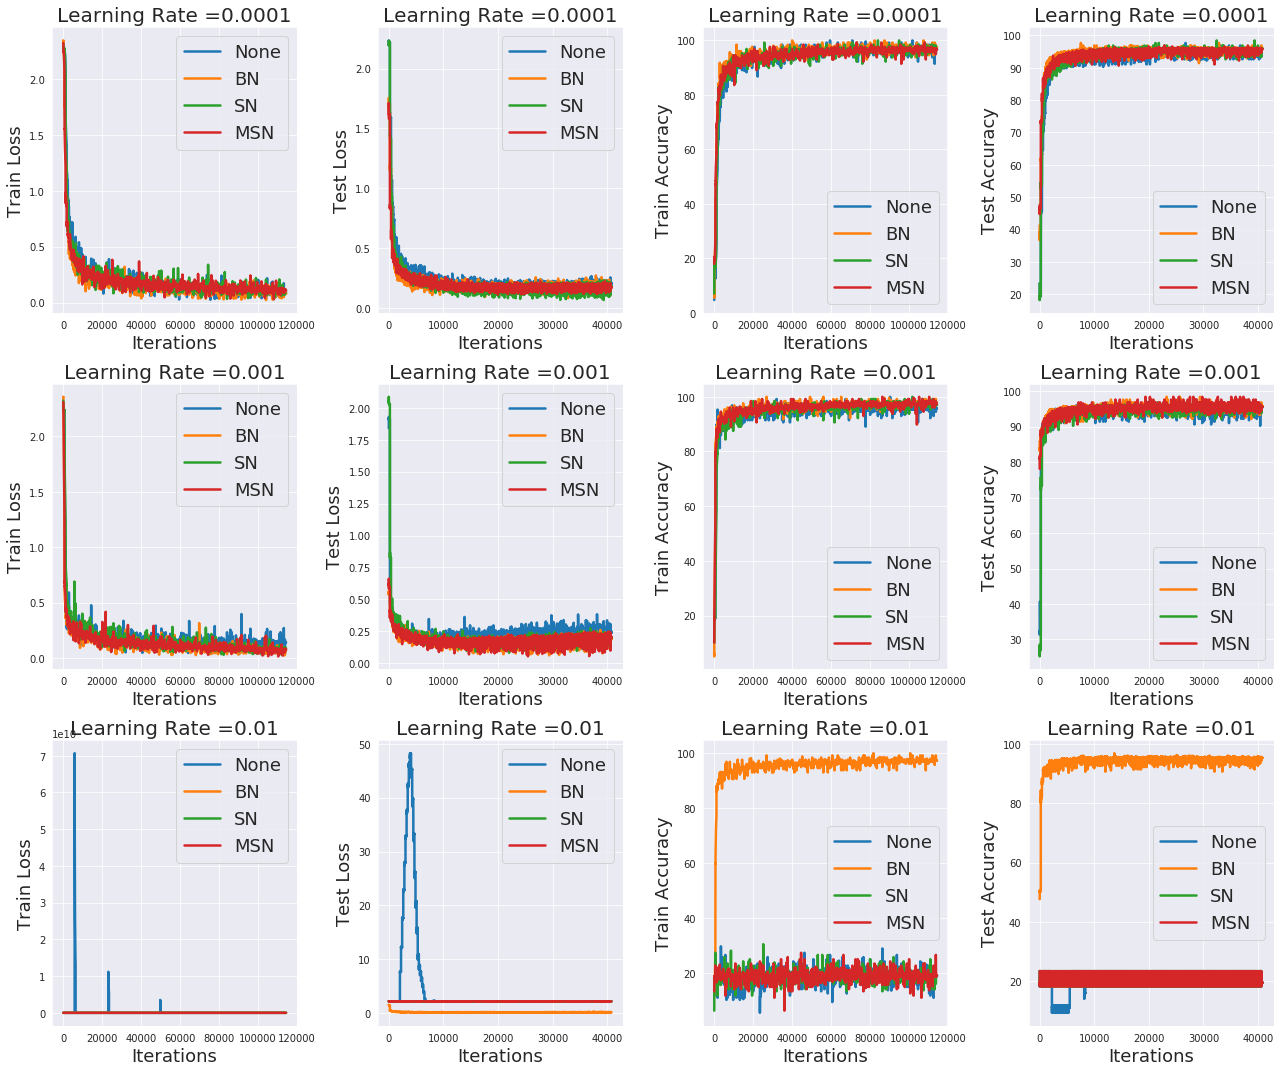

In [7]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook([None,'BN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"WideResNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"WideResNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"WideResNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"WideResNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Act_Norm_Results.pdf', dpi=400)

0
0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4
4


8
8
8



/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


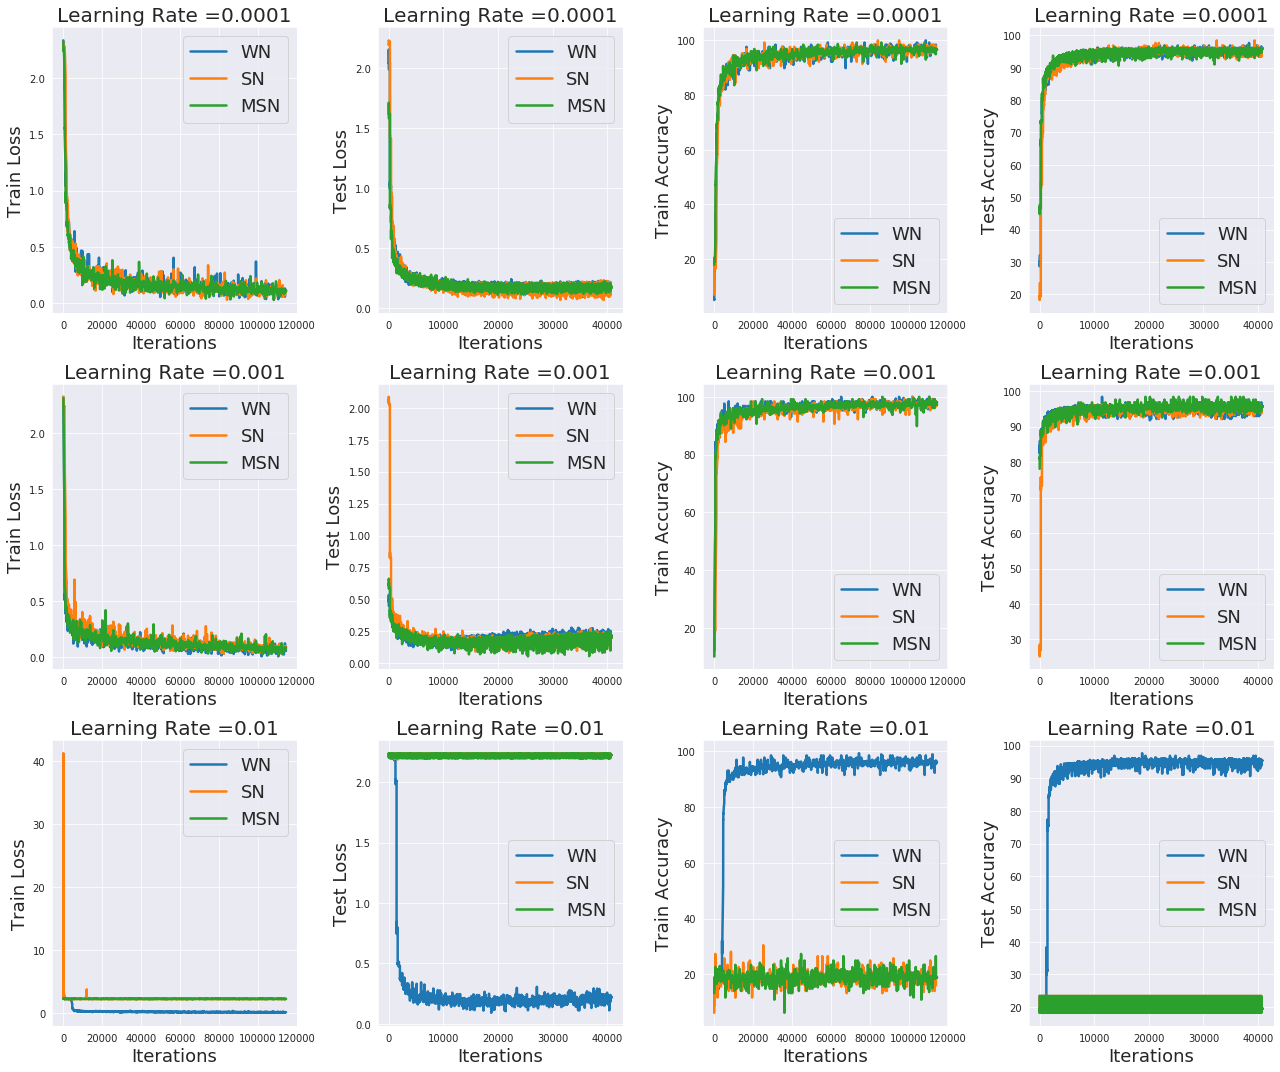

In [8]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['WN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"WideResNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"WideResNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"WideResNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"WideResNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_Results.pdf', dpi=400)

0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4


8
8


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


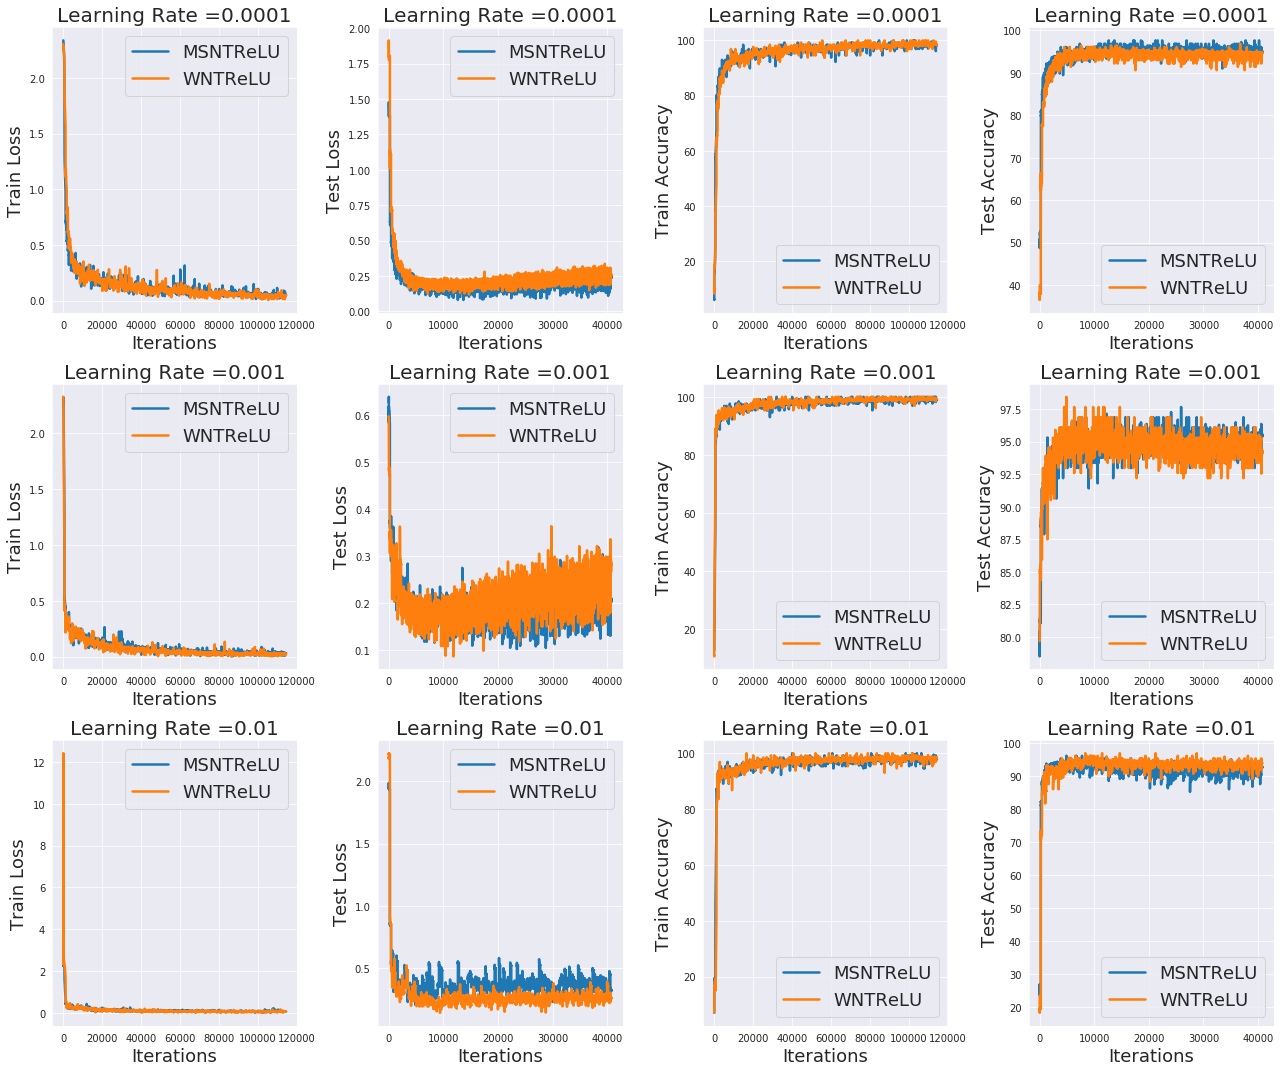

In [9]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['MSNTReLU', 'WNTReLU'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"WideResNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"WideResNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"WideResNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"WideResNet_Test_Acc_{}_{}.npy".format(norm,lr))   

        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_act_Results.pdf', dpi=400)